<a href="https://colab.research.google.com/github/sabeesh90/EVA6_S7/blob/main/Depth_wise_conv_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

##### Importing requisite libraries

In [1]:
  !pip install albumentations==0.4.6
  import torch
  from torchvision import datasets
  from google.colab import drive
  from tqdm import tqdm_notebook
  from PIL import Image
  import numpy as np
  from torchsummary import summary
  import torch
  import torch.nn as nn
  import torch.nn.functional as F
  import albumentations as A
  from torch.optim.lr_scheduler import StepLR
  from torch import optim
  from torch.optim.lr_scheduler import OneCycleLR


##### Mounting the google drive to import model

In [2]:
# mount the drive where we will save stats and loade our libraries from
# from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [4]:
%cd drive/MyDrive/Colab Notebooks/EVA6

/content/drive/MyDrive/Colab Notebooks/EVA6


##### Using cuda for running models on GPU

In [5]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [6]:
import eva6_ass7_model
from  eva6_ass7_model import CifarNet,CifarNet2, CifarNet3,CifarNet4,CifarNet6, CifarNet8, CifarNet10, CifarNet11

In [7]:
model1 = CifarNet()
model2 = CifarNet2()
model3 = CifarNet3()
model4 = CifarNet4()
model6 = CifarNet6()
model8 = CifarNet8()
model10 = CifarNet10()
model11 = CifarNet11()

##### Finding the mean and std for normaliation of images. 

In [8]:
n = 0
s = np.zeros(3)
sq = np.zeros(3)
mean = np.zeros(3)
variance = np.zeros(3)
stand_dev = np.zeros(3)
count = 0

for data, l in tqdm_notebook(train):
  # print(np.array(data).shape)
  x = np.array(data)/255
  # print(x.shape)
  s += x.sum(axis=(0,1)) # this needs to be explained here (why 0,1). how does this work and why normalize and why not just scale to between 0 to 1 by dividing it by 255
  sq += np.sum(np.square(x), axis=(0,1))  # the squared sum is calculated here for what purpose?
  n += x.shape[0]*x.shape[1]
  # print(s)
  # print(n)

  mean+=s/n
  variance += np.square(s - mean)
  stand_dev += np.sqrt(variance/n)
  count+=1

# here mean is calculated across all the channels  and  not just one channel
mu = s/n
# std = np.sqrt((s/n - mu)/1024)
std = np.sqrt((sq/n - np.square(mu))) # how is this  equal to standard deviation?
print(mu, sq/n, std, n)
print(mean/count, stand_dev/count)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000
[0.49196659 0.48229005 0.4461573 ] [227115.06139745 222630.84598793 205985.90869157]


In [9]:
# add path to our library in default search path
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/EVA6')

##### Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [10]:
import torchvision
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [11]:
import numpy as np
from torchvision import transforms

import numpy as np
from torchvision import transforms
from albumentations.pytorch.transforms import ToTensor

channel_means = (0.49196659, 0.48229005, 0.4461573)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
fillmeans = tuple((np.array(channel_means)*255).astype(np.uint8))
# this is  to fill the empty spaces with  means of the channels multiplies by 255 to revert back to an image in that range
print(fillmeans, 'This is the value filled  at the time of rotation')
train_transforms = A.Compose([A.ShiftScaleRotate((-10.5,10.5)),
                              A.HorizontalFlip(),
                              A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=4, min_width=4, fill_value=channel_means),                                                  
                              A.Normalize(mean=channel_means, std=channel_stdevs),
                              ToTensor(),
                              ])

# Test Phase transformations
test_transforms = A.Compose([A.Normalize(mean=channel_means, std=channel_stdevs), ToTensor(),])


(125, 122, 113) This is the value filled  at the time of rotation


##### Dataset and Creating Train/Test Split

In [12]:
from torchvision import datasets
train = Cifar10SearchDataset( train=True, download=True, transform=train_transforms)
test = Cifar10SearchDataset( train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


##### Dataloader Arguments & Test/Train Dataloaders


In [13]:
seed = 1
batch_size = 64

cuda = torch.cuda.is_available()    
if cuda:
    torch.cuda.manual_seed(seed)
    dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

##### Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([64, 3, 32, 32])
torch.Size([64])


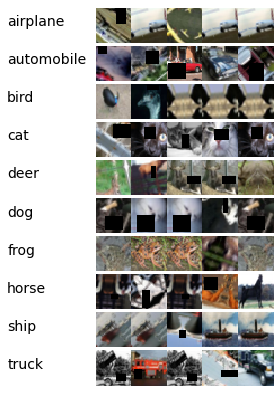

In [14]:
from __future__ import print_function
channel_means = (0.49196659, 0.48229005, 0.4461573)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))
  #return np.transpose(img, (1, 2, 0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

##### Training function

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)
    loss.backward()
    optimizer.step()
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

##### Base model

In [16]:
model1 = model1.to(device)
summary(model1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 16, 16]           2,320
            Conv2d-8           [-1, 16, 16, 16]             160
            Conv2d-9           [-1, 32, 16, 16]             544
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
           Conv2d-12           [-1, 32, 14, 14]           9,248
             ReLU-13           [-1, 32, 14, 14]               0
      BatchNorm2d-14           [-1, 32,

##### Model 2 - Two layers per block

In [17]:
model2 = CifarNet2().to(device)
summary(model2, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 16, 16]           2,320
            Conv2d-8           [-1, 16, 16, 16]             160
            Conv2d-9           [-1, 32, 16, 16]             544
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
           Conv2d-12           [-1, 32, 16, 16]           9,248
             ReLU-13           [-1, 32, 16, 16]               0
      BatchNorm2d-14           [-1, 32,

In [ ]:
EPOCHS = 50
# total 250

from torch.optim.lr_scheduler import StepLR
from torch import optim
from torch.optim.lr_scheduler import OneCycleLR

optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)


for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model2, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model2, device, test_loader)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.6450892090797424 Batch_id=781 Accuracy=75.66: 100%|██████████| 782/782 [00:11<00:00, 70.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4943, Accuracy: 8401/10000 (84.01%)

EPOCH: 1


Loss=0.44946596026420593 Batch_id=781 Accuracy=76.09: 100%|██████████| 782/782 [00:11<00:00, 70.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5003, Accuracy: 8397/10000 (83.97%)

EPOCH: 2


Loss=0.8830438256263733 Batch_id=781 Accuracy=75.95: 100%|██████████| 782/782 [00:11<00:00, 70.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5101, Accuracy: 8386/10000 (83.86%)

EPOCH: 3


Loss=0.8716137409210205 Batch_id=781 Accuracy=76.10: 100%|██████████| 782/782 [00:11<00:00, 69.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5157, Accuracy: 8380/10000 (83.80%)

EPOCH: 4


Loss=0.6152854561805725 Batch_id=781 Accuracy=75.98: 100%|██████████| 782/782 [00:11<00:00, 69.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5197, Accuracy: 8360/10000 (83.60%)

EPOCH: 5


Loss=0.652898907661438 Batch_id=781 Accuracy=75.91: 100%|██████████| 782/782 [00:11<00:00, 69.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5014, Accuracy: 8411/10000 (84.11%)

EPOCH: 6


Loss=0.4112744629383087 Batch_id=781 Accuracy=75.84: 100%|██████████| 782/782 [00:11<00:00, 69.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4987, Accuracy: 8393/10000 (83.93%)

EPOCH: 7


Loss=0.748396098613739 Batch_id=781 Accuracy=75.97: 100%|██████████| 782/782 [00:11<00:00, 69.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5047, Accuracy: 8395/10000 (83.95%)

EPOCH: 8


Loss=0.8856551051139832 Batch_id=781 Accuracy=76.11: 100%|██████████| 782/782 [00:11<00:00, 69.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5055, Accuracy: 8423/10000 (84.23%)

EPOCH: 9


Loss=0.49159708619117737 Batch_id=781 Accuracy=76.26: 100%|██████████| 782/782 [00:11<00:00, 69.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5122, Accuracy: 8351/10000 (83.51%)

EPOCH: 10


Loss=1.0321223735809326 Batch_id=781 Accuracy=76.26: 100%|██████████| 782/782 [00:11<00:00, 70.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5123, Accuracy: 8358/10000 (83.58%)

EPOCH: 11


Loss=0.7487784028053284 Batch_id=781 Accuracy=76.04: 100%|██████████| 782/782 [00:11<00:00, 70.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5145, Accuracy: 8396/10000 (83.96%)

EPOCH: 12


Loss=0.3726541996002197 Batch_id=781 Accuracy=75.71: 100%|██████████| 782/782 [00:11<00:00, 68.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5115, Accuracy: 8387/10000 (83.87%)

EPOCH: 13


Loss=1.593319058418274 Batch_id=781 Accuracy=76.38: 100%|██████████| 782/782 [00:11<00:00, 69.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5192, Accuracy: 8351/10000 (83.51%)

EPOCH: 14


Loss=0.6406829953193665 Batch_id=781 Accuracy=76.15: 100%|██████████| 782/782 [00:11<00:00, 69.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5077, Accuracy: 8376/10000 (83.76%)

EPOCH: 15


Loss=1.6193687915802002 Batch_id=781 Accuracy=76.28: 100%|██████████| 782/782 [00:11<00:00, 69.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5252, Accuracy: 8326/10000 (83.26%)

EPOCH: 16


Loss=0.49290093779563904 Batch_id=781 Accuracy=76.12: 100%|██████████| 782/782 [00:11<00:00, 69.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5014, Accuracy: 8421/10000 (84.21%)

EPOCH: 17


Loss=1.1957488059997559 Batch_id=781 Accuracy=76.14: 100%|██████████| 782/782 [00:11<00:00, 68.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5011, Accuracy: 8397/10000 (83.97%)

EPOCH: 18


Loss=0.791571319103241 Batch_id=781 Accuracy=76.05: 100%|██████████| 782/782 [00:11<00:00, 69.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5178, Accuracy: 8377/10000 (83.77%)

EPOCH: 19


Loss=0.8400029540061951 Batch_id=781 Accuracy=76.50: 100%|██████████| 782/782 [00:11<00:00, 69.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5028, Accuracy: 8383/10000 (83.83%)

EPOCH: 20


Loss=1.0281320810317993 Batch_id=781 Accuracy=76.54: 100%|██████████| 782/782 [00:11<00:00, 69.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5052, Accuracy: 8379/10000 (83.79%)

EPOCH: 21


Loss=0.7354553937911987 Batch_id=781 Accuracy=76.46: 100%|██████████| 782/782 [00:11<00:00, 69.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5026, Accuracy: 8424/10000 (84.24%)

EPOCH: 22


Loss=0.922947347164154 Batch_id=781 Accuracy=76.30: 100%|██████████| 782/782 [00:11<00:00, 68.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5057, Accuracy: 8397/10000 (83.97%)

EPOCH: 23


Loss=0.8101628422737122 Batch_id=781 Accuracy=76.41: 100%|██████████| 782/782 [00:11<00:00, 69.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5106, Accuracy: 8393/10000 (83.93%)

EPOCH: 24


Loss=0.7396855354309082 Batch_id=781 Accuracy=76.50: 100%|██████████| 782/782 [00:11<00:00, 69.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5020, Accuracy: 8390/10000 (83.90%)

EPOCH: 25


Loss=0.5207162499427795 Batch_id=781 Accuracy=76.47: 100%|██████████| 782/782 [00:11<00:00, 69.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4989, Accuracy: 8405/10000 (84.05%)

EPOCH: 26


Loss=0.4088798463344574 Batch_id=781 Accuracy=76.50: 100%|██████████| 782/782 [00:11<00:00, 68.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5108, Accuracy: 8368/10000 (83.68%)

EPOCH: 27


Loss=0.6823444366455078 Batch_id=781 Accuracy=75.98: 100%|██████████| 782/782 [00:11<00:00, 68.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5116, Accuracy: 8348/10000 (83.48%)

EPOCH: 28


Loss=0.3122241199016571 Batch_id=781 Accuracy=76.29: 100%|██████████| 782/782 [00:11<00:00, 68.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5378, Accuracy: 8334/10000 (83.34%)

EPOCH: 29


Loss=0.24959899485111237 Batch_id=781 Accuracy=76.89: 100%|██████████| 782/782 [00:11<00:00, 69.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5101, Accuracy: 8400/10000 (84.00%)

EPOCH: 30


Loss=0.4679138958454132 Batch_id=781 Accuracy=76.42: 100%|██████████| 782/782 [00:11<00:00, 68.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5166, Accuracy: 8431/10000 (84.31%)

EPOCH: 31


Loss=1.3978157043457031 Batch_id=781 Accuracy=76.52: 100%|██████████| 782/782 [00:11<00:00, 68.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5145, Accuracy: 8406/10000 (84.06%)

EPOCH: 32


Loss=1.7371840476989746 Batch_id=781 Accuracy=76.61: 100%|██████████| 782/782 [00:11<00:00, 68.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5247, Accuracy: 8365/10000 (83.65%)

EPOCH: 33


Loss=0.6828744411468506 Batch_id=781 Accuracy=76.49: 100%|██████████| 782/782 [00:11<00:00, 68.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5258, Accuracy: 8347/10000 (83.47%)

EPOCH: 34


Loss=1.0355912446975708 Batch_id=781 Accuracy=76.65: 100%|██████████| 782/782 [00:11<00:00, 68.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5161, Accuracy: 8380/10000 (83.80%)

EPOCH: 35


Loss=1.262499213218689 Batch_id=781 Accuracy=76.66: 100%|██████████| 782/782 [00:11<00:00, 68.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5348, Accuracy: 8368/10000 (83.68%)

EPOCH: 36


Loss=0.7368149757385254 Batch_id=781 Accuracy=76.86: 100%|██████████| 782/782 [00:11<00:00, 68.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5205, Accuracy: 8349/10000 (83.49%)

EPOCH: 37


Loss=0.620580792427063 Batch_id=781 Accuracy=76.58: 100%|██████████| 782/782 [00:11<00:00, 67.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5283, Accuracy: 8363/10000 (83.63%)

EPOCH: 38


Loss=0.5820831656455994 Batch_id=781 Accuracy=76.68: 100%|██████████| 782/782 [00:11<00:00, 68.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5132, Accuracy: 8382/10000 (83.82%)

EPOCH: 39


Loss=0.7041972875595093 Batch_id=781 Accuracy=76.72: 100%|██████████| 782/782 [00:11<00:00, 68.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5286, Accuracy: 8398/10000 (83.98%)

EPOCH: 40


Loss=0.7762371897697449 Batch_id=781 Accuracy=76.62: 100%|██████████| 782/782 [00:11<00:00, 68.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5173, Accuracy: 8352/10000 (83.52%)

EPOCH: 41


Loss=1.0947636365890503 Batch_id=781 Accuracy=76.86: 100%|██████████| 782/782 [00:11<00:00, 68.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5304, Accuracy: 8330/10000 (83.30%)

EPOCH: 42


Loss=0.9551734924316406 Batch_id=781 Accuracy=76.59: 100%|██████████| 782/782 [00:11<00:00, 68.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5114, Accuracy: 8416/10000 (84.16%)

EPOCH: 43


Loss=0.7434815764427185 Batch_id=781 Accuracy=76.74: 100%|██████████| 782/782 [00:11<00:00, 67.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5245, Accuracy: 8322/10000 (83.22%)

EPOCH: 44


Loss=0.473296582698822 Batch_id=781 Accuracy=76.45: 100%|██████████| 782/782 [00:11<00:00, 68.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5291, Accuracy: 8355/10000 (83.55%)

EPOCH: 45


Loss=0.8589483499526978 Batch_id=781 Accuracy=76.64: 100%|██████████| 782/782 [00:11<00:00, 67.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5324, Accuracy: 8366/10000 (83.66%)

EPOCH: 46


Loss=0.986971914768219 Batch_id=781 Accuracy=76.82: 100%|██████████| 782/782 [00:11<00:00, 67.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5366, Accuracy: 8361/10000 (83.61%)

EPOCH: 47


Loss=0.7032930254936218 Batch_id=781 Accuracy=76.55: 100%|██████████| 782/782 [00:11<00:00, 68.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5079, Accuracy: 8343/10000 (83.43%)

EPOCH: 48


Loss=1.0612009763717651 Batch_id=781 Accuracy=77.12: 100%|██████████| 782/782 [00:11<00:00, 67.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5127, Accuracy: 8384/10000 (83.84%)

EPOCH: 49


Loss=0.8732321858406067 Batch_id=781 Accuracy=76.78: 100%|██████████| 782/782 [00:12<00:00, 64.19it/s]



Test set: Average loss: 0.5263, Accuracy: 8374/10000 (83.74%)



##### Model 3 - Three layers per block

In [18]:
model3 = CifarNet3().to(device)
summary(model3, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 32, 32]           2,320
              ReLU-8           [-1, 16, 32, 32]               0
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 16, 16]           2,320
           Conv2d-11           [-1, 16, 16, 16]             160
           Conv2d-12           [-1, 32, 16, 16]             544
             ReLU-13           [-1, 32, 16, 16]               0
      BatchNorm2d-14           [-1, 32,

In [ ]:
EPOCHS = 250

from torch.optim.lr_scheduler import StepLR
from torch import optim
from torch.optim.lr_scheduler import OneCycleLR

optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)


for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model3, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model3, device, test_loader)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.0048792362213135 Batch_id=781 Accuracy=28.85: 100%|██████████| 782/782 [00:11<00:00, 66.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.6024, Accuracy: 4134/10000 (41.34%)

EPOCH: 1


Loss=1.7841227054595947 Batch_id=781 Accuracy=37.11: 100%|██████████| 782/782 [00:11<00:00, 66.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.5132, Accuracy: 4714/10000 (47.14%)

EPOCH: 2


Loss=1.7803269624710083 Batch_id=781 Accuracy=41.35: 100%|██████████| 782/782 [00:11<00:00, 66.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2654, Accuracy: 5439/10000 (54.39%)

EPOCH: 3


Loss=1.9051170349121094 Batch_id=781 Accuracy=45.10: 100%|██████████| 782/782 [00:11<00:00, 66.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2140, Accuracy: 5635/10000 (56.35%)

EPOCH: 4


Loss=1.552187442779541 Batch_id=781 Accuracy=47.33: 100%|██████████| 782/782 [00:11<00:00, 66.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1245, Accuracy: 6018/10000 (60.18%)

EPOCH: 5


Loss=1.1542094945907593 Batch_id=781 Accuracy=49.30: 100%|██████████| 782/782 [00:11<00:00, 66.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0585, Accuracy: 6267/10000 (62.67%)

EPOCH: 6


Loss=1.638466238975525 Batch_id=781 Accuracy=50.76: 100%|██████████| 782/782 [00:11<00:00, 66.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0494, Accuracy: 6254/10000 (62.54%)

EPOCH: 7


Loss=1.475570797920227 Batch_id=781 Accuracy=52.57: 100%|██████████| 782/782 [00:11<00:00, 65.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9686, Accuracy: 6585/10000 (65.85%)

EPOCH: 8


Loss=1.202082872390747 Batch_id=781 Accuracy=53.55: 100%|██████████| 782/782 [00:11<00:00, 65.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9459, Accuracy: 6687/10000 (66.87%)

EPOCH: 9


Loss=1.4671037197113037 Batch_id=781 Accuracy=54.82: 100%|██████████| 782/782 [00:11<00:00, 65.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8952, Accuracy: 6871/10000 (68.71%)

EPOCH: 10


Loss=1.107432246208191 Batch_id=781 Accuracy=55.51: 100%|██████████| 782/782 [00:11<00:00, 65.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8776, Accuracy: 6944/10000 (69.44%)

EPOCH: 11


Loss=1.3466242551803589 Batch_id=781 Accuracy=56.73: 100%|██████████| 782/782 [00:11<00:00, 65.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8794, Accuracy: 6921/10000 (69.21%)

EPOCH: 12


Loss=1.3747807741165161 Batch_id=781 Accuracy=57.58: 100%|██████████| 782/782 [00:11<00:00, 65.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8134, Accuracy: 7134/10000 (71.34%)

EPOCH: 13


Loss=1.1804232597351074 Batch_id=781 Accuracy=58.47: 100%|██████████| 782/782 [00:11<00:00, 65.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8339, Accuracy: 7129/10000 (71.29%)

EPOCH: 14


Loss=1.2333879470825195 Batch_id=781 Accuracy=58.91: 100%|██████████| 782/782 [00:11<00:00, 65.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8007, Accuracy: 7219/10000 (72.19%)

EPOCH: 15


Loss=1.088178277015686 Batch_id=781 Accuracy=59.48: 100%|██████████| 782/782 [00:12<00:00, 65.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7679, Accuracy: 7372/10000 (73.72%)

EPOCH: 16


Loss=0.9268746376037598 Batch_id=781 Accuracy=60.44: 100%|██████████| 782/782 [00:12<00:00, 64.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7549, Accuracy: 7413/10000 (74.13%)

EPOCH: 17


Loss=0.7834419012069702 Batch_id=781 Accuracy=60.61: 100%|██████████| 782/782 [00:11<00:00, 65.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7494, Accuracy: 7417/10000 (74.17%)

EPOCH: 18


Loss=1.1164164543151855 Batch_id=781 Accuracy=61.31: 100%|██████████| 782/782 [00:12<00:00, 64.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7410, Accuracy: 7480/10000 (74.80%)

EPOCH: 19


Loss=2.0654549598693848 Batch_id=781 Accuracy=61.99: 100%|██████████| 782/782 [00:12<00:00, 65.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7463, Accuracy: 7451/10000 (74.51%)

EPOCH: 20


Loss=0.8979891538619995 Batch_id=781 Accuracy=62.90: 100%|██████████| 782/782 [00:12<00:00, 64.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7085, Accuracy: 7528/10000 (75.28%)

EPOCH: 21


Loss=1.1862257719039917 Batch_id=781 Accuracy=63.15: 100%|██████████| 782/782 [00:12<00:00, 64.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6920, Accuracy: 7612/10000 (76.12%)

EPOCH: 22


Loss=0.9050434827804565 Batch_id=781 Accuracy=63.39: 100%|██████████| 782/782 [00:11<00:00, 65.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7073, Accuracy: 7519/10000 (75.19%)

EPOCH: 23


Loss=1.5023407936096191 Batch_id=781 Accuracy=63.98: 100%|██████████| 782/782 [00:12<00:00, 64.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6721, Accuracy: 7650/10000 (76.50%)

EPOCH: 24


Loss=1.3487842082977295 Batch_id=781 Accuracy=64.25: 100%|██████████| 782/782 [00:11<00:00, 65.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6805, Accuracy: 7664/10000 (76.64%)

EPOCH: 25


Loss=1.0242592096328735 Batch_id=781 Accuracy=64.55: 100%|██████████| 782/782 [00:12<00:00, 64.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6552, Accuracy: 7761/10000 (77.61%)

EPOCH: 26


Loss=0.7848647236824036 Batch_id=781 Accuracy=64.65: 100%|██████████| 782/782 [00:12<00:00, 64.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6699, Accuracy: 7703/10000 (77.03%)

EPOCH: 27


Loss=0.5718165040016174 Batch_id=781 Accuracy=65.19: 100%|██████████| 782/782 [00:12<00:00, 64.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6333, Accuracy: 7800/10000 (78.00%)

EPOCH: 28


Loss=0.8391737937927246 Batch_id=781 Accuracy=65.44: 100%|██████████| 782/782 [00:12<00:00, 64.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6309, Accuracy: 7783/10000 (77.83%)

EPOCH: 29


Loss=0.6093122363090515 Batch_id=781 Accuracy=65.78: 100%|██████████| 782/782 [00:12<00:00, 64.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6191, Accuracy: 7901/10000 (79.01%)

EPOCH: 30


Loss=0.5397087931632996 Batch_id=781 Accuracy=66.35: 100%|██████████| 782/782 [00:12<00:00, 64.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6204, Accuracy: 7862/10000 (78.62%)

EPOCH: 31


Loss=1.0292316675186157 Batch_id=781 Accuracy=66.43: 100%|██████████| 782/782 [00:12<00:00, 64.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6339, Accuracy: 7815/10000 (78.15%)

EPOCH: 32


Loss=0.7442502379417419 Batch_id=781 Accuracy=66.95: 100%|██████████| 782/782 [00:12<00:00, 64.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6121, Accuracy: 7912/10000 (79.12%)

EPOCH: 33


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6265, Accuracy: 7866/10000 (78.66%)

EPOCH: 34


Loss=0.8983100652694702 Batch_id=781 Accuracy=67.51: 100%|██████████| 782/782 [00:12<00:00, 64.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5941, Accuracy: 7966/10000 (79.66%)

EPOCH: 35


Loss=0.8435552716255188 Batch_id=781 Accuracy=67.23: 100%|██████████| 782/782 [00:12<00:00, 64.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5879, Accuracy: 8016/10000 (80.16%)

EPOCH: 36


Loss=1.182625412940979 Batch_id=781 Accuracy=67.99: 100%|██████████| 782/782 [00:12<00:00, 64.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6058, Accuracy: 7934/10000 (79.34%)

EPOCH: 37


Loss=1.5427746772766113 Batch_id=781 Accuracy=68.01: 100%|██████████| 782/782 [00:12<00:00, 64.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5870, Accuracy: 8031/10000 (80.31%)

EPOCH: 38


Loss=0.7162694334983826 Batch_id=781 Accuracy=68.25: 100%|██████████| 782/782 [00:12<00:00, 63.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5818, Accuracy: 8035/10000 (80.35%)

EPOCH: 39


Loss=0.6007208228111267 Batch_id=781 Accuracy=68.11: 100%|██████████| 782/782 [00:12<00:00, 64.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5703, Accuracy: 8065/10000 (80.65%)

EPOCH: 40


Loss=0.9820423126220703 Batch_id=781 Accuracy=68.52: 100%|██████████| 782/782 [00:12<00:00, 64.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5760, Accuracy: 8071/10000 (80.71%)

EPOCH: 41


Loss=0.5581613183021545 Batch_id=781 Accuracy=68.52: 100%|██████████| 782/782 [00:12<00:00, 63.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5633, Accuracy: 8091/10000 (80.91%)

EPOCH: 42


Loss=0.5927773118019104 Batch_id=781 Accuracy=69.04: 100%|██████████| 782/782 [00:12<00:00, 64.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5574, Accuracy: 8139/10000 (81.39%)

EPOCH: 43


Loss=0.775082528591156 Batch_id=781 Accuracy=68.83: 100%|██████████| 782/782 [00:12<00:00, 63.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5618, Accuracy: 8113/10000 (81.13%)

EPOCH: 44


Loss=0.9863573312759399 Batch_id=781 Accuracy=69.30: 100%|██████████| 782/782 [00:12<00:00, 63.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5592, Accuracy: 8118/10000 (81.18%)

EPOCH: 45


Loss=0.7946105599403381 Batch_id=781 Accuracy=69.62: 100%|██████████| 782/782 [00:12<00:00, 63.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5626, Accuracy: 8100/10000 (81.00%)

EPOCH: 46


Loss=0.7413367033004761 Batch_id=781 Accuracy=69.25: 100%|██████████| 782/782 [00:12<00:00, 63.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5378, Accuracy: 8167/10000 (81.67%)

EPOCH: 47


Loss=0.9266514778137207 Batch_id=781 Accuracy=69.78: 100%|██████████| 782/782 [00:12<00:00, 63.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5549, Accuracy: 8117/10000 (81.17%)

EPOCH: 48


Loss=1.1502861976623535 Batch_id=781 Accuracy=70.19: 100%|██████████| 782/782 [00:12<00:00, 63.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5436, Accuracy: 8176/10000 (81.76%)

EPOCH: 49


Loss=0.7530606985092163 Batch_id=781 Accuracy=70.24: 100%|██████████| 782/782 [00:12<00:00, 63.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5316, Accuracy: 8169/10000 (81.69%)

EPOCH: 50


Loss=0.8965763449668884 Batch_id=781 Accuracy=70.04: 100%|██████████| 782/782 [00:12<00:00, 63.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5155, Accuracy: 8225/10000 (82.25%)

EPOCH: 51


Loss=1.040806770324707 Batch_id=781 Accuracy=70.10: 100%|██████████| 782/782 [00:12<00:00, 63.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5166, Accuracy: 8236/10000 (82.36%)

EPOCH: 52


Loss=0.9031879305839539 Batch_id=781 Accuracy=70.55: 100%|██████████| 782/782 [00:12<00:00, 63.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5415, Accuracy: 8173/10000 (81.73%)

EPOCH: 53


Loss=1.5133824348449707 Batch_id=781 Accuracy=70.41: 100%|██████████| 782/782 [00:12<00:00, 63.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5342, Accuracy: 8168/10000 (81.68%)

EPOCH: 54


Loss=1.2600903511047363 Batch_id=781 Accuracy=70.68: 100%|██████████| 782/782 [00:12<00:00, 63.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5199, Accuracy: 8260/10000 (82.60%)

EPOCH: 55


Loss=1.516508936882019 Batch_id=781 Accuracy=70.77: 100%|██████████| 782/782 [00:12<00:00, 63.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5010, Accuracy: 8310/10000 (83.10%)

EPOCH: 56


Loss=0.7356507778167725 Batch_id=781 Accuracy=70.91: 100%|██████████| 782/782 [00:12<00:00, 63.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5070, Accuracy: 8316/10000 (83.16%)

EPOCH: 57


Loss=0.5027646422386169 Batch_id=781 Accuracy=71.04: 100%|██████████| 782/782 [00:12<00:00, 62.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5247, Accuracy: 8244/10000 (82.44%)

EPOCH: 58


Loss=1.1324340105056763 Batch_id=781 Accuracy=71.77: 100%|██████████| 782/782 [00:12<00:00, 62.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5173, Accuracy: 8232/10000 (82.32%)

EPOCH: 59


Loss=1.2849082946777344 Batch_id=781 Accuracy=71.47: 100%|██████████| 782/782 [00:12<00:00, 63.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4969, Accuracy: 8299/10000 (82.99%)

EPOCH: 60


Loss=0.9625994563102722 Batch_id=781 Accuracy=71.65: 100%|██████████| 782/782 [00:12<00:00, 61.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5310, Accuracy: 8216/10000 (82.16%)

EPOCH: 61


Loss=0.7766550779342651 Batch_id=781 Accuracy=71.85: 100%|██████████| 782/782 [00:12<00:00, 62.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5060, Accuracy: 8294/10000 (82.94%)

EPOCH: 62


Loss=0.5042124390602112 Batch_id=781 Accuracy=71.42: 100%|██████████| 782/782 [00:12<00:00, 63.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5022, Accuracy: 8295/10000 (82.95%)

EPOCH: 63


Loss=0.8721126914024353 Batch_id=781 Accuracy=72.02: 100%|██████████| 782/782 [00:12<00:00, 63.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5172, Accuracy: 8255/10000 (82.55%)

EPOCH: 64


Loss=0.7919671535491943 Batch_id=781 Accuracy=71.69: 100%|██████████| 782/782 [00:12<00:00, 62.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4937, Accuracy: 8342/10000 (83.42%)

EPOCH: 65


Loss=0.8380870223045349 Batch_id=781 Accuracy=72.00: 100%|██████████| 782/782 [00:12<00:00, 62.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4984, Accuracy: 8361/10000 (83.61%)

EPOCH: 66


Loss=0.7304903864860535 Batch_id=781 Accuracy=71.76: 100%|██████████| 782/782 [00:12<00:00, 62.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4863, Accuracy: 8351/10000 (83.51%)

EPOCH: 67


Loss=0.9657903909683228 Batch_id=781 Accuracy=72.45: 100%|██████████| 782/782 [00:12<00:00, 60.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5039, Accuracy: 8282/10000 (82.82%)

EPOCH: 68


Loss=0.9968559741973877 Batch_id=781 Accuracy=72.43: 100%|██████████| 782/782 [00:12<00:00, 62.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5146, Accuracy: 8290/10000 (82.90%)

EPOCH: 69


Loss=1.2433058023452759 Batch_id=781 Accuracy=72.77: 100%|██████████| 782/782 [00:12<00:00, 62.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4960, Accuracy: 8312/10000 (83.12%)

EPOCH: 70


Loss=0.9469878673553467 Batch_id=781 Accuracy=72.20: 100%|██████████| 782/782 [00:12<00:00, 61.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4981, Accuracy: 8326/10000 (83.26%)

EPOCH: 71


Loss=0.9779598712921143 Batch_id=781 Accuracy=72.71: 100%|██████████| 782/782 [00:12<00:00, 62.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5054, Accuracy: 8271/10000 (82.71%)

EPOCH: 72


Loss=0.5301828980445862 Batch_id=781 Accuracy=72.75: 100%|██████████| 782/782 [00:12<00:00, 62.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4773, Accuracy: 8393/10000 (83.93%)

EPOCH: 73


Loss=0.8214542865753174 Batch_id=781 Accuracy=72.75: 100%|██████████| 782/782 [00:12<00:00, 62.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5163, Accuracy: 8269/10000 (82.69%)

EPOCH: 74


Loss=1.6060737371444702 Batch_id=781 Accuracy=72.86: 100%|██████████| 782/782 [00:12<00:00, 62.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5070, Accuracy: 8301/10000 (83.01%)

EPOCH: 75


Loss=0.5905501842498779 Batch_id=781 Accuracy=72.44: 100%|██████████| 782/782 [00:12<00:00, 62.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4860, Accuracy: 8340/10000 (83.40%)

EPOCH: 76


Loss=0.8499815464019775 Batch_id=781 Accuracy=72.83: 100%|██████████| 782/782 [00:12<00:00, 62.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4986, Accuracy: 8326/10000 (83.26%)

EPOCH: 77


Loss=1.328530192375183 Batch_id=781 Accuracy=73.01: 100%|██████████| 782/782 [00:12<00:00, 62.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4976, Accuracy: 8316/10000 (83.16%)

EPOCH: 78


Loss=1.2864612340927124 Batch_id=781 Accuracy=73.33: 100%|██████████| 782/782 [00:12<00:00, 62.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4944, Accuracy: 8334/10000 (83.34%)

EPOCH: 79


Loss=1.0175281763076782 Batch_id=781 Accuracy=73.03: 100%|██████████| 782/782 [00:12<00:00, 61.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4963, Accuracy: 8368/10000 (83.68%)

EPOCH: 80


Loss=1.0558898448944092 Batch_id=781 Accuracy=73.41: 100%|██████████| 782/782 [00:12<00:00, 62.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4916, Accuracy: 8361/10000 (83.61%)

EPOCH: 81


Loss=1.2467081546783447 Batch_id=781 Accuracy=73.33: 100%|██████████| 782/782 [00:12<00:00, 62.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4762, Accuracy: 8374/10000 (83.74%)

EPOCH: 82


Loss=1.1231861114501953 Batch_id=781 Accuracy=73.65: 100%|██████████| 782/782 [00:12<00:00, 63.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4897, Accuracy: 8335/10000 (83.35%)

EPOCH: 83


Loss=1.0766124725341797 Batch_id=781 Accuracy=73.42: 100%|██████████| 782/782 [00:12<00:00, 63.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4867, Accuracy: 8319/10000 (83.19%)

EPOCH: 84


Loss=0.7146455645561218 Batch_id=781 Accuracy=73.47: 100%|██████████| 782/782 [00:12<00:00, 62.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4635, Accuracy: 8435/10000 (84.35%)

EPOCH: 85


Loss=0.6027975678443909 Batch_id=781 Accuracy=73.90: 100%|██████████| 782/782 [00:12<00:00, 62.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4752, Accuracy: 8441/10000 (84.41%)

EPOCH: 86


Loss=1.4084205627441406 Batch_id=781 Accuracy=73.57: 100%|██████████| 782/782 [00:12<00:00, 62.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4778, Accuracy: 8393/10000 (83.93%)

EPOCH: 87


Loss=1.7114015817642212 Batch_id=781 Accuracy=73.89: 100%|██████████| 782/782 [00:12<00:00, 62.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4872, Accuracy: 8376/10000 (83.76%)

EPOCH: 88


Loss=0.9781224131584167 Batch_id=781 Accuracy=73.79: 100%|██████████| 782/782 [00:12<00:00, 62.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4827, Accuracy: 8391/10000 (83.91%)

EPOCH: 89


Loss=0.8770009279251099 Batch_id=781 Accuracy=74.18: 100%|██████████| 782/782 [00:12<00:00, 61.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4864, Accuracy: 8385/10000 (83.85%)

EPOCH: 90


Loss=1.0019232034683228 Batch_id=781 Accuracy=73.95: 100%|██████████| 782/782 [00:12<00:00, 61.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4796, Accuracy: 8408/10000 (84.08%)

EPOCH: 91


Loss=0.7600656747817993 Batch_id=781 Accuracy=73.81: 100%|██████████| 782/782 [00:12<00:00, 61.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4818, Accuracy: 8389/10000 (83.89%)

EPOCH: 92


Loss=0.9215536117553711 Batch_id=781 Accuracy=74.22: 100%|██████████| 782/782 [00:12<00:00, 61.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4801, Accuracy: 8379/10000 (83.79%)

EPOCH: 93


Loss=1.0360877513885498 Batch_id=781 Accuracy=74.45: 100%|██████████| 782/782 [00:12<00:00, 61.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4757, Accuracy: 8407/10000 (84.07%)

EPOCH: 94


Loss=1.0320805311203003 Batch_id=781 Accuracy=73.83: 100%|██████████| 782/782 [00:12<00:00, 60.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4819, Accuracy: 8406/10000 (84.06%)

EPOCH: 95


Loss=0.373073935508728 Batch_id=781 Accuracy=74.04: 100%|██████████| 782/782 [00:12<00:00, 61.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4744, Accuracy: 8395/10000 (83.95%)

EPOCH: 96


Loss=0.5756685733795166 Batch_id=781 Accuracy=74.51: 100%|██████████| 782/782 [00:12<00:00, 60.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4877, Accuracy: 8350/10000 (83.50%)

EPOCH: 97


Loss=0.8200343251228333 Batch_id=781 Accuracy=74.06: 100%|██████████| 782/782 [00:12<00:00, 61.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4823, Accuracy: 8368/10000 (83.68%)

EPOCH: 98


Loss=0.49253925681114197 Batch_id=781 Accuracy=74.62: 100%|██████████| 782/782 [00:12<00:00, 61.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4730, Accuracy: 8417/10000 (84.17%)

EPOCH: 99


Loss=0.7976092100143433 Batch_id=781 Accuracy=74.36: 100%|██████████| 782/782 [00:12<00:00, 61.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4729, Accuracy: 8429/10000 (84.29%)

EPOCH: 100


Loss=0.7085366249084473 Batch_id=781 Accuracy=74.59: 100%|██████████| 782/782 [00:12<00:00, 61.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4763, Accuracy: 8386/10000 (83.86%)

EPOCH: 101


Loss=0.606970489025116 Batch_id=781 Accuracy=74.73: 100%|██████████| 782/782 [00:12<00:00, 61.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4786, Accuracy: 8390/10000 (83.90%)

EPOCH: 102


Loss=0.9881614446640015 Batch_id=781 Accuracy=74.98: 100%|██████████| 782/782 [00:12<00:00, 61.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4846, Accuracy: 8370/10000 (83.70%)

EPOCH: 103


Loss=0.5894598960876465 Batch_id=781 Accuracy=75.26: 100%|██████████| 782/782 [00:12<00:00, 61.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4820, Accuracy: 8422/10000 (84.22%)

EPOCH: 104


Loss=0.3914526104927063 Batch_id=781 Accuracy=74.85: 100%|██████████| 782/782 [00:12<00:00, 61.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4752, Accuracy: 8463/10000 (84.63%)

EPOCH: 105


Loss=0.728146493434906 Batch_id=781 Accuracy=75.06: 100%|██████████| 782/782 [00:12<00:00, 60.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4805, Accuracy: 8405/10000 (84.05%)

EPOCH: 106


Loss=0.8780101537704468 Batch_id=781 Accuracy=75.04: 100%|██████████| 782/782 [00:12<00:00, 61.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4663, Accuracy: 8420/10000 (84.20%)

EPOCH: 107


Loss=0.8600776791572571 Batch_id=781 Accuracy=75.20: 100%|██████████| 782/782 [00:12<00:00, 61.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4839, Accuracy: 8412/10000 (84.12%)

EPOCH: 108


Loss=1.5406486988067627 Batch_id=781 Accuracy=75.11: 100%|██████████| 782/782 [00:12<00:00, 60.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4799, Accuracy: 8421/10000 (84.21%)

EPOCH: 109


Loss=0.3149099051952362 Batch_id=781 Accuracy=75.08: 100%|██████████| 782/782 [00:12<00:00, 61.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4706, Accuracy: 8373/10000 (83.73%)

EPOCH: 110


Loss=0.3870604336261749 Batch_id=781 Accuracy=75.28: 100%|██████████| 782/782 [00:12<00:00, 60.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4638, Accuracy: 8499/10000 (84.99%)

EPOCH: 111


Loss=0.9037377834320068 Batch_id=781 Accuracy=75.43: 100%|██████████| 782/782 [00:12<00:00, 60.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4508, Accuracy: 8485/10000 (84.85%)

EPOCH: 112


Loss=0.4659608006477356 Batch_id=781 Accuracy=75.19: 100%|██████████| 782/782 [00:12<00:00, 60.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4725, Accuracy: 8425/10000 (84.25%)

EPOCH: 113


Loss=0.5949187874794006 Batch_id=781 Accuracy=75.29: 100%|██████████| 782/782 [00:12<00:00, 61.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4668, Accuracy: 8453/10000 (84.53%)

EPOCH: 114


Loss=1.0548145771026611 Batch_id=781 Accuracy=75.31: 100%|██████████| 782/782 [00:12<00:00, 61.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4697, Accuracy: 8468/10000 (84.68%)

EPOCH: 115


Loss=1.1737688779830933 Batch_id=781 Accuracy=75.73: 100%|██████████| 782/782 [00:12<00:00, 61.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4750, Accuracy: 8448/10000 (84.48%)

EPOCH: 116


Loss=0.8910346627235413 Batch_id=781 Accuracy=75.41: 100%|██████████| 782/782 [00:12<00:00, 61.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4864, Accuracy: 8378/10000 (83.78%)

EPOCH: 117


Loss=0.8620792627334595 Batch_id=781 Accuracy=75.35: 100%|██████████| 782/782 [00:12<00:00, 60.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4633, Accuracy: 8486/10000 (84.86%)

EPOCH: 118


Loss=0.6518422365188599 Batch_id=781 Accuracy=75.80: 100%|██████████| 782/782 [00:12<00:00, 61.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4634, Accuracy: 8475/10000 (84.75%)

EPOCH: 119


Loss=0.7940817475318909 Batch_id=781 Accuracy=75.95: 100%|██████████| 782/782 [00:12<00:00, 60.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4759, Accuracy: 8471/10000 (84.71%)

EPOCH: 120


Loss=0.3085995018482208 Batch_id=781 Accuracy=75.80: 100%|██████████| 782/782 [00:12<00:00, 61.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4739, Accuracy: 8430/10000 (84.30%)

EPOCH: 121


Loss=0.5194385051727295 Batch_id=781 Accuracy=75.52: 100%|██████████| 782/782 [00:12<00:00, 60.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4718, Accuracy: 8435/10000 (84.35%)

EPOCH: 122


Loss=0.3176057040691376 Batch_id=781 Accuracy=75.70: 100%|██████████| 782/782 [00:12<00:00, 60.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4720, Accuracy: 8436/10000 (84.36%)

EPOCH: 123


Loss=1.051542043685913 Batch_id=781 Accuracy=76.06: 100%|██████████| 782/782 [00:12<00:00, 60.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4827, Accuracy: 8409/10000 (84.09%)

EPOCH: 124


Loss=0.7431423664093018 Batch_id=781 Accuracy=75.82: 100%|██████████| 782/782 [00:12<00:00, 60.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4654, Accuracy: 8490/10000 (84.90%)

EPOCH: 125


Loss=1.068002700805664 Batch_id=781 Accuracy=76.17: 100%|██████████| 782/782 [00:12<00:00, 61.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4585, Accuracy: 8551/10000 (85.51%)

EPOCH: 126


Loss=0.7155808210372925 Batch_id=781 Accuracy=76.18: 100%|██████████| 782/782 [00:13<00:00, 60.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4569, Accuracy: 8487/10000 (84.87%)

EPOCH: 127


Loss=0.9614155888557434 Batch_id=781 Accuracy=76.20: 100%|██████████| 782/782 [00:12<00:00, 60.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4568, Accuracy: 8503/10000 (85.03%)

EPOCH: 128


Loss=0.5280888080596924 Batch_id=781 Accuracy=75.91: 100%|██████████| 782/782 [00:12<00:00, 60.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4693, Accuracy: 8449/10000 (84.49%)

EPOCH: 129


Loss=0.9965351819992065 Batch_id=781 Accuracy=75.68: 100%|██████████| 782/782 [00:12<00:00, 60.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4783, Accuracy: 8435/10000 (84.35%)

EPOCH: 130


Loss=0.5212991833686829 Batch_id=781 Accuracy=76.33: 100%|██████████| 782/782 [00:12<00:00, 60.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4769, Accuracy: 8455/10000 (84.55%)

EPOCH: 131


Loss=1.0754449367523193 Batch_id=781 Accuracy=76.17: 100%|██████████| 782/782 [00:13<00:00, 60.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4750, Accuracy: 8470/10000 (84.70%)

EPOCH: 132


Loss=0.9815334677696228 Batch_id=781 Accuracy=76.21: 100%|██████████| 782/782 [00:12<00:00, 60.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4610, Accuracy: 8505/10000 (85.05%)

EPOCH: 133


Loss=1.0431408882141113 Batch_id=781 Accuracy=76.42: 100%|██████████| 782/782 [00:13<00:00, 59.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4684, Accuracy: 8478/10000 (84.78%)

EPOCH: 134


Loss=1.6093480587005615 Batch_id=781 Accuracy=76.15: 100%|██████████| 782/782 [00:12<00:00, 60.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4597, Accuracy: 8503/10000 (85.03%)

EPOCH: 135


Loss=1.0476540327072144 Batch_id=781 Accuracy=76.29: 100%|██████████| 782/782 [00:12<00:00, 60.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4697, Accuracy: 8465/10000 (84.65%)

EPOCH: 136


Loss=1.2548123598098755 Batch_id=781 Accuracy=76.37: 100%|██████████| 782/782 [00:12<00:00, 60.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4657, Accuracy: 8506/10000 (85.06%)

EPOCH: 137


Loss=0.6055805087089539 Batch_id=781 Accuracy=76.32: 100%|██████████| 782/782 [00:13<00:00, 58.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4619, Accuracy: 8481/10000 (84.81%)

EPOCH: 138


Loss=0.8544309139251709 Batch_id=781 Accuracy=76.45: 100%|██████████| 782/782 [00:12<00:00, 60.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4836, Accuracy: 8471/10000 (84.71%)

EPOCH: 139


Loss=0.766683042049408 Batch_id=781 Accuracy=76.38: 100%|██████████| 782/782 [00:12<00:00, 60.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4620, Accuracy: 8507/10000 (85.07%)

EPOCH: 140


Loss=0.44387373328208923 Batch_id=781 Accuracy=76.56: 100%|██████████| 782/782 [00:12<00:00, 60.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4614, Accuracy: 8498/10000 (84.98%)

EPOCH: 141


Loss=0.5151662230491638 Batch_id=781 Accuracy=76.61: 100%|██████████| 782/782 [00:13<00:00, 60.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4571, Accuracy: 8519/10000 (85.19%)

EPOCH: 142


Loss=0.3404334485530853 Batch_id=781 Accuracy=76.57: 100%|██████████| 782/782 [00:12<00:00, 60.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4650, Accuracy: 8482/10000 (84.82%)

EPOCH: 143


Loss=0.636766791343689 Batch_id=781 Accuracy=76.69: 100%|██████████| 782/782 [00:12<00:00, 60.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4813, Accuracy: 8442/10000 (84.42%)

EPOCH: 144


Loss=0.824637234210968 Batch_id=781 Accuracy=76.90: 100%|██████████| 782/782 [00:13<00:00, 58.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4514, Accuracy: 8500/10000 (85.00%)

EPOCH: 145


Loss=0.5505779385566711 Batch_id=781 Accuracy=77.20: 100%|██████████| 782/782 [00:12<00:00, 60.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4584, Accuracy: 8520/10000 (85.20%)

EPOCH: 146


Loss=0.7476063370704651 Batch_id=781 Accuracy=76.71: 100%|██████████| 782/782 [00:13<00:00, 59.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4533, Accuracy: 8579/10000 (85.79%)

EPOCH: 147


Loss=0.8553306460380554 Batch_id=781 Accuracy=76.77: 100%|██████████| 782/782 [00:13<00:00, 59.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4661, Accuracy: 8463/10000 (84.63%)

EPOCH: 148


Loss=0.5722292065620422 Batch_id=781 Accuracy=76.92: 100%|██████████| 782/782 [00:13<00:00, 59.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4537, Accuracy: 8542/10000 (85.42%)

EPOCH: 149


Loss=0.2521578073501587 Batch_id=781 Accuracy=76.87: 100%|██████████| 782/782 [00:13<00:00, 59.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4600, Accuracy: 8506/10000 (85.06%)

EPOCH: 150


Loss=0.47530147433280945 Batch_id=781 Accuracy=76.83: 100%|██████████| 782/782 [00:13<00:00, 59.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4590, Accuracy: 8499/10000 (84.99%)

EPOCH: 151


Loss=0.9714869856834412 Batch_id=781 Accuracy=77.03: 100%|██████████| 782/782 [00:13<00:00, 59.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4761, Accuracy: 8493/10000 (84.93%)

EPOCH: 152


Loss=1.0028982162475586 Batch_id=781 Accuracy=76.84: 100%|██████████| 782/782 [00:12<00:00, 60.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4649, Accuracy: 8537/10000 (85.37%)

EPOCH: 153


Loss=0.8454026579856873 Batch_id=781 Accuracy=76.87: 100%|██████████| 782/782 [00:12<00:00, 60.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4556, Accuracy: 8512/10000 (85.12%)

EPOCH: 154


Loss=1.0935066938400269 Batch_id=781 Accuracy=76.42: 100%|██████████| 782/782 [00:13<00:00, 59.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4568, Accuracy: 8543/10000 (85.43%)

EPOCH: 155


Loss=1.0921294689178467 Batch_id=781 Accuracy=77.28: 100%|██████████| 782/782 [00:13<00:00, 59.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4603, Accuracy: 8532/10000 (85.32%)

EPOCH: 156


Loss=1.2310916185379028 Batch_id=781 Accuracy=76.97: 100%|██████████| 782/782 [00:13<00:00, 59.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4658, Accuracy: 8526/10000 (85.26%)

EPOCH: 157


Loss=0.9273490905761719 Batch_id=781 Accuracy=77.29: 100%|██████████| 782/782 [00:13<00:00, 59.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4495, Accuracy: 8578/10000 (85.78%)

EPOCH: 158


Loss=0.38461369276046753 Batch_id=781 Accuracy=77.24: 100%|██████████| 782/782 [00:13<00:00, 59.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4456, Accuracy: 8549/10000 (85.49%)

EPOCH: 159


Loss=0.18917174637317657 Batch_id=781 Accuracy=77.07: 100%|██████████| 782/782 [00:13<00:00, 59.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4610, Accuracy: 8506/10000 (85.06%)

EPOCH: 160


Loss=0.48121827840805054 Batch_id=781 Accuracy=77.09: 100%|██████████| 782/782 [00:13<00:00, 60.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4475, Accuracy: 8550/10000 (85.50%)

EPOCH: 161


Loss=0.7779392004013062 Batch_id=781 Accuracy=77.40: 100%|██████████| 782/782 [00:13<00:00, 59.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4610, Accuracy: 8543/10000 (85.43%)

EPOCH: 162


Loss=1.1763769388198853 Batch_id=781 Accuracy=77.21: 100%|██████████| 782/782 [00:13<00:00, 59.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4569, Accuracy: 8577/10000 (85.77%)

EPOCH: 163


Loss=0.9881904125213623 Batch_id=781 Accuracy=77.31: 100%|██████████| 782/782 [00:13<00:00, 59.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4482, Accuracy: 8577/10000 (85.77%)

EPOCH: 164


Loss=0.4985359013080597 Batch_id=781 Accuracy=77.31: 100%|██████████| 782/782 [00:13<00:00, 59.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4628, Accuracy: 8532/10000 (85.32%)

EPOCH: 165


Loss=0.9585164785385132 Batch_id=781 Accuracy=76.95: 100%|██████████| 782/782 [00:13<00:00, 59.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4570, Accuracy: 8532/10000 (85.32%)

EPOCH: 166


Loss=0.7900970578193665 Batch_id=781 Accuracy=77.53: 100%|██████████| 782/782 [00:13<00:00, 59.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4476, Accuracy: 8567/10000 (85.67%)

EPOCH: 167


Loss=0.7995954751968384 Batch_id=781 Accuracy=77.37: 100%|██████████| 782/782 [00:13<00:00, 59.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4591, Accuracy: 8528/10000 (85.28%)

EPOCH: 168


Loss=0.29860353469848633 Batch_id=781 Accuracy=77.23: 100%|██████████| 782/782 [00:13<00:00, 59.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4457, Accuracy: 8544/10000 (85.44%)

EPOCH: 169


Loss=0.6689350008964539 Batch_id=781 Accuracy=77.29: 100%|██████████| 782/782 [00:13<00:00, 59.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4445, Accuracy: 8558/10000 (85.58%)

EPOCH: 170


Loss=1.0170652866363525 Batch_id=781 Accuracy=77.43: 100%|██████████| 782/782 [00:13<00:00, 59.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4526, Accuracy: 8550/10000 (85.50%)

EPOCH: 171


Loss=0.5550050735473633 Batch_id=781 Accuracy=77.39: 100%|██████████| 782/782 [00:13<00:00, 59.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4469, Accuracy: 8555/10000 (85.55%)

EPOCH: 172


Loss=0.5632898807525635 Batch_id=781 Accuracy=77.37: 100%|██████████| 782/782 [00:13<00:00, 59.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4491, Accuracy: 8551/10000 (85.51%)

EPOCH: 173


Loss=0.3622280955314636 Batch_id=781 Accuracy=77.57: 100%|██████████| 782/782 [00:13<00:00, 59.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4497, Accuracy: 8547/10000 (85.47%)

EPOCH: 174


Loss=1.0597981214523315 Batch_id=781 Accuracy=77.55: 100%|██████████| 782/782 [00:13<00:00, 59.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4540, Accuracy: 8537/10000 (85.37%)

EPOCH: 175


Loss=0.6150894165039062 Batch_id=781 Accuracy=77.61: 100%|██████████| 782/782 [00:13<00:00, 58.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4770, Accuracy: 8499/10000 (84.99%)

EPOCH: 176


Loss=0.385024756193161 Batch_id=781 Accuracy=77.44: 100%|██████████| 782/782 [00:13<00:00, 59.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4595, Accuracy: 8530/10000 (85.30%)

EPOCH: 177


Loss=1.129683494567871 Batch_id=781 Accuracy=77.55: 100%|██████████| 782/782 [00:13<00:00, 59.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4589, Accuracy: 8518/10000 (85.18%)

EPOCH: 178


Loss=1.0443533658981323 Batch_id=781 Accuracy=77.79: 100%|██████████| 782/782 [00:13<00:00, 59.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4475, Accuracy: 8569/10000 (85.69%)

EPOCH: 179


Loss=0.3529670536518097 Batch_id=781 Accuracy=77.47: 100%|██████████| 782/782 [00:13<00:00, 59.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4497, Accuracy: 8551/10000 (85.51%)

EPOCH: 180


Loss=1.0890827178955078 Batch_id=781 Accuracy=77.42: 100%|██████████| 782/782 [00:13<00:00, 59.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4459, Accuracy: 8541/10000 (85.41%)

EPOCH: 181


Loss=0.6923103332519531 Batch_id=781 Accuracy=77.77: 100%|██████████| 782/782 [00:13<00:00, 59.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4588, Accuracy: 8495/10000 (84.95%)

EPOCH: 182


Loss=0.8204225897789001 Batch_id=781 Accuracy=77.81: 100%|██████████| 782/782 [00:13<00:00, 59.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4572, Accuracy: 8553/10000 (85.53%)

EPOCH: 183


Loss=1.245215654373169 Batch_id=781 Accuracy=77.49: 100%|██████████| 782/782 [00:13<00:00, 58.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4549, Accuracy: 8578/10000 (85.78%)

EPOCH: 184


Loss=0.5307672023773193 Batch_id=781 Accuracy=77.79: 100%|██████████| 782/782 [00:13<00:00, 59.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4690, Accuracy: 8540/10000 (85.40%)

EPOCH: 185


Loss=0.9292975664138794 Batch_id=781 Accuracy=77.81: 100%|██████████| 782/782 [00:13<00:00, 59.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4557, Accuracy: 8560/10000 (85.60%)

EPOCH: 186


Loss=0.5430721640586853 Batch_id=781 Accuracy=77.80: 100%|██████████| 782/782 [00:13<00:00, 59.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4556, Accuracy: 8512/10000 (85.12%)

EPOCH: 187


Loss=1.341566801071167 Batch_id=781 Accuracy=78.11: 100%|██████████| 782/782 [00:13<00:00, 59.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4629, Accuracy: 8550/10000 (85.50%)

EPOCH: 188


Loss=0.26600930094718933 Batch_id=781 Accuracy=78.20: 100%|██████████| 782/782 [00:13<00:00, 58.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4538, Accuracy: 8561/10000 (85.61%)

EPOCH: 189


Loss=0.6501559019088745 Batch_id=781 Accuracy=78.25: 100%|██████████| 782/782 [00:13<00:00, 59.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4531, Accuracy: 8565/10000 (85.65%)

EPOCH: 190


Loss=0.7437723278999329 Batch_id=781 Accuracy=77.81: 100%|██████████| 782/782 [00:13<00:00, 59.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4542, Accuracy: 8552/10000 (85.52%)

EPOCH: 191


Loss=0.5785154700279236 Batch_id=781 Accuracy=78.25: 100%|██████████| 782/782 [00:13<00:00, 58.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4593, Accuracy: 8539/10000 (85.39%)

EPOCH: 192


Loss=0.6769891977310181 Batch_id=781 Accuracy=77.94: 100%|██████████| 782/782 [00:13<00:00, 59.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4586, Accuracy: 8557/10000 (85.57%)

EPOCH: 193


Loss=1.1810768842697144 Batch_id=781 Accuracy=77.87: 100%|██████████| 782/782 [00:13<00:00, 58.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4495, Accuracy: 8566/10000 (85.66%)

EPOCH: 194


Loss=0.8100631833076477 Batch_id=781 Accuracy=78.38: 100%|██████████| 782/782 [00:13<00:00, 58.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4532, Accuracy: 8581/10000 (85.81%)

EPOCH: 195


Loss=1.445358395576477 Batch_id=781 Accuracy=77.81: 100%|██████████| 782/782 [00:13<00:00, 58.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4447, Accuracy: 8599/10000 (85.99%)

EPOCH: 196


Loss=1.3816494941711426 Batch_id=781 Accuracy=78.14: 100%|██████████| 782/782 [00:13<00:00, 58.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4540, Accuracy: 8585/10000 (85.85%)

EPOCH: 197


Loss=0.5386229753494263 Batch_id=781 Accuracy=78.18: 100%|██████████| 782/782 [00:13<00:00, 58.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4678, Accuracy: 8517/10000 (85.17%)

EPOCH: 198


Loss=0.5839985609054565 Batch_id=781 Accuracy=78.16: 100%|██████████| 782/782 [00:13<00:00, 58.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4530, Accuracy: 8558/10000 (85.58%)

EPOCH: 199


Loss=1.2282207012176514 Batch_id=781 Accuracy=78.08: 100%|██████████| 782/782 [00:13<00:00, 58.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4561, Accuracy: 8554/10000 (85.54%)

EPOCH: 200


Loss=1.0103919506072998 Batch_id=781 Accuracy=78.26: 100%|██████████| 782/782 [00:13<00:00, 58.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4451, Accuracy: 8580/10000 (85.80%)

EPOCH: 201


Loss=0.5226014256477356 Batch_id=781 Accuracy=78.23: 100%|██████████| 782/782 [00:13<00:00, 58.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4542, Accuracy: 8550/10000 (85.50%)

EPOCH: 202


Loss=0.5266465544700623 Batch_id=781 Accuracy=78.28: 100%|██████████| 782/782 [00:13<00:00, 58.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4540, Accuracy: 8559/10000 (85.59%)

EPOCH: 203


Loss=0.889311671257019 Batch_id=781 Accuracy=78.47: 100%|██████████| 782/782 [00:13<00:00, 58.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4727, Accuracy: 8527/10000 (85.27%)

EPOCH: 204


Loss=0.5791445374488831 Batch_id=781 Accuracy=78.31: 100%|██████████| 782/782 [00:13<00:00, 58.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4493, Accuracy: 8575/10000 (85.75%)

EPOCH: 205


Loss=0.984099268913269 Batch_id=781 Accuracy=78.62: 100%|██████████| 782/782 [00:13<00:00, 58.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4729, Accuracy: 8523/10000 (85.23%)

EPOCH: 206


Loss=0.6212303638458252 Batch_id=781 Accuracy=78.45: 100%|██████████| 782/782 [00:13<00:00, 58.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4463, Accuracy: 8560/10000 (85.60%)

EPOCH: 207


Loss=1.4280411005020142 Batch_id=781 Accuracy=78.19: 100%|██████████| 782/782 [00:13<00:00, 58.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4605, Accuracy: 8543/10000 (85.43%)

EPOCH: 208


Loss=0.6495219469070435 Batch_id=781 Accuracy=78.54: 100%|██████████| 782/782 [00:13<00:00, 58.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4623, Accuracy: 8582/10000 (85.82%)

EPOCH: 209


Loss=0.4744030237197876 Batch_id=781 Accuracy=78.47: 100%|██████████| 782/782 [00:13<00:00, 58.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4414, Accuracy: 8586/10000 (85.86%)

EPOCH: 210


Loss=1.0758761167526245 Batch_id=781 Accuracy=78.29: 100%|██████████| 782/782 [00:13<00:00, 58.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4634, Accuracy: 8544/10000 (85.44%)

EPOCH: 211


Loss=0.9115259051322937 Batch_id=781 Accuracy=78.61: 100%|██████████| 782/782 [00:13<00:00, 58.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4515, Accuracy: 8570/10000 (85.70%)

EPOCH: 212


Loss=0.85802161693573 Batch_id=781 Accuracy=78.62: 100%|██████████| 782/782 [00:13<00:00, 58.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4622, Accuracy: 8562/10000 (85.62%)

EPOCH: 213


Loss=1.7361440658569336 Batch_id=781 Accuracy=78.60: 100%|██████████| 782/782 [00:13<00:00, 58.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4518, Accuracy: 8595/10000 (85.95%)

EPOCH: 214


Loss=0.8529105186462402 Batch_id=781 Accuracy=78.46: 100%|██████████| 782/782 [00:13<00:00, 58.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4507, Accuracy: 8546/10000 (85.46%)

EPOCH: 215


Loss=0.8454140424728394 Batch_id=781 Accuracy=78.21: 100%|██████████| 782/782 [00:13<00:00, 58.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4494, Accuracy: 8554/10000 (85.54%)

EPOCH: 216


Loss=1.1006929874420166 Batch_id=781 Accuracy=78.83: 100%|██████████| 782/782 [00:13<00:00, 57.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4441, Accuracy: 8584/10000 (85.84%)

EPOCH: 217


Loss=0.3510568141937256 Batch_id=781 Accuracy=78.26: 100%|██████████| 782/782 [00:13<00:00, 58.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4480, Accuracy: 8569/10000 (85.69%)

EPOCH: 218


Loss=0.7792196273803711 Batch_id=781 Accuracy=78.44: 100%|██████████| 782/782 [00:13<00:00, 58.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4625, Accuracy: 8519/10000 (85.19%)

EPOCH: 219


Loss=0.9811509251594543 Batch_id=781 Accuracy=78.57: 100%|██████████| 782/782 [00:13<00:00, 58.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4568, Accuracy: 8579/10000 (85.79%)

EPOCH: 220


Loss=0.6484459042549133 Batch_id=781 Accuracy=78.63: 100%|██████████| 782/782 [00:13<00:00, 58.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4767, Accuracy: 8539/10000 (85.39%)

EPOCH: 221


Loss=0.462287575006485 Batch_id=781 Accuracy=78.66: 100%|██████████| 782/782 [00:13<00:00, 58.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4593, Accuracy: 8539/10000 (85.39%)

EPOCH: 222


Loss=0.7513160705566406 Batch_id=781 Accuracy=78.76: 100%|██████████| 782/782 [00:13<00:00, 58.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4602, Accuracy: 8572/10000 (85.72%)

EPOCH: 223


Loss=0.3887128531932831 Batch_id=781 Accuracy=78.75: 100%|██████████| 782/782 [00:13<00:00, 57.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4518, Accuracy: 8590/10000 (85.90%)

EPOCH: 224


Loss=0.43926653265953064 Batch_id=781 Accuracy=78.72: 100%|██████████| 782/782 [00:13<00:00, 57.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4497, Accuracy: 8580/10000 (85.80%)

EPOCH: 225


Loss=0.7769237756729126 Batch_id=781 Accuracy=78.56: 100%|██████████| 782/782 [00:13<00:00, 57.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4553, Accuracy: 8541/10000 (85.41%)

EPOCH: 226


Loss=0.468855619430542 Batch_id=781 Accuracy=78.80: 100%|██████████| 782/782 [00:13<00:00, 57.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4552, Accuracy: 8590/10000 (85.90%)

EPOCH: 227


Loss=0.7839261293411255 Batch_id=781 Accuracy=78.70: 100%|██████████| 782/782 [00:13<00:00, 58.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4549, Accuracy: 8567/10000 (85.67%)

EPOCH: 228


Loss=0.7824509143829346 Batch_id=781 Accuracy=78.48: 100%|██████████| 782/782 [00:13<00:00, 57.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4456, Accuracy: 8590/10000 (85.90%)

EPOCH: 229


Loss=0.7587405443191528 Batch_id=781 Accuracy=78.55: 100%|██████████| 782/782 [00:13<00:00, 57.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4479, Accuracy: 8586/10000 (85.86%)

EPOCH: 230


Loss=0.9791893362998962 Batch_id=781 Accuracy=78.70: 100%|██████████| 782/782 [00:13<00:00, 57.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4441, Accuracy: 8620/10000 (86.20%)

EPOCH: 231


Loss=1.2723912000656128 Batch_id=781 Accuracy=78.36: 100%|██████████| 782/782 [00:13<00:00, 57.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4694, Accuracy: 8533/10000 (85.33%)

EPOCH: 232


Loss=0.6774706840515137 Batch_id=781 Accuracy=78.71: 100%|██████████| 782/782 [00:13<00:00, 58.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4496, Accuracy: 8582/10000 (85.82%)

EPOCH: 233


Loss=0.29772868752479553 Batch_id=781 Accuracy=79.17: 100%|██████████| 782/782 [00:13<00:00, 57.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4490, Accuracy: 8611/10000 (86.11%)

EPOCH: 234


Loss=0.3496362566947937 Batch_id=781 Accuracy=78.91: 100%|██████████| 782/782 [00:13<00:00, 57.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4588, Accuracy: 8563/10000 (85.63%)

EPOCH: 235


Loss=0.7901399731636047 Batch_id=781 Accuracy=78.90: 100%|██████████| 782/782 [00:13<00:00, 57.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4437, Accuracy: 8589/10000 (85.89%)

EPOCH: 236


Loss=1.0682779550552368 Batch_id=781 Accuracy=79.22: 100%|██████████| 782/782 [00:13<00:00, 57.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4380, Accuracy: 8632/10000 (86.32%)

EPOCH: 237


Loss=0.5756555199623108 Batch_id=781 Accuracy=79.05: 100%|██████████| 782/782 [00:13<00:00, 57.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4609, Accuracy: 8566/10000 (85.66%)

EPOCH: 238


Loss=0.5079350471496582 Batch_id=781 Accuracy=78.86: 100%|██████████| 782/782 [00:13<00:00, 57.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4433, Accuracy: 8631/10000 (86.31%)

EPOCH: 239


Loss=0.4587646722793579 Batch_id=781 Accuracy=78.98: 100%|██████████| 782/782 [00:13<00:00, 57.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4554, Accuracy: 8599/10000 (85.99%)

EPOCH: 240


Loss=0.2521257996559143 Batch_id=781 Accuracy=78.88: 100%|██████████| 782/782 [00:13<00:00, 57.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4639, Accuracy: 8532/10000 (85.32%)

EPOCH: 241


Loss=0.35024920105934143 Batch_id=781 Accuracy=78.80: 100%|██████████| 782/782 [00:13<00:00, 57.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4601, Accuracy: 8579/10000 (85.79%)

EPOCH: 242


Loss=1.2574517726898193 Batch_id=781 Accuracy=78.87: 100%|██████████| 782/782 [00:13<00:00, 57.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4544, Accuracy: 8585/10000 (85.85%)

EPOCH: 243


Loss=0.8590152859687805 Batch_id=781 Accuracy=78.86: 100%|██████████| 782/782 [00:13<00:00, 57.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4639, Accuracy: 8563/10000 (85.63%)

EPOCH: 244


Loss=0.8924555778503418 Batch_id=781 Accuracy=79.12: 100%|██████████| 782/782 [00:14<00:00, 54.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4617, Accuracy: 8553/10000 (85.53%)

EPOCH: 245


Loss=1.1384742259979248 Batch_id=781 Accuracy=79.35: 100%|██████████| 782/782 [00:13<00:00, 57.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4647, Accuracy: 8615/10000 (86.15%)

EPOCH: 246


Loss=0.8598794937133789 Batch_id=781 Accuracy=79.10: 100%|██████████| 782/782 [00:13<00:00, 57.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4597, Accuracy: 8596/10000 (85.96%)

EPOCH: 247


Loss=0.4061749577522278 Batch_id=781 Accuracy=79.21: 100%|██████████| 782/782 [00:13<00:00, 57.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4476, Accuracy: 8567/10000 (85.67%)

EPOCH: 248


Loss=0.43667227029800415 Batch_id=781 Accuracy=79.07: 100%|██████████| 782/782 [00:13<00:00, 57.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4497, Accuracy: 8607/10000 (86.07%)

EPOCH: 249


Loss=0.8822582960128784 Batch_id=781 Accuracy=79.14: 100%|██████████| 782/782 [00:13<00:00, 57.06it/s]



Test set: Average loss: 0.4617, Accuracy: 8589/10000 (85.89%)



##### Model 4 - similar to model 2 but has stride 2 padding 1 dilation 1 in maxpooling layer instead of dilation 2 padding 2 and stride 2

In [20]:
model4 = CifarNet4().to(device)
summary(model4, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 16, 16]           2,320
            Conv2d-8           [-1, 16, 16, 16]             160
            Conv2d-9           [-1, 32, 16, 16]             544
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
           Conv2d-12           [-1, 32, 16, 16]           9,248
             ReLU-13           [-1, 32, 16, 16]               0
      BatchNorm2d-14           [-1, 32,

In [ ]:
EPOCHS = 250
# total 250
optimizer = optim.SGD(model4.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)


for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model4, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model4, device, test_loader)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.925355076789856 Batch_id=781 Accuracy=31.56: 100%|██████████| 782/782 [00:09<00:00, 84.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4683, Accuracy: 4664/10000 (46.64%)

EPOCH: 1


Loss=2.218898057937622 Batch_id=781 Accuracy=38.82: 100%|██████████| 782/782 [00:09<00:00, 85.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3199, Accuracy: 5232/10000 (52.32%)

EPOCH: 2


Loss=1.5005197525024414 Batch_id=781 Accuracy=43.11: 100%|██████████| 782/782 [00:09<00:00, 84.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2507, Accuracy: 5562/10000 (55.62%)

EPOCH: 3


Loss=1.7811907529830933 Batch_id=781 Accuracy=46.08: 100%|██████████| 782/782 [00:09<00:00, 84.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1316, Accuracy: 5977/10000 (59.77%)

EPOCH: 4


Loss=1.2087863683700562 Batch_id=781 Accuracy=48.68: 100%|██████████| 782/782 [00:09<00:00, 84.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0647, Accuracy: 6197/10000 (61.97%)

EPOCH: 5


Loss=1.2369824647903442 Batch_id=781 Accuracy=50.44: 100%|██████████| 782/782 [00:09<00:00, 84.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0310, Accuracy: 6361/10000 (63.61%)

EPOCH: 6


Loss=1.4627318382263184 Batch_id=781 Accuracy=52.32: 100%|██████████| 782/782 [00:09<00:00, 84.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9809, Accuracy: 6508/10000 (65.08%)

EPOCH: 7


Loss=0.7707837224006653 Batch_id=781 Accuracy=53.97: 100%|██████████| 782/782 [00:09<00:00, 83.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9509, Accuracy: 6662/10000 (66.62%)

EPOCH: 8


Loss=0.9332395792007446 Batch_id=781 Accuracy=54.78: 100%|██████████| 782/782 [00:09<00:00, 84.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9046, Accuracy: 6890/10000 (68.90%)

EPOCH: 9


Loss=1.2728379964828491 Batch_id=781 Accuracy=56.03: 100%|██████████| 782/782 [00:09<00:00, 84.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8769, Accuracy: 6960/10000 (69.60%)

EPOCH: 10


Loss=0.9061548709869385 Batch_id=781 Accuracy=57.25: 100%|██████████| 782/782 [00:09<00:00, 84.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8530, Accuracy: 7023/10000 (70.23%)

EPOCH: 11


Loss=1.5117037296295166 Batch_id=781 Accuracy=57.70: 100%|██████████| 782/782 [00:09<00:00, 84.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8513, Accuracy: 7057/10000 (70.57%)

EPOCH: 12


Loss=1.0529648065567017 Batch_id=781 Accuracy=58.34: 100%|██████████| 782/782 [00:09<00:00, 84.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8370, Accuracy: 7063/10000 (70.63%)

EPOCH: 13


Loss=1.4949761629104614 Batch_id=781 Accuracy=59.12: 100%|██████████| 782/782 [00:09<00:00, 83.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8133, Accuracy: 7175/10000 (71.75%)

EPOCH: 14


Loss=1.242836356163025 Batch_id=781 Accuracy=60.09: 100%|██████████| 782/782 [00:09<00:00, 82.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7889, Accuracy: 7234/10000 (72.34%)

EPOCH: 15


Loss=0.8756409287452698 Batch_id=781 Accuracy=60.37: 100%|██████████| 782/782 [00:09<00:00, 82.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7998, Accuracy: 7184/10000 (71.84%)

EPOCH: 16


Loss=1.0098718404769897 Batch_id=781 Accuracy=61.06: 100%|██████████| 782/782 [00:09<00:00, 83.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7536, Accuracy: 7406/10000 (74.06%)

EPOCH: 17


Loss=1.2268428802490234 Batch_id=781 Accuracy=61.75: 100%|██████████| 782/782 [00:09<00:00, 83.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7697, Accuracy: 7335/10000 (73.35%)

EPOCH: 18


Loss=1.1253235340118408 Batch_id=781 Accuracy=61.77: 100%|██████████| 782/782 [00:09<00:00, 83.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7380, Accuracy: 7447/10000 (74.47%)

EPOCH: 19


Loss=1.2995351552963257 Batch_id=781 Accuracy=62.11: 100%|██████████| 782/782 [00:09<00:00, 83.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7224, Accuracy: 7508/10000 (75.08%)

EPOCH: 20


Loss=1.231682538986206 Batch_id=781 Accuracy=62.96: 100%|██████████| 782/782 [00:09<00:00, 81.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7119, Accuracy: 7545/10000 (75.45%)

EPOCH: 21


Loss=1.192901611328125 Batch_id=781 Accuracy=63.46: 100%|██████████| 782/782 [00:09<00:00, 83.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7076, Accuracy: 7571/10000 (75.71%)

EPOCH: 22


Loss=1.09551203250885 Batch_id=781 Accuracy=63.50: 100%|██████████| 782/782 [00:09<00:00, 83.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7109, Accuracy: 7528/10000 (75.28%)

EPOCH: 23


Loss=1.0001611709594727 Batch_id=781 Accuracy=64.34: 100%|██████████| 782/782 [00:09<00:00, 82.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7072, Accuracy: 7556/10000 (75.56%)

EPOCH: 24


Loss=0.8844812512397766 Batch_id=781 Accuracy=64.80: 100%|██████████| 782/782 [00:09<00:00, 83.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6645, Accuracy: 7705/10000 (77.05%)

EPOCH: 25


Loss=1.4550998210906982 Batch_id=781 Accuracy=64.75: 100%|██████████| 782/782 [00:09<00:00, 82.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6535, Accuracy: 7751/10000 (77.51%)

EPOCH: 26


Loss=0.7144894003868103 Batch_id=781 Accuracy=65.24: 100%|██████████| 782/782 [00:09<00:00, 81.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6559, Accuracy: 7719/10000 (77.19%)

EPOCH: 27


Loss=0.897209107875824 Batch_id=781 Accuracy=65.97: 100%|██████████| 782/782 [00:09<00:00, 82.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6668, Accuracy: 7722/10000 (77.22%)

EPOCH: 28


Loss=1.2706674337387085 Batch_id=781 Accuracy=65.66: 100%|██████████| 782/782 [00:09<00:00, 82.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6478, Accuracy: 7766/10000 (77.66%)

EPOCH: 29


Loss=1.1275478601455688 Batch_id=781 Accuracy=66.06: 100%|██████████| 782/782 [00:09<00:00, 82.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6385, Accuracy: 7808/10000 (78.08%)

EPOCH: 30


Loss=0.9499731659889221 Batch_id=781 Accuracy=66.31: 100%|██████████| 782/782 [00:09<00:00, 81.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6273, Accuracy: 7867/10000 (78.67%)

EPOCH: 31


Loss=1.1161726713180542 Batch_id=781 Accuracy=66.63: 100%|██████████| 782/782 [00:09<00:00, 81.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6193, Accuracy: 7880/10000 (78.80%)

EPOCH: 32


Loss=0.6262034773826599 Batch_id=781 Accuracy=66.82: 100%|██████████| 782/782 [00:09<00:00, 81.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6190, Accuracy: 7866/10000 (78.66%)

EPOCH: 33


Loss=1.0298807621002197 Batch_id=781 Accuracy=67.35: 100%|██████████| 782/782 [00:09<00:00, 80.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6285, Accuracy: 7828/10000 (78.28%)

EPOCH: 34


Loss=1.2870224714279175 Batch_id=781 Accuracy=67.52: 100%|██████████| 782/782 [00:09<00:00, 82.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6176, Accuracy: 7834/10000 (78.34%)

EPOCH: 35


Loss=0.9867280125617981 Batch_id=781 Accuracy=67.52: 100%|██████████| 782/782 [00:09<00:00, 82.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6180, Accuracy: 7917/10000 (79.17%)

EPOCH: 36


Loss=1.2336586713790894 Batch_id=781 Accuracy=67.73: 100%|██████████| 782/782 [00:09<00:00, 81.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5978, Accuracy: 7941/10000 (79.41%)

EPOCH: 37


Loss=1.3912962675094604 Batch_id=781 Accuracy=67.95: 100%|██████████| 782/782 [00:09<00:00, 81.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6060, Accuracy: 7938/10000 (79.38%)

EPOCH: 38


Loss=0.8927424550056458 Batch_id=781 Accuracy=68.16: 100%|██████████| 782/782 [00:09<00:00, 81.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5803, Accuracy: 8015/10000 (80.15%)

EPOCH: 39


Loss=1.0005908012390137 Batch_id=781 Accuracy=68.53: 100%|██████████| 782/782 [00:09<00:00, 80.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5847, Accuracy: 7993/10000 (79.93%)

EPOCH: 40


Loss=1.1160370111465454 Batch_id=781 Accuracy=68.80: 100%|██████████| 782/782 [00:09<00:00, 81.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5768, Accuracy: 8030/10000 (80.30%)

EPOCH: 41


Loss=1.0650217533111572 Batch_id=781 Accuracy=68.80: 100%|██████████| 782/782 [00:09<00:00, 81.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5901, Accuracy: 8012/10000 (80.12%)

EPOCH: 42


Loss=0.7742827534675598 Batch_id=781 Accuracy=68.92: 100%|██████████| 782/782 [00:09<00:00, 81.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5772, Accuracy: 8013/10000 (80.13%)

EPOCH: 43


Loss=0.9562638998031616 Batch_id=781 Accuracy=69.20: 100%|██████████| 782/782 [00:09<00:00, 81.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5692, Accuracy: 8003/10000 (80.03%)

EPOCH: 44


Loss=0.9691937565803528 Batch_id=781 Accuracy=69.67: 100%|██████████| 782/782 [00:09<00:00, 80.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5871, Accuracy: 8001/10000 (80.01%)

EPOCH: 45


Loss=0.4095880687236786 Batch_id=781 Accuracy=69.59: 100%|██████████| 782/782 [00:09<00:00, 80.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5775, Accuracy: 7996/10000 (79.96%)

EPOCH: 46


Loss=0.7279031872749329 Batch_id=781 Accuracy=69.68: 100%|██████████| 782/782 [00:09<00:00, 80.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5691, Accuracy: 8060/10000 (80.60%)

EPOCH: 47


Loss=0.43171414732933044 Batch_id=781 Accuracy=70.20: 100%|██████████| 782/782 [00:09<00:00, 80.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5589, Accuracy: 8114/10000 (81.14%)

EPOCH: 48


Loss=0.8158578276634216 Batch_id=781 Accuracy=70.25: 100%|██████████| 782/782 [00:09<00:00, 80.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5675, Accuracy: 8093/10000 (80.93%)

EPOCH: 49


Loss=0.8191936612129211 Batch_id=781 Accuracy=70.21: 100%|██████████| 782/782 [00:09<00:00, 80.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5599, Accuracy: 8100/10000 (81.00%)

EPOCH: 50


Loss=0.5402370095252991 Batch_id=781 Accuracy=70.64: 100%|██████████| 782/782 [00:09<00:00, 80.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5567, Accuracy: 8096/10000 (80.96%)

EPOCH: 51


Loss=1.1456143856048584 Batch_id=781 Accuracy=70.27: 100%|██████████| 782/782 [00:09<00:00, 80.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5436, Accuracy: 8083/10000 (80.83%)

EPOCH: 52


Loss=0.5850422382354736 Batch_id=781 Accuracy=70.61: 100%|██████████| 782/782 [00:09<00:00, 80.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5390, Accuracy: 8128/10000 (81.28%)

EPOCH: 53


Loss=1.4721760749816895 Batch_id=781 Accuracy=70.81: 100%|██████████| 782/782 [00:09<00:00, 80.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5504, Accuracy: 8136/10000 (81.36%)

EPOCH: 54


Loss=1.157592535018921 Batch_id=781 Accuracy=71.05: 100%|██████████| 782/782 [00:09<00:00, 80.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5663, Accuracy: 8053/10000 (80.53%)

EPOCH: 55


Loss=0.5073652267456055 Batch_id=781 Accuracy=71.02: 100%|██████████| 782/782 [00:09<00:00, 80.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5382, Accuracy: 8175/10000 (81.75%)

EPOCH: 56


Loss=1.6886489391326904 Batch_id=781 Accuracy=71.06: 100%|██████████| 782/782 [00:09<00:00, 80.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5461, Accuracy: 8161/10000 (81.61%)

EPOCH: 57


Loss=0.9430387616157532 Batch_id=781 Accuracy=71.19: 100%|██████████| 782/782 [00:09<00:00, 80.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5350, Accuracy: 8199/10000 (81.99%)

EPOCH: 58


Loss=0.9318538308143616 Batch_id=781 Accuracy=71.82: 100%|██████████| 782/782 [00:09<00:00, 80.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5412, Accuracy: 8180/10000 (81.80%)

EPOCH: 59


Loss=1.591660976409912 Batch_id=781 Accuracy=71.91: 100%|██████████| 782/782 [00:09<00:00, 81.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5265, Accuracy: 8222/10000 (82.22%)

EPOCH: 60


Loss=1.0627264976501465 Batch_id=781 Accuracy=71.71: 100%|██████████| 782/782 [00:09<00:00, 80.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5384, Accuracy: 8179/10000 (81.79%)

EPOCH: 61


Loss=1.1156561374664307 Batch_id=781 Accuracy=71.75: 100%|██████████| 782/782 [00:09<00:00, 79.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5267, Accuracy: 8232/10000 (82.32%)

EPOCH: 62


Loss=1.8813402652740479 Batch_id=781 Accuracy=71.92: 100%|██████████| 782/782 [00:10<00:00, 78.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5358, Accuracy: 8208/10000 (82.08%)

EPOCH: 63


Loss=0.7553866505622864 Batch_id=781 Accuracy=71.79: 100%|██████████| 782/782 [00:09<00:00, 79.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5380, Accuracy: 8178/10000 (81.78%)

EPOCH: 64


Loss=0.8411873579025269 Batch_id=781 Accuracy=71.95: 100%|██████████| 782/782 [00:09<00:00, 79.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5322, Accuracy: 8174/10000 (81.74%)

EPOCH: 65


Loss=1.1745821237564087 Batch_id=781 Accuracy=72.28: 100%|██████████| 782/782 [00:09<00:00, 79.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5296, Accuracy: 8219/10000 (82.19%)

EPOCH: 66


Loss=0.7086033821105957 Batch_id=781 Accuracy=72.22: 100%|██████████| 782/782 [00:09<00:00, 79.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5196, Accuracy: 8232/10000 (82.32%)

EPOCH: 67


Loss=0.6640492677688599 Batch_id=781 Accuracy=72.59: 100%|██████████| 782/782 [00:10<00:00, 77.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5110, Accuracy: 8267/10000 (82.67%)

EPOCH: 68


Loss=0.44466784596443176 Batch_id=781 Accuracy=72.45: 100%|██████████| 782/782 [00:09<00:00, 79.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5304, Accuracy: 8202/10000 (82.02%)

EPOCH: 69


Loss=1.2549949884414673 Batch_id=781 Accuracy=72.80: 100%|██████████| 782/782 [00:09<00:00, 79.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5287, Accuracy: 8266/10000 (82.66%)

EPOCH: 70


Loss=1.0800045728683472 Batch_id=781 Accuracy=72.66: 100%|██████████| 782/782 [00:09<00:00, 78.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5161, Accuracy: 8249/10000 (82.49%)

EPOCH: 71


Loss=1.1743659973144531 Batch_id=781 Accuracy=72.66: 100%|██████████| 782/782 [00:09<00:00, 79.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5063, Accuracy: 8289/10000 (82.89%)

EPOCH: 72


Loss=0.7339637279510498 Batch_id=781 Accuracy=72.79: 100%|██████████| 782/782 [00:09<00:00, 79.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5403, Accuracy: 8162/10000 (81.62%)

EPOCH: 73


Loss=0.6527129411697388 Batch_id=781 Accuracy=72.92: 100%|██████████| 782/782 [00:10<00:00, 78.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5151, Accuracy: 8243/10000 (82.43%)

EPOCH: 74


Loss=0.8563945889472961 Batch_id=781 Accuracy=72.79: 100%|██████████| 782/782 [00:09<00:00, 79.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5032, Accuracy: 8291/10000 (82.91%)

EPOCH: 75


Loss=0.8896687030792236 Batch_id=781 Accuracy=73.66: 100%|██████████| 782/782 [00:09<00:00, 79.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5265, Accuracy: 8273/10000 (82.73%)

EPOCH: 76


Loss=1.2588194608688354 Batch_id=781 Accuracy=73.38: 100%|██████████| 782/782 [00:09<00:00, 79.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5185, Accuracy: 8287/10000 (82.87%)

EPOCH: 77


Loss=0.9311907291412354 Batch_id=781 Accuracy=73.57: 100%|██████████| 782/782 [00:09<00:00, 78.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5084, Accuracy: 8330/10000 (83.30%)

EPOCH: 78


Loss=1.4295257329940796 Batch_id=781 Accuracy=73.45: 100%|██████████| 782/782 [00:09<00:00, 80.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5132, Accuracy: 8301/10000 (83.01%)

EPOCH: 79


Loss=1.2319831848144531 Batch_id=781 Accuracy=73.44: 100%|██████████| 782/782 [00:09<00:00, 80.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5061, Accuracy: 8333/10000 (83.33%)

EPOCH: 80


Loss=0.36419522762298584 Batch_id=781 Accuracy=73.54: 100%|██████████| 782/782 [00:09<00:00, 79.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5104, Accuracy: 8280/10000 (82.80%)

EPOCH: 81


Loss=0.7825812697410583 Batch_id=781 Accuracy=73.38: 100%|██████████| 782/782 [00:09<00:00, 80.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5142, Accuracy: 8242/10000 (82.42%)

EPOCH: 82


Loss=0.5146408081054688 Batch_id=781 Accuracy=73.99: 100%|██████████| 782/782 [00:09<00:00, 79.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5214, Accuracy: 8283/10000 (82.83%)

EPOCH: 83


Loss=0.5316718816757202 Batch_id=781 Accuracy=73.80: 100%|██████████| 782/782 [00:09<00:00, 79.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4961, Accuracy: 8330/10000 (83.30%)

EPOCH: 84


Loss=1.3115549087524414 Batch_id=781 Accuracy=74.12: 100%|██████████| 782/782 [00:09<00:00, 79.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4942, Accuracy: 8348/10000 (83.48%)

EPOCH: 85


Loss=0.9233486652374268 Batch_id=781 Accuracy=73.72: 100%|██████████| 782/782 [00:09<00:00, 79.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5143, Accuracy: 8285/10000 (82.85%)

EPOCH: 86


Loss=1.4622631072998047 Batch_id=781 Accuracy=74.01: 100%|██████████| 782/782 [00:09<00:00, 79.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4943, Accuracy: 8358/10000 (83.58%)

EPOCH: 87


Loss=1.139710783958435 Batch_id=781 Accuracy=74.14: 100%|██████████| 782/782 [00:09<00:00, 79.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5029, Accuracy: 8331/10000 (83.31%)

EPOCH: 88


Loss=1.4626305103302002 Batch_id=781 Accuracy=74.06: 100%|██████████| 782/782 [00:09<00:00, 78.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5006, Accuracy: 8348/10000 (83.48%)

EPOCH: 89


Loss=0.9278320074081421 Batch_id=781 Accuracy=74.26: 100%|██████████| 782/782 [00:09<00:00, 79.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4838, Accuracy: 8395/10000 (83.95%)

EPOCH: 90


Loss=1.5994126796722412 Batch_id=781 Accuracy=74.49: 100%|██████████| 782/782 [00:09<00:00, 79.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4837, Accuracy: 8389/10000 (83.89%)

EPOCH: 91


Loss=0.8100082874298096 Batch_id=781 Accuracy=74.59: 100%|██████████| 782/782 [00:09<00:00, 78.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4990, Accuracy: 8285/10000 (82.85%)

EPOCH: 92


Loss=0.7056973576545715 Batch_id=781 Accuracy=74.37: 100%|██████████| 782/782 [00:09<00:00, 78.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4922, Accuracy: 8359/10000 (83.59%)

EPOCH: 93


Loss=0.8788719177246094 Batch_id=781 Accuracy=74.82: 100%|██████████| 782/782 [00:09<00:00, 79.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4862, Accuracy: 8354/10000 (83.54%)

EPOCH: 94


Loss=0.3946007788181305 Batch_id=781 Accuracy=74.76: 100%|██████████| 782/782 [00:09<00:00, 79.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4857, Accuracy: 8387/10000 (83.87%)

EPOCH: 95


Loss=0.7011439204216003 Batch_id=781 Accuracy=74.78: 100%|██████████| 782/782 [00:09<00:00, 78.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4884, Accuracy: 8365/10000 (83.65%)

EPOCH: 96


Loss=0.566077709197998 Batch_id=781 Accuracy=74.79: 100%|██████████| 782/782 [00:09<00:00, 79.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4950, Accuracy: 8337/10000 (83.37%)

EPOCH: 97


Loss=0.767007052898407 Batch_id=781 Accuracy=74.67: 100%|██████████| 782/782 [00:09<00:00, 79.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4863, Accuracy: 8366/10000 (83.66%)

EPOCH: 98


Loss=0.6025997400283813 Batch_id=781 Accuracy=75.09: 100%|██████████| 782/782 [00:09<00:00, 78.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4844, Accuracy: 8401/10000 (84.01%)

EPOCH: 99


Loss=0.9375600814819336 Batch_id=781 Accuracy=74.67: 100%|██████████| 782/782 [00:09<00:00, 78.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4878, Accuracy: 8357/10000 (83.57%)

EPOCH: 100


Loss=0.7678481340408325 Batch_id=781 Accuracy=75.09: 100%|██████████| 782/782 [00:09<00:00, 78.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4808, Accuracy: 8400/10000 (84.00%)

EPOCH: 101


Loss=0.5350927114486694 Batch_id=781 Accuracy=74.97: 100%|██████████| 782/782 [00:09<00:00, 78.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4815, Accuracy: 8380/10000 (83.80%)

EPOCH: 102


Loss=1.2260414361953735 Batch_id=781 Accuracy=74.78: 100%|██████████| 782/782 [00:10<00:00, 77.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4887, Accuracy: 8353/10000 (83.53%)

EPOCH: 103


Loss=0.8661424517631531 Batch_id=781 Accuracy=75.22: 100%|██████████| 782/782 [00:09<00:00, 78.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4658, Accuracy: 8445/10000 (84.45%)

EPOCH: 104


Loss=0.4201064109802246 Batch_id=781 Accuracy=75.13: 100%|██████████| 782/782 [00:09<00:00, 78.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4740, Accuracy: 8433/10000 (84.33%)

EPOCH: 105


Loss=1.035250186920166 Batch_id=781 Accuracy=75.41: 100%|██████████| 782/782 [00:10<00:00, 77.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4912, Accuracy: 8352/10000 (83.52%)

EPOCH: 106


Loss=0.6847816109657288 Batch_id=781 Accuracy=75.31: 100%|██████████| 782/782 [00:09<00:00, 78.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4781, Accuracy: 8384/10000 (83.84%)

EPOCH: 107


Loss=0.5066394209861755 Batch_id=781 Accuracy=75.41: 100%|██████████| 782/782 [00:09<00:00, 78.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4842, Accuracy: 8379/10000 (83.79%)

EPOCH: 108


Loss=0.4151759147644043 Batch_id=781 Accuracy=75.07: 100%|██████████| 782/782 [00:09<00:00, 78.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4767, Accuracy: 8434/10000 (84.34%)

EPOCH: 109


Loss=1.057167410850525 Batch_id=781 Accuracy=74.85: 100%|██████████| 782/782 [00:10<00:00, 76.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4719, Accuracy: 8402/10000 (84.02%)

EPOCH: 110


Loss=0.6976180076599121 Batch_id=781 Accuracy=75.21: 100%|██████████| 782/782 [00:10<00:00, 76.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4756, Accuracy: 8383/10000 (83.83%)

EPOCH: 111


Loss=1.062156319618225 Batch_id=781 Accuracy=75.69: 100%|██████████| 782/782 [00:10<00:00, 77.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4887, Accuracy: 8378/10000 (83.78%)

EPOCH: 112


Loss=0.754065752029419 Batch_id=781 Accuracy=75.58: 100%|██████████| 782/782 [00:10<00:00, 76.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4920, Accuracy: 8354/10000 (83.54%)

EPOCH: 113


Loss=0.9142950177192688 Batch_id=781 Accuracy=75.56: 100%|██████████| 782/782 [00:10<00:00, 76.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4871, Accuracy: 8374/10000 (83.74%)

EPOCH: 114


Loss=0.45542246103286743 Batch_id=781 Accuracy=75.53: 100%|██████████| 782/782 [00:10<00:00, 76.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4840, Accuracy: 8374/10000 (83.74%)

EPOCH: 115


Loss=0.5898963809013367 Batch_id=781 Accuracy=75.37: 100%|██████████| 782/782 [00:10<00:00, 77.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4901, Accuracy: 8388/10000 (83.88%)

EPOCH: 116


Loss=1.0455468893051147 Batch_id=781 Accuracy=75.37: 100%|██████████| 782/782 [00:10<00:00, 76.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4988, Accuracy: 8384/10000 (83.84%)

EPOCH: 117


Loss=1.1269798278808594 Batch_id=781 Accuracy=75.51: 100%|██████████| 782/782 [00:10<00:00, 77.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4701, Accuracy: 8435/10000 (84.35%)

EPOCH: 118


Loss=0.5227508544921875 Batch_id=781 Accuracy=75.62: 100%|██████████| 782/782 [00:10<00:00, 77.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4841, Accuracy: 8389/10000 (83.89%)

EPOCH: 119


Loss=0.5485445261001587 Batch_id=781 Accuracy=75.96: 100%|██████████| 782/782 [00:10<00:00, 77.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4800, Accuracy: 8387/10000 (83.87%)

EPOCH: 120


Loss=0.5005364418029785 Batch_id=781 Accuracy=75.80: 100%|██████████| 782/782 [00:10<00:00, 77.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4735, Accuracy: 8415/10000 (84.15%)

EPOCH: 121


Loss=1.1323573589324951 Batch_id=781 Accuracy=75.64: 100%|██████████| 782/782 [00:10<00:00, 76.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4686, Accuracy: 8451/10000 (84.51%)

EPOCH: 122


Loss=0.7073065042495728 Batch_id=781 Accuracy=75.82: 100%|██████████| 782/782 [00:10<00:00, 77.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4885, Accuracy: 8387/10000 (83.87%)

EPOCH: 123


Loss=1.22926926612854 Batch_id=781 Accuracy=75.99: 100%|██████████| 782/782 [00:10<00:00, 77.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4890, Accuracy: 8428/10000 (84.28%)

EPOCH: 124


Loss=0.7124287486076355 Batch_id=781 Accuracy=76.14: 100%|██████████| 782/782 [00:10<00:00, 77.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4940, Accuracy: 8376/10000 (83.76%)

EPOCH: 125


Loss=0.497658908367157 Batch_id=781 Accuracy=75.82: 100%|██████████| 782/782 [00:10<00:00, 77.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4646, Accuracy: 8470/10000 (84.70%)

EPOCH: 126


Loss=0.9824855923652649 Batch_id=781 Accuracy=76.02: 100%|██████████| 782/782 [00:10<00:00, 77.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4748, Accuracy: 8445/10000 (84.45%)

EPOCH: 127


Loss=0.9422938823699951 Batch_id=781 Accuracy=75.88: 100%|██████████| 782/782 [00:10<00:00, 76.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4781, Accuracy: 8435/10000 (84.35%)

EPOCH: 128


Loss=0.3590707778930664 Batch_id=781 Accuracy=76.31: 100%|██████████| 782/782 [00:10<00:00, 76.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4696, Accuracy: 8456/10000 (84.56%)

EPOCH: 129


Loss=0.8338579535484314 Batch_id=781 Accuracy=76.21: 100%|██████████| 782/782 [00:10<00:00, 76.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5033, Accuracy: 8375/10000 (83.75%)

EPOCH: 130


Loss=0.6032863855361938 Batch_id=781 Accuracy=76.42: 100%|██████████| 782/782 [00:10<00:00, 75.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4856, Accuracy: 8442/10000 (84.42%)

EPOCH: 131


Loss=0.4342726469039917 Batch_id=781 Accuracy=76.02: 100%|██████████| 782/782 [00:10<00:00, 77.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4699, Accuracy: 8479/10000 (84.79%)

EPOCH: 132


Loss=0.35640749335289 Batch_id=781 Accuracy=76.38: 100%|██████████| 782/782 [00:10<00:00, 76.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4625, Accuracy: 8458/10000 (84.58%)

EPOCH: 133


Loss=0.6045374274253845 Batch_id=781 Accuracy=76.47: 100%|██████████| 782/782 [00:10<00:00, 77.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4675, Accuracy: 8464/10000 (84.64%)

EPOCH: 134


Loss=0.927496075630188 Batch_id=781 Accuracy=76.78: 100%|██████████| 782/782 [00:10<00:00, 76.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4838, Accuracy: 8407/10000 (84.07%)

EPOCH: 135


Loss=0.6093377470970154 Batch_id=781 Accuracy=76.38: 100%|██████████| 782/782 [00:10<00:00, 75.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4658, Accuracy: 8445/10000 (84.45%)

EPOCH: 136


Loss=0.4777911603450775 Batch_id=781 Accuracy=76.49: 100%|██████████| 782/782 [00:10<00:00, 75.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4751, Accuracy: 8464/10000 (84.64%)

EPOCH: 137


Loss=0.7971590161323547 Batch_id=781 Accuracy=76.55: 100%|██████████| 782/782 [00:10<00:00, 74.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4620, Accuracy: 8476/10000 (84.76%)

EPOCH: 138


Loss=1.2621439695358276 Batch_id=781 Accuracy=76.51: 100%|██████████| 782/782 [00:10<00:00, 76.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4790, Accuracy: 8460/10000 (84.60%)

EPOCH: 139


Loss=0.49889543652534485 Batch_id=781 Accuracy=76.51: 100%|██████████| 782/782 [00:10<00:00, 76.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4847, Accuracy: 8380/10000 (83.80%)

EPOCH: 140


Loss=0.8635305762290955 Batch_id=781 Accuracy=76.49: 100%|██████████| 782/782 [00:10<00:00, 76.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4717, Accuracy: 8484/10000 (84.84%)

EPOCH: 141


Loss=0.7453078031539917 Batch_id=781 Accuracy=76.79: 100%|██████████| 782/782 [00:10<00:00, 75.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4591, Accuracy: 8476/10000 (84.76%)

EPOCH: 142


Loss=0.39353999495506287 Batch_id=781 Accuracy=76.81: 100%|██████████| 782/782 [00:10<00:00, 75.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4717, Accuracy: 8470/10000 (84.70%)

EPOCH: 143


Loss=1.298712134361267 Batch_id=781 Accuracy=77.08: 100%|██████████| 782/782 [00:10<00:00, 76.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4783, Accuracy: 8449/10000 (84.49%)

EPOCH: 144


Loss=0.9387061595916748 Batch_id=781 Accuracy=76.81: 100%|██████████| 782/782 [00:10<00:00, 75.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4671, Accuracy: 8469/10000 (84.69%)

EPOCH: 145


Loss=0.6660768389701843 Batch_id=781 Accuracy=76.74: 100%|██████████| 782/782 [00:10<00:00, 76.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4874, Accuracy: 8442/10000 (84.42%)

EPOCH: 146


Loss=0.6691288948059082 Batch_id=781 Accuracy=77.00: 100%|██████████| 782/782 [00:10<00:00, 74.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4751, Accuracy: 8457/10000 (84.57%)

EPOCH: 147


Loss=0.9979661703109741 Batch_id=781 Accuracy=76.76: 100%|██████████| 782/782 [00:10<00:00, 75.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4824, Accuracy: 8418/10000 (84.18%)

EPOCH: 148


Loss=0.41077956557273865 Batch_id=781 Accuracy=76.96: 100%|██████████| 782/782 [00:10<00:00, 76.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4676, Accuracy: 8493/10000 (84.93%)

EPOCH: 149


Loss=0.26963010430336 Batch_id=781 Accuracy=77.11: 100%|██████████| 782/782 [00:10<00:00, 76.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4695, Accuracy: 8471/10000 (84.71%)

EPOCH: 150


Loss=0.7335085868835449 Batch_id=781 Accuracy=76.89: 100%|██████████| 782/782 [00:10<00:00, 75.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4597, Accuracy: 8480/10000 (84.80%)

EPOCH: 151


Loss=0.7311946153640747 Batch_id=781 Accuracy=77.23: 100%|██████████| 782/782 [00:10<00:00, 76.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4732, Accuracy: 8495/10000 (84.95%)

EPOCH: 152


Loss=1.0406891107559204 Batch_id=781 Accuracy=76.73: 100%|██████████| 782/782 [00:10<00:00, 75.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4645, Accuracy: 8463/10000 (84.63%)

EPOCH: 153


Loss=0.6564376354217529 Batch_id=781 Accuracy=76.78: 100%|██████████| 782/782 [00:10<00:00, 75.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4638, Accuracy: 8453/10000 (84.53%)

EPOCH: 154


Loss=0.7879074811935425 Batch_id=781 Accuracy=76.97: 100%|██████████| 782/782 [00:10<00:00, 76.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4810, Accuracy: 8451/10000 (84.51%)

EPOCH: 155


Loss=0.7432609796524048 Batch_id=781 Accuracy=77.05: 100%|██████████| 782/782 [00:10<00:00, 75.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4856, Accuracy: 8442/10000 (84.42%)

EPOCH: 156


Loss=0.41722068190574646 Batch_id=781 Accuracy=77.19: 100%|██████████| 782/782 [00:10<00:00, 74.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4566, Accuracy: 8501/10000 (85.01%)

EPOCH: 157


Loss=1.2183469533920288 Batch_id=781 Accuracy=77.21: 100%|██████████| 782/782 [00:10<00:00, 74.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4753, Accuracy: 8447/10000 (84.47%)

EPOCH: 158


Loss=0.883362889289856 Batch_id=781 Accuracy=76.76: 100%|██████████| 782/782 [00:10<00:00, 74.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4980, Accuracy: 8423/10000 (84.23%)

EPOCH: 159


Loss=1.0285788774490356 Batch_id=781 Accuracy=77.15: 100%|██████████| 782/782 [00:10<00:00, 75.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4647, Accuracy: 8498/10000 (84.98%)

EPOCH: 160


Loss=0.6472942233085632 Batch_id=781 Accuracy=77.43: 100%|██████████| 782/782 [00:10<00:00, 75.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4702, Accuracy: 8448/10000 (84.48%)

EPOCH: 161


Loss=0.6801792979240417 Batch_id=781 Accuracy=77.49: 100%|██████████| 782/782 [00:10<00:00, 74.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4675, Accuracy: 8482/10000 (84.82%)

EPOCH: 162


Loss=0.44135382771492004 Batch_id=781 Accuracy=77.35: 100%|██████████| 782/782 [00:10<00:00, 74.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4626, Accuracy: 8482/10000 (84.82%)

EPOCH: 163


Loss=0.7357122898101807 Batch_id=781 Accuracy=77.05: 100%|██████████| 782/782 [00:10<00:00, 75.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4605, Accuracy: 8527/10000 (85.27%)

EPOCH: 164


Loss=0.8177067637443542 Batch_id=781 Accuracy=77.29: 100%|██████████| 782/782 [00:10<00:00, 76.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4695, Accuracy: 8491/10000 (84.91%)

EPOCH: 165


Loss=1.2041962146759033 Batch_id=781 Accuracy=77.06: 100%|██████████| 782/782 [00:10<00:00, 74.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4672, Accuracy: 8505/10000 (85.05%)

EPOCH: 166


Loss=0.4084762632846832 Batch_id=781 Accuracy=77.44: 100%|██████████| 782/782 [00:10<00:00, 75.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4681, Accuracy: 8476/10000 (84.76%)

EPOCH: 167


Loss=0.6236985921859741 Batch_id=781 Accuracy=77.52: 100%|██████████| 782/782 [00:10<00:00, 74.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4656, Accuracy: 8498/10000 (84.98%)

EPOCH: 168


Loss=1.243672490119934 Batch_id=781 Accuracy=77.29: 100%|██████████| 782/782 [00:10<00:00, 75.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4737, Accuracy: 8482/10000 (84.82%)

EPOCH: 169


Loss=0.7701504230499268 Batch_id=781 Accuracy=77.35: 100%|██████████| 782/782 [00:10<00:00, 75.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4740, Accuracy: 8490/10000 (84.90%)

EPOCH: 170


Loss=0.7010794281959534 Batch_id=781 Accuracy=77.70: 100%|██████████| 782/782 [00:10<00:00, 74.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4735, Accuracy: 8471/10000 (84.71%)

EPOCH: 171


Loss=0.5749221444129944 Batch_id=781 Accuracy=77.72: 100%|██████████| 782/782 [00:10<00:00, 75.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4666, Accuracy: 8540/10000 (85.40%)

EPOCH: 172


Loss=0.17670565843582153 Batch_id=781 Accuracy=77.72: 100%|██████████| 782/782 [00:10<00:00, 74.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4775, Accuracy: 8482/10000 (84.82%)

EPOCH: 173


Loss=1.1163986921310425 Batch_id=781 Accuracy=77.59: 100%|██████████| 782/782 [00:10<00:00, 74.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4711, Accuracy: 8480/10000 (84.80%)

EPOCH: 174


Loss=0.6203635931015015 Batch_id=781 Accuracy=77.57: 100%|██████████| 782/782 [00:10<00:00, 75.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4735, Accuracy: 8488/10000 (84.88%)

EPOCH: 175


Loss=1.0691542625427246 Batch_id=781 Accuracy=77.53: 100%|██████████| 782/782 [00:10<00:00, 75.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4681, Accuracy: 8495/10000 (84.95%)

EPOCH: 176


Loss=0.5179648995399475 Batch_id=781 Accuracy=77.62: 100%|██████████| 782/782 [00:10<00:00, 74.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4897, Accuracy: 8454/10000 (84.54%)

EPOCH: 177


Loss=0.6688569784164429 Batch_id=781 Accuracy=77.46: 100%|██████████| 782/782 [00:10<00:00, 74.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4720, Accuracy: 8477/10000 (84.77%)

EPOCH: 178


Loss=0.706561267375946 Batch_id=781 Accuracy=78.20: 100%|██████████| 782/782 [00:10<00:00, 73.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4873, Accuracy: 8455/10000 (84.55%)

EPOCH: 179


Loss=0.6887609362602234 Batch_id=781 Accuracy=77.78: 100%|██████████| 782/782 [00:10<00:00, 74.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4643, Accuracy: 8503/10000 (85.03%)

EPOCH: 180


Loss=0.3202599585056305 Batch_id=781 Accuracy=77.78: 100%|██████████| 782/782 [00:10<00:00, 74.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4654, Accuracy: 8489/10000 (84.89%)

EPOCH: 181


Loss=0.42119696736335754 Batch_id=781 Accuracy=77.76: 100%|██████████| 782/782 [00:10<00:00, 75.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4593, Accuracy: 8528/10000 (85.28%)

EPOCH: 182


Loss=0.8825682997703552 Batch_id=781 Accuracy=77.75: 100%|██████████| 782/782 [00:10<00:00, 75.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4811, Accuracy: 8446/10000 (84.46%)

EPOCH: 183


Loss=0.44360628724098206 Batch_id=781 Accuracy=77.66: 100%|██████████| 782/782 [00:10<00:00, 72.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4618, Accuracy: 8527/10000 (85.27%)

EPOCH: 184


Loss=0.7541059255599976 Batch_id=781 Accuracy=77.56: 100%|██████████| 782/782 [00:10<00:00, 73.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4705, Accuracy: 8432/10000 (84.32%)

EPOCH: 185


Loss=0.4391694664955139 Batch_id=781 Accuracy=78.02: 100%|██████████| 782/782 [00:10<00:00, 74.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4692, Accuracy: 8501/10000 (85.01%)

EPOCH: 186


Loss=0.7189501523971558 Batch_id=781 Accuracy=77.75: 100%|██████████| 782/782 [00:10<00:00, 74.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4683, Accuracy: 8489/10000 (84.89%)

EPOCH: 187


Loss=0.6747637391090393 Batch_id=781 Accuracy=78.42: 100%|██████████| 782/782 [00:10<00:00, 73.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4566, Accuracy: 8527/10000 (85.27%)

EPOCH: 188


Loss=0.5194534063339233 Batch_id=781 Accuracy=78.37: 100%|██████████| 782/782 [00:10<00:00, 74.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4555, Accuracy: 8553/10000 (85.53%)

EPOCH: 189


Loss=0.6909854412078857 Batch_id=781 Accuracy=78.26: 100%|██████████| 782/782 [00:10<00:00, 74.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4664, Accuracy: 8520/10000 (85.20%)

EPOCH: 190


Loss=0.3783549964427948 Batch_id=781 Accuracy=78.02: 100%|██████████| 782/782 [00:10<00:00, 73.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4740, Accuracy: 8472/10000 (84.72%)

EPOCH: 191


Loss=0.8074541091918945 Batch_id=781 Accuracy=77.98: 100%|██████████| 782/782 [00:10<00:00, 74.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4600, Accuracy: 8515/10000 (85.15%)

EPOCH: 192


Loss=0.7966912984848022 Batch_id=781 Accuracy=78.30: 100%|██████████| 782/782 [00:10<00:00, 74.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4639, Accuracy: 8546/10000 (85.46%)

EPOCH: 193


Loss=0.6544329524040222 Batch_id=781 Accuracy=78.38: 100%|██████████| 782/782 [00:10<00:00, 73.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4730, Accuracy: 8474/10000 (84.74%)

EPOCH: 194


Loss=1.1989291906356812 Batch_id=781 Accuracy=78.01: 100%|██████████| 782/782 [00:10<00:00, 74.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4977, Accuracy: 8440/10000 (84.40%)

EPOCH: 195


Loss=0.5178257822990417 Batch_id=781 Accuracy=78.12: 100%|██████████| 782/782 [00:10<00:00, 74.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4658, Accuracy: 8515/10000 (85.15%)

EPOCH: 196


Loss=0.5299808382987976 Batch_id=781 Accuracy=78.11: 100%|██████████| 782/782 [00:10<00:00, 74.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4641, Accuracy: 8517/10000 (85.17%)

EPOCH: 197


Loss=1.075939655303955 Batch_id=781 Accuracy=78.22: 100%|██████████| 782/782 [00:10<00:00, 74.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4730, Accuracy: 8464/10000 (84.64%)

EPOCH: 198


Loss=1.0628715753555298 Batch_id=781 Accuracy=77.97: 100%|██████████| 782/782 [00:10<00:00, 73.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4808, Accuracy: 8441/10000 (84.41%)

EPOCH: 199


Loss=0.4029846787452698 Batch_id=781 Accuracy=78.34: 100%|██████████| 782/782 [00:10<00:00, 73.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4655, Accuracy: 8479/10000 (84.79%)

EPOCH: 200


Loss=1.3421674966812134 Batch_id=781 Accuracy=78.12: 100%|██████████| 782/782 [00:10<00:00, 74.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4747, Accuracy: 8496/10000 (84.96%)

EPOCH: 201


Loss=0.8667174577713013 Batch_id=781 Accuracy=77.92: 100%|██████████| 782/782 [00:10<00:00, 73.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4662, Accuracy: 8515/10000 (85.15%)

EPOCH: 202


Loss=0.9086915850639343 Batch_id=781 Accuracy=78.42: 100%|██████████| 782/782 [00:10<00:00, 74.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4739, Accuracy: 8456/10000 (84.56%)

EPOCH: 203


Loss=0.9229924082756042 Batch_id=781 Accuracy=77.99: 100%|██████████| 782/782 [00:10<00:00, 73.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4633, Accuracy: 8507/10000 (85.07%)

EPOCH: 204


Loss=0.48757025599479675 Batch_id=781 Accuracy=78.39: 100%|██████████| 782/782 [00:10<00:00, 72.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4509, Accuracy: 8535/10000 (85.35%)

EPOCH: 205


Loss=0.8215586543083191 Batch_id=781 Accuracy=78.11: 100%|██████████| 782/782 [00:10<00:00, 73.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4545, Accuracy: 8510/10000 (85.10%)

EPOCH: 206


Loss=0.40178510546684265 Batch_id=781 Accuracy=78.60: 100%|██████████| 782/782 [00:10<00:00, 73.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4526, Accuracy: 8549/10000 (85.49%)

EPOCH: 207


Loss=0.6873217225074768 Batch_id=781 Accuracy=78.07: 100%|██████████| 782/782 [00:10<00:00, 73.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4628, Accuracy: 8534/10000 (85.34%)

EPOCH: 208


Loss=1.3117090463638306 Batch_id=781 Accuracy=78.29: 100%|██████████| 782/782 [00:10<00:00, 74.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4482, Accuracy: 8561/10000 (85.61%)

EPOCH: 209


Loss=0.6819285154342651 Batch_id=781 Accuracy=78.47: 100%|██████████| 782/782 [00:10<00:00, 72.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4611, Accuracy: 8518/10000 (85.18%)

EPOCH: 210


Loss=0.8114466667175293 Batch_id=781 Accuracy=78.12: 100%|██████████| 782/782 [00:10<00:00, 72.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4815, Accuracy: 8479/10000 (84.79%)

EPOCH: 211


Loss=1.554366111755371 Batch_id=781 Accuracy=78.83: 100%|██████████| 782/782 [00:10<00:00, 73.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4548, Accuracy: 8530/10000 (85.30%)

EPOCH: 212


Loss=0.4164051413536072 Batch_id=781 Accuracy=78.69: 100%|██████████| 782/782 [00:10<00:00, 72.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4561, Accuracy: 8536/10000 (85.36%)

EPOCH: 213


Loss=0.6713900566101074 Batch_id=781 Accuracy=78.28: 100%|██████████| 782/782 [00:10<00:00, 73.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4547, Accuracy: 8553/10000 (85.53%)

EPOCH: 214


Loss=0.7115646004676819 Batch_id=781 Accuracy=78.95: 100%|██████████| 782/782 [00:10<00:00, 72.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4600, Accuracy: 8526/10000 (85.26%)

EPOCH: 215


Loss=0.7604677677154541 Batch_id=781 Accuracy=78.32: 100%|██████████| 782/782 [00:10<00:00, 73.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4558, Accuracy: 8560/10000 (85.60%)

EPOCH: 216


Loss=0.9487480521202087 Batch_id=781 Accuracy=78.35: 100%|██████████| 782/782 [00:10<00:00, 73.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4675, Accuracy: 8523/10000 (85.23%)

EPOCH: 217


Loss=1.017115831375122 Batch_id=781 Accuracy=78.43: 100%|██████████| 782/782 [00:10<00:00, 72.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4594, Accuracy: 8582/10000 (85.82%)

EPOCH: 218


Loss=0.9110991358757019 Batch_id=781 Accuracy=78.61: 100%|██████████| 782/782 [00:10<00:00, 73.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4575, Accuracy: 8527/10000 (85.27%)

EPOCH: 219


Loss=1.2782622575759888 Batch_id=781 Accuracy=78.49: 100%|██████████| 782/782 [00:10<00:00, 73.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4706, Accuracy: 8531/10000 (85.31%)

EPOCH: 220


Loss=0.34045326709747314 Batch_id=781 Accuracy=78.54: 100%|██████████| 782/782 [00:10<00:00, 72.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4502, Accuracy: 8553/10000 (85.53%)

EPOCH: 221


Loss=1.0941169261932373 Batch_id=781 Accuracy=78.73: 100%|██████████| 782/782 [00:10<00:00, 73.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4610, Accuracy: 8557/10000 (85.57%)

EPOCH: 222


Loss=0.4857911169528961 Batch_id=781 Accuracy=78.18: 100%|██████████| 782/782 [00:10<00:00, 72.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4721, Accuracy: 8508/10000 (85.08%)

EPOCH: 223


Loss=0.7219099402427673 Batch_id=781 Accuracy=79.05: 100%|██████████| 782/782 [00:10<00:00, 72.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4789, Accuracy: 8498/10000 (84.98%)

EPOCH: 224


Loss=0.3413662612438202 Batch_id=781 Accuracy=78.90: 100%|██████████| 782/782 [00:10<00:00, 72.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4626, Accuracy: 8509/10000 (85.09%)

EPOCH: 225


Loss=0.7118445038795471 Batch_id=781 Accuracy=78.30: 100%|██████████| 782/782 [00:10<00:00, 72.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4605, Accuracy: 8537/10000 (85.37%)

EPOCH: 226


Loss=0.6564523577690125 Batch_id=781 Accuracy=78.95: 100%|██████████| 782/782 [00:10<00:00, 72.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4523, Accuracy: 8529/10000 (85.29%)

EPOCH: 227


Loss=0.60000079870224 Batch_id=781 Accuracy=78.53: 100%|██████████| 782/782 [00:10<00:00, 73.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4618, Accuracy: 8512/10000 (85.12%)

EPOCH: 228


Loss=1.149593472480774 Batch_id=781 Accuracy=78.69: 100%|██████████| 782/782 [00:10<00:00, 71.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4643, Accuracy: 8491/10000 (84.91%)

EPOCH: 229


Loss=0.5538841485977173 Batch_id=781 Accuracy=78.40: 100%|██████████| 782/782 [00:10<00:00, 73.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4732, Accuracy: 8501/10000 (85.01%)

EPOCH: 230


Loss=1.0305893421173096 Batch_id=781 Accuracy=78.60: 100%|██████████| 782/782 [00:10<00:00, 72.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4708, Accuracy: 8515/10000 (85.15%)

EPOCH: 231


Loss=0.5857100486755371 Batch_id=781 Accuracy=78.41: 100%|██████████| 782/782 [00:10<00:00, 72.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4715, Accuracy: 8526/10000 (85.26%)

EPOCH: 232


Loss=0.6548577547073364 Batch_id=781 Accuracy=78.77: 100%|██████████| 782/782 [00:10<00:00, 72.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4659, Accuracy: 8525/10000 (85.25%)

EPOCH: 233


Loss=0.19957230985164642 Batch_id=781 Accuracy=78.68: 100%|██████████| 782/782 [00:10<00:00, 71.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4861, Accuracy: 8460/10000 (84.60%)

EPOCH: 234


Loss=0.6276362538337708 Batch_id=781 Accuracy=78.91: 100%|██████████| 782/782 [00:10<00:00, 71.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4746, Accuracy: 8492/10000 (84.92%)

EPOCH: 235


Loss=0.7067371010780334 Batch_id=781 Accuracy=78.84: 100%|██████████| 782/782 [00:10<00:00, 71.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4490, Accuracy: 8532/10000 (85.32%)

EPOCH: 236


Loss=0.42866700887680054 Batch_id=781 Accuracy=78.80: 100%|██████████| 782/782 [00:10<00:00, 72.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4755, Accuracy: 8475/10000 (84.75%)

EPOCH: 237


Loss=0.356065958738327 Batch_id=781 Accuracy=78.80: 100%|██████████| 782/782 [00:10<00:00, 72.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4477, Accuracy: 8515/10000 (85.15%)

EPOCH: 238


Loss=0.3523437976837158 Batch_id=781 Accuracy=78.87: 100%|██████████| 782/782 [00:10<00:00, 71.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4525, Accuracy: 8567/10000 (85.67%)

EPOCH: 239


Loss=0.7941718697547913 Batch_id=781 Accuracy=78.95: 100%|██████████| 782/782 [00:10<00:00, 72.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4618, Accuracy: 8556/10000 (85.56%)

EPOCH: 240


Loss=1.0291048288345337 Batch_id=781 Accuracy=78.88: 100%|██████████| 782/782 [00:10<00:00, 73.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4487, Accuracy: 8547/10000 (85.47%)

EPOCH: 241


Loss=0.6152435541152954 Batch_id=781 Accuracy=79.13: 100%|██████████| 782/782 [00:10<00:00, 72.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4603, Accuracy: 8536/10000 (85.36%)

EPOCH: 242


Loss=1.4097474813461304 Batch_id=781 Accuracy=78.79: 100%|██████████| 782/782 [00:10<00:00, 71.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4622, Accuracy: 8514/10000 (85.14%)

EPOCH: 243


Loss=0.9731550216674805 Batch_id=781 Accuracy=79.15: 100%|██████████| 782/782 [00:10<00:00, 72.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4568, Accuracy: 8566/10000 (85.66%)

EPOCH: 244


Loss=0.5327038764953613 Batch_id=781 Accuracy=78.94: 100%|██████████| 782/782 [00:10<00:00, 71.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4555, Accuracy: 8553/10000 (85.53%)

EPOCH: 245


Loss=1.043663501739502 Batch_id=781 Accuracy=79.07: 100%|██████████| 782/782 [00:10<00:00, 71.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4555, Accuracy: 8563/10000 (85.63%)

EPOCH: 246


Loss=0.7987289428710938 Batch_id=781 Accuracy=78.95: 100%|██████████| 782/782 [00:10<00:00, 72.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4757, Accuracy: 8535/10000 (85.35%)

EPOCH: 247


Loss=1.483619213104248 Batch_id=781 Accuracy=79.10: 100%|██████████| 782/782 [00:11<00:00, 70.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4769, Accuracy: 8550/10000 (85.50%)

EPOCH: 248


Loss=0.6779859066009521 Batch_id=781 Accuracy=78.93: 100%|██████████| 782/782 [00:10<00:00, 71.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4515, Accuracy: 8542/10000 (85.42%)

EPOCH: 249


Loss=0.5179659128189087 Batch_id=781 Accuracy=78.97: 100%|██████████| 782/782 [00:10<00:00, 72.42it/s]



Test set: Average loss: 0.4419, Accuracy: 8570/10000 (85.70%)



##### Model 6 - Similar to model 4 and model  6 - the max pool block works purely on dilation and no stride and padding without

In [21]:
model6 = CifarNet6().to(device)
summary(model6, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 16, 16]          25,616
            Conv2d-8           [-1, 16, 16, 16]             160
            Conv2d-9           [-1, 32, 16, 16]             544
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
           Conv2d-12           [-1, 32, 16, 16]           9,248
             ReLU-13           [-1, 32, 16, 16]               0
      BatchNorm2d-14           [-1, 32,

In [ ]:
EPOCHS = 250
# total 250

optimizer = optim.SGD(model6.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model6, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model6, device, test_loader)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.7401340007781982 Batch_id=781 Accuracy=25.01: 100%|██████████| 782/782 [00:11<00:00, 69.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.7485, Accuracy: 3317/10000 (33.17%)

EPOCH: 1


Loss=1.7414571046829224 Batch_id=781 Accuracy=31.31: 100%|██████████| 782/782 [00:11<00:00, 69.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.5157, Accuracy: 4345/10000 (43.45%)

EPOCH: 2


Loss=1.428753137588501 Batch_id=781 Accuracy=34.73: 100%|██████████| 782/782 [00:11<00:00, 69.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4712, Accuracy: 4458/10000 (44.58%)

EPOCH: 3


Loss=1.529544472694397 Batch_id=781 Accuracy=37.96: 100%|██████████| 782/782 [00:11<00:00, 69.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3597, Accuracy: 4860/10000 (48.60%)

EPOCH: 4


Loss=1.5066410303115845 Batch_id=781 Accuracy=40.04: 100%|██████████| 782/782 [00:11<00:00, 69.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3764, Accuracy: 5012/10000 (50.12%)

EPOCH: 5


Loss=1.6259173154830933 Batch_id=781 Accuracy=41.81: 100%|██████████| 782/782 [00:11<00:00, 69.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2127, Accuracy: 5572/10000 (55.72%)

EPOCH: 6


Loss=1.6256625652313232 Batch_id=781 Accuracy=43.27: 100%|██████████| 782/782 [00:11<00:00, 69.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1852, Accuracy: 5703/10000 (57.03%)

EPOCH: 7


Loss=1.5110124349594116 Batch_id=781 Accuracy=44.10: 100%|██████████| 782/782 [00:11<00:00, 68.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1462, Accuracy: 5890/10000 (58.90%)

EPOCH: 8


Loss=1.3374085426330566 Batch_id=781 Accuracy=44.88: 100%|██████████| 782/782 [00:11<00:00, 68.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1186, Accuracy: 5991/10000 (59.91%)

EPOCH: 9


Loss=1.817581057548523 Batch_id=781 Accuracy=45.92: 100%|██████████| 782/782 [00:11<00:00, 69.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1223, Accuracy: 5953/10000 (59.53%)

EPOCH: 10


Loss=1.1786912679672241 Batch_id=781 Accuracy=46.61: 100%|██████████| 782/782 [00:11<00:00, 68.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0666, Accuracy: 6174/10000 (61.74%)

EPOCH: 11


Loss=1.731520175933838 Batch_id=781 Accuracy=47.00: 100%|██████████| 782/782 [00:11<00:00, 69.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0616, Accuracy: 6184/10000 (61.84%)

EPOCH: 12


Loss=1.2929104566574097 Batch_id=781 Accuracy=47.61: 100%|██████████| 782/782 [00:11<00:00, 68.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0224, Accuracy: 6325/10000 (63.25%)

EPOCH: 13


Loss=0.9884491562843323 Batch_id=781 Accuracy=48.47: 100%|██████████| 782/782 [00:11<00:00, 69.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0128, Accuracy: 6394/10000 (63.94%)

EPOCH: 14


Loss=1.4701387882232666 Batch_id=781 Accuracy=48.46: 100%|██████████| 782/782 [00:11<00:00, 68.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0223, Accuracy: 6377/10000 (63.77%)

EPOCH: 15


Loss=1.4474445581436157 Batch_id=781 Accuracy=49.50: 100%|██████████| 782/782 [00:11<00:00, 68.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9911, Accuracy: 6523/10000 (65.23%)

EPOCH: 16


Loss=1.6285006999969482 Batch_id=781 Accuracy=49.99: 100%|██████████| 782/782 [00:11<00:00, 68.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9640, Accuracy: 6551/10000 (65.51%)

EPOCH: 17


Loss=1.2796913385391235 Batch_id=781 Accuracy=50.13: 100%|██████████| 782/782 [00:11<00:00, 68.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9822, Accuracy: 6512/10000 (65.12%)

EPOCH: 18


Loss=1.1972421407699585 Batch_id=781 Accuracy=51.06: 100%|██████████| 782/782 [00:11<00:00, 68.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9638, Accuracy: 6646/10000 (66.46%)

EPOCH: 19


Loss=1.0624281167984009 Batch_id=781 Accuracy=51.10: 100%|██████████| 782/782 [00:11<00:00, 68.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9131, Accuracy: 6767/10000 (67.67%)

EPOCH: 20


Loss=1.6537972688674927 Batch_id=781 Accuracy=51.39: 100%|██████████| 782/782 [00:11<00:00, 68.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9342, Accuracy: 6755/10000 (67.55%)

EPOCH: 21


Loss=1.7583742141723633 Batch_id=781 Accuracy=52.03: 100%|██████████| 782/782 [00:11<00:00, 68.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9236, Accuracy: 6747/10000 (67.47%)

EPOCH: 22


Loss=1.7355155944824219 Batch_id=781 Accuracy=52.67: 100%|██████████| 782/782 [00:11<00:00, 68.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8742, Accuracy: 6932/10000 (69.32%)

EPOCH: 23


Loss=1.8723320960998535 Batch_id=781 Accuracy=53.05: 100%|██████████| 782/782 [00:11<00:00, 68.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8971, Accuracy: 6842/10000 (68.42%)

EPOCH: 24


Loss=1.8011239767074585 Batch_id=781 Accuracy=53.21: 100%|██████████| 782/782 [00:11<00:00, 68.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9093, Accuracy: 6836/10000 (68.36%)

EPOCH: 25


Loss=1.0973719358444214 Batch_id=781 Accuracy=53.28: 100%|██████████| 782/782 [00:11<00:00, 67.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8736, Accuracy: 6970/10000 (69.70%)

EPOCH: 26


Loss=1.0148595571517944 Batch_id=781 Accuracy=53.86: 100%|██████████| 782/782 [00:11<00:00, 68.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8819, Accuracy: 6931/10000 (69.31%)

EPOCH: 27


Loss=1.0859347581863403 Batch_id=781 Accuracy=53.60: 100%|██████████| 782/782 [00:11<00:00, 67.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8531, Accuracy: 7026/10000 (70.26%)

EPOCH: 28


Loss=1.561852216720581 Batch_id=781 Accuracy=54.03: 100%|██████████| 782/782 [00:11<00:00, 68.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8402, Accuracy: 7067/10000 (70.67%)

EPOCH: 29


Loss=1.1204941272735596 Batch_id=781 Accuracy=54.11: 100%|██████████| 782/782 [00:12<00:00, 64.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8450, Accuracy: 7018/10000 (70.18%)

EPOCH: 30


Loss=2.0463690757751465 Batch_id=781 Accuracy=54.24: 100%|██████████| 782/782 [00:11<00:00, 67.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8700, Accuracy: 6970/10000 (69.70%)

EPOCH: 31


Loss=1.3812626600265503 Batch_id=781 Accuracy=54.91: 100%|██████████| 782/782 [00:11<00:00, 67.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8654, Accuracy: 7073/10000 (70.73%)

EPOCH: 32


Loss=1.3801056146621704 Batch_id=781 Accuracy=54.59: 100%|██████████| 782/782 [00:11<00:00, 67.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8541, Accuracy: 7000/10000 (70.00%)

EPOCH: 33


Loss=1.4952536821365356 Batch_id=781 Accuracy=54.93: 100%|██████████| 782/782 [00:11<00:00, 68.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8301, Accuracy: 7121/10000 (71.21%)

EPOCH: 34


Loss=1.1750125885009766 Batch_id=781 Accuracy=55.16: 100%|██████████| 782/782 [00:11<00:00, 68.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8192, Accuracy: 7133/10000 (71.33%)

EPOCH: 35


Loss=1.2769876718521118 Batch_id=781 Accuracy=55.47: 100%|██████████| 782/782 [00:11<00:00, 67.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8251, Accuracy: 7135/10000 (71.35%)

EPOCH: 36


Loss=1.53191339969635 Batch_id=781 Accuracy=55.31: 100%|██████████| 782/782 [00:11<00:00, 67.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8314, Accuracy: 7072/10000 (70.72%)

EPOCH: 37


Loss=2.048724412918091 Batch_id=781 Accuracy=55.74: 100%|██████████| 782/782 [00:11<00:00, 68.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7746, Accuracy: 7312/10000 (73.12%)

EPOCH: 38


Loss=1.594542384147644 Batch_id=781 Accuracy=56.10: 100%|██████████| 782/782 [00:11<00:00, 67.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7865, Accuracy: 7290/10000 (72.90%)

EPOCH: 39


Loss=1.4864137172698975 Batch_id=781 Accuracy=55.98: 100%|██████████| 782/782 [00:11<00:00, 67.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8058, Accuracy: 7268/10000 (72.68%)

EPOCH: 40


Loss=0.9520625472068787 Batch_id=781 Accuracy=56.51: 100%|██████████| 782/782 [00:11<00:00, 67.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8140, Accuracy: 7148/10000 (71.48%)

EPOCH: 41


Loss=1.4494924545288086 Batch_id=781 Accuracy=56.26: 100%|██████████| 782/782 [00:11<00:00, 67.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7910, Accuracy: 7291/10000 (72.91%)

EPOCH: 42


Loss=1.4244778156280518 Batch_id=781 Accuracy=56.46: 100%|██████████| 782/782 [00:11<00:00, 66.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8047, Accuracy: 7246/10000 (72.46%)

EPOCH: 43


Loss=1.4967689514160156 Batch_id=781 Accuracy=56.94: 100%|██████████| 782/782 [00:11<00:00, 67.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7859, Accuracy: 7279/10000 (72.79%)

EPOCH: 44


Loss=0.7312099933624268 Batch_id=781 Accuracy=57.21: 100%|██████████| 782/782 [00:11<00:00, 67.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7698, Accuracy: 7384/10000 (73.84%)

EPOCH: 45


Loss=1.326931357383728 Batch_id=781 Accuracy=57.01: 100%|██████████| 782/782 [00:11<00:00, 67.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7838, Accuracy: 7280/10000 (72.80%)

EPOCH: 46


Loss=1.1008100509643555 Batch_id=781 Accuracy=57.33: 100%|██████████| 782/782 [00:11<00:00, 67.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7789, Accuracy: 7326/10000 (73.26%)

EPOCH: 47


Loss=1.2231649160385132 Batch_id=781 Accuracy=57.31: 100%|██████████| 782/782 [00:11<00:00, 67.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7713, Accuracy: 7314/10000 (73.14%)

EPOCH: 48


Loss=1.6142535209655762 Batch_id=781 Accuracy=57.33: 100%|██████████| 782/782 [00:11<00:00, 66.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7774, Accuracy: 7315/10000 (73.15%)

EPOCH: 49


Loss=0.7862617373466492 Batch_id=781 Accuracy=57.91: 100%|██████████| 782/782 [00:11<00:00, 67.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7673, Accuracy: 7344/10000 (73.44%)

EPOCH: 50


Loss=1.3056143522262573 Batch_id=781 Accuracy=57.88: 100%|██████████| 782/782 [00:11<00:00, 67.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7585, Accuracy: 7405/10000 (74.05%)

EPOCH: 51


Loss=1.2232919931411743 Batch_id=781 Accuracy=57.61: 100%|██████████| 782/782 [00:11<00:00, 67.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7633, Accuracy: 7403/10000 (74.03%)

EPOCH: 52


Loss=1.4363679885864258 Batch_id=781 Accuracy=57.99: 100%|██████████| 782/782 [00:11<00:00, 67.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7491, Accuracy: 7452/10000 (74.52%)

EPOCH: 53


Loss=1.3692946434020996 Batch_id=781 Accuracy=57.71: 100%|██████████| 782/782 [00:11<00:00, 67.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7498, Accuracy: 7413/10000 (74.13%)

EPOCH: 54


Loss=1.2912250757217407 Batch_id=781 Accuracy=58.46: 100%|██████████| 782/782 [00:11<00:00, 67.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7719, Accuracy: 7351/10000 (73.51%)

EPOCH: 55


Loss=1.521086573600769 Batch_id=781 Accuracy=58.09: 100%|██████████| 782/782 [00:11<00:00, 67.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7528, Accuracy: 7420/10000 (74.20%)

EPOCH: 56


Loss=1.22467839717865 Batch_id=781 Accuracy=58.10: 100%|██████████| 782/782 [00:11<00:00, 66.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7463, Accuracy: 7423/10000 (74.23%)

EPOCH: 57


Loss=0.8956413269042969 Batch_id=781 Accuracy=58.46: 100%|██████████| 782/782 [00:11<00:00, 66.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7675, Accuracy: 7379/10000 (73.79%)

EPOCH: 58


Loss=1.2845689058303833 Batch_id=781 Accuracy=58.21: 100%|██████████| 782/782 [00:11<00:00, 66.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7466, Accuracy: 7454/10000 (74.54%)

EPOCH: 59


Loss=1.1310672760009766 Batch_id=781 Accuracy=58.84: 100%|██████████| 782/782 [00:11<00:00, 66.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7569, Accuracy: 7353/10000 (73.53%)

EPOCH: 60


Loss=1.204816222190857 Batch_id=781 Accuracy=58.82: 100%|██████████| 782/782 [00:11<00:00, 67.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7307, Accuracy: 7457/10000 (74.57%)

EPOCH: 61


Loss=1.2166030406951904 Batch_id=781 Accuracy=58.65: 100%|██████████| 782/782 [00:11<00:00, 67.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7336, Accuracy: 7472/10000 (74.72%)

EPOCH: 62


Loss=1.1028364896774292 Batch_id=781 Accuracy=59.17: 100%|██████████| 782/782 [00:11<00:00, 66.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7297, Accuracy: 7505/10000 (75.05%)

EPOCH: 63


Loss=1.3587191104888916 Batch_id=781 Accuracy=58.88: 100%|██████████| 782/782 [00:11<00:00, 66.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7222, Accuracy: 7465/10000 (74.65%)

EPOCH: 64


Loss=0.7557148933410645 Batch_id=781 Accuracy=58.93: 100%|██████████| 782/782 [00:11<00:00, 67.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7564, Accuracy: 7406/10000 (74.06%)

EPOCH: 65


Loss=0.7419810891151428 Batch_id=781 Accuracy=58.72: 100%|██████████| 782/782 [00:11<00:00, 65.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7191, Accuracy: 7550/10000 (75.50%)

EPOCH: 66


Loss=1.338149905204773 Batch_id=781 Accuracy=59.19: 100%|██████████| 782/782 [00:11<00:00, 67.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7137, Accuracy: 7540/10000 (75.40%)

EPOCH: 67


Loss=1.3645501136779785 Batch_id=781 Accuracy=59.22: 100%|██████████| 782/782 [00:11<00:00, 66.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7322, Accuracy: 7465/10000 (74.65%)

EPOCH: 68


Loss=1.081397533416748 Batch_id=781 Accuracy=59.35: 100%|██████████| 782/782 [00:11<00:00, 66.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7307, Accuracy: 7493/10000 (74.93%)

EPOCH: 69


Loss=0.9117740392684937 Batch_id=781 Accuracy=59.24: 100%|██████████| 782/782 [00:11<00:00, 66.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7250, Accuracy: 7505/10000 (75.05%)

EPOCH: 70


Loss=1.010838270187378 Batch_id=781 Accuracy=59.42: 100%|██████████| 782/782 [00:11<00:00, 66.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7352, Accuracy: 7441/10000 (74.41%)

EPOCH: 71


Loss=1.430780053138733 Batch_id=781 Accuracy=59.43: 100%|██████████| 782/782 [00:11<00:00, 66.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7132, Accuracy: 7555/10000 (75.55%)

EPOCH: 72


Loss=1.2348874807357788 Batch_id=781 Accuracy=59.77: 100%|██████████| 782/782 [00:11<00:00, 66.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7219, Accuracy: 7547/10000 (75.47%)

EPOCH: 73


Loss=1.1508570909500122 Batch_id=781 Accuracy=59.62: 100%|██████████| 782/782 [00:11<00:00, 66.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7148, Accuracy: 7534/10000 (75.34%)

EPOCH: 74


Loss=1.0624784231185913 Batch_id=781 Accuracy=59.67: 100%|██████████| 782/782 [00:11<00:00, 66.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7013, Accuracy: 7591/10000 (75.91%)

EPOCH: 75


Loss=1.649328351020813 Batch_id=781 Accuracy=59.79: 100%|██████████| 782/782 [00:11<00:00, 66.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7193, Accuracy: 7522/10000 (75.22%)

EPOCH: 76


Loss=1.0212610960006714 Batch_id=781 Accuracy=59.94: 100%|██████████| 782/782 [00:11<00:00, 66.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7144, Accuracy: 7552/10000 (75.52%)

EPOCH: 77


Loss=0.9984801411628723 Batch_id=781 Accuracy=59.98: 100%|██████████| 782/782 [00:11<00:00, 66.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7198, Accuracy: 7533/10000 (75.33%)

EPOCH: 78


Loss=1.082629680633545 Batch_id=781 Accuracy=59.84: 100%|██████████| 782/782 [00:11<00:00, 66.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7036, Accuracy: 7608/10000 (76.08%)

EPOCH: 79


Loss=1.1004053354263306 Batch_id=781 Accuracy=60.36: 100%|██████████| 782/782 [00:11<00:00, 65.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7084, Accuracy: 7545/10000 (75.45%)

EPOCH: 80


Loss=1.4673655033111572 Batch_id=781 Accuracy=60.20: 100%|██████████| 782/782 [00:11<00:00, 66.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7178, Accuracy: 7539/10000 (75.39%)

EPOCH: 81


Loss=1.3146452903747559 Batch_id=781 Accuracy=60.48: 100%|██████████| 782/782 [00:11<00:00, 65.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7173, Accuracy: 7535/10000 (75.35%)

EPOCH: 82


Loss=1.1563013792037964 Batch_id=781 Accuracy=60.32: 100%|██████████| 782/782 [00:11<00:00, 66.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6798, Accuracy: 7654/10000 (76.54%)

EPOCH: 83


Loss=0.7085696458816528 Batch_id=781 Accuracy=60.32: 100%|██████████| 782/782 [00:11<00:00, 65.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7128, Accuracy: 7552/10000 (75.52%)

EPOCH: 84


Loss=1.4103268384933472 Batch_id=781 Accuracy=60.12: 100%|██████████| 782/782 [00:11<00:00, 66.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7007, Accuracy: 7598/10000 (75.98%)

EPOCH: 85


Loss=1.0577079057693481 Batch_id=781 Accuracy=60.11: 100%|██████████| 782/782 [00:11<00:00, 65.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7001, Accuracy: 7607/10000 (76.07%)

EPOCH: 86


Loss=1.1666699647903442 Batch_id=781 Accuracy=60.59: 100%|██████████| 782/782 [00:11<00:00, 66.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6949, Accuracy: 7621/10000 (76.21%)

EPOCH: 87


Loss=1.3141928911209106 Batch_id=781 Accuracy=60.63: 100%|██████████| 782/782 [00:11<00:00, 65.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7107, Accuracy: 7580/10000 (75.80%)

EPOCH: 88


Loss=0.9138717651367188 Batch_id=781 Accuracy=60.94: 100%|██████████| 782/782 [00:11<00:00, 65.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7017, Accuracy: 7585/10000 (75.85%)

EPOCH: 89


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6957, Accuracy: 7643/10000 (76.43%)

EPOCH: 90


Loss=0.7660349607467651 Batch_id=781 Accuracy=60.56: 100%|██████████| 782/782 [00:11<00:00, 65.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6861, Accuracy: 7644/10000 (76.44%)

EPOCH: 91


Loss=1.6768717765808105 Batch_id=781 Accuracy=60.85: 100%|██████████| 782/782 [00:11<00:00, 65.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6964, Accuracy: 7639/10000 (76.39%)

EPOCH: 92


Loss=1.650945782661438 Batch_id=781 Accuracy=60.91: 100%|██████████| 782/782 [00:11<00:00, 66.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7360, Accuracy: 7520/10000 (75.20%)

EPOCH: 93


Loss=1.2422058582305908 Batch_id=781 Accuracy=60.91: 100%|██████████| 782/782 [00:11<00:00, 65.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7109, Accuracy: 7595/10000 (75.95%)

EPOCH: 94


Loss=1.2307761907577515 Batch_id=781 Accuracy=60.88: 100%|██████████| 782/782 [00:11<00:00, 65.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6848, Accuracy: 7662/10000 (76.62%)

EPOCH: 95


Loss=1.101523756980896 Batch_id=781 Accuracy=61.00: 100%|██████████| 782/782 [00:11<00:00, 66.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6954, Accuracy: 7596/10000 (75.96%)

EPOCH: 96


Loss=1.5708343982696533 Batch_id=781 Accuracy=61.13: 100%|██████████| 782/782 [00:11<00:00, 65.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6964, Accuracy: 7585/10000 (75.85%)

EPOCH: 97


Loss=1.9524658918380737 Batch_id=781 Accuracy=60.71: 100%|██████████| 782/782 [00:11<00:00, 66.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6926, Accuracy: 7642/10000 (76.42%)

EPOCH: 98


Loss=1.4356610774993896 Batch_id=781 Accuracy=61.32: 100%|██████████| 782/782 [00:11<00:00, 66.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6863, Accuracy: 7669/10000 (76.69%)

EPOCH: 99


Loss=1.284236192703247 Batch_id=781 Accuracy=61.17: 100%|██████████| 782/782 [00:11<00:00, 65.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6748, Accuracy: 7688/10000 (76.88%)

EPOCH: 100


Loss=0.6284934878349304 Batch_id=781 Accuracy=61.25: 100%|██████████| 782/782 [00:11<00:00, 65.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7009, Accuracy: 7617/10000 (76.17%)

EPOCH: 101


Loss=1.5685051679611206 Batch_id=781 Accuracy=61.37: 100%|██████████| 782/782 [00:12<00:00, 64.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6752, Accuracy: 7698/10000 (76.98%)

EPOCH: 102


Loss=1.0178250074386597 Batch_id=781 Accuracy=61.46: 100%|██████████| 782/782 [00:11<00:00, 65.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6893, Accuracy: 7664/10000 (76.64%)

EPOCH: 103


Loss=1.038221001625061 Batch_id=781 Accuracy=61.78: 100%|██████████| 782/782 [00:11<00:00, 65.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6820, Accuracy: 7653/10000 (76.53%)

EPOCH: 104


Loss=0.8142938017845154 Batch_id=781 Accuracy=61.27: 100%|██████████| 782/782 [00:11<00:00, 65.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7054, Accuracy: 7534/10000 (75.34%)

EPOCH: 105


Loss=0.8473694324493408 Batch_id=781 Accuracy=61.34: 100%|██████████| 782/782 [00:11<00:00, 65.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6907, Accuracy: 7610/10000 (76.10%)

EPOCH: 106


Loss=1.66534423828125 Batch_id=781 Accuracy=61.50: 100%|██████████| 782/782 [00:12<00:00, 65.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6837, Accuracy: 7711/10000 (77.11%)

EPOCH: 107


Loss=1.0677520036697388 Batch_id=781 Accuracy=61.75: 100%|██████████| 782/782 [00:11<00:00, 65.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6945, Accuracy: 7593/10000 (75.93%)

EPOCH: 108


Loss=1.3299777507781982 Batch_id=781 Accuracy=61.79: 100%|██████████| 782/782 [00:12<00:00, 64.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6864, Accuracy: 7631/10000 (76.31%)

EPOCH: 109


Loss=1.0147500038146973 Batch_id=781 Accuracy=61.76: 100%|██████████| 782/782 [00:11<00:00, 65.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6883, Accuracy: 7668/10000 (76.68%)

EPOCH: 110


Loss=1.0091837644577026 Batch_id=781 Accuracy=61.52: 100%|██████████| 782/782 [00:12<00:00, 64.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6940, Accuracy: 7615/10000 (76.15%)

EPOCH: 111


Loss=1.0885602235794067 Batch_id=781 Accuracy=61.75: 100%|██████████| 782/782 [00:12<00:00, 64.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6817, Accuracy: 7666/10000 (76.66%)

EPOCH: 112


Loss=0.948074221611023 Batch_id=781 Accuracy=62.09: 100%|██████████| 782/782 [00:11<00:00, 65.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6966, Accuracy: 7653/10000 (76.53%)

EPOCH: 113


Loss=0.7938324809074402 Batch_id=781 Accuracy=61.82: 100%|██████████| 782/782 [00:11<00:00, 65.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6889, Accuracy: 7631/10000 (76.31%)

EPOCH: 114


Loss=1.0920710563659668 Batch_id=781 Accuracy=61.89: 100%|██████████| 782/782 [00:11<00:00, 65.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6820, Accuracy: 7632/10000 (76.32%)

EPOCH: 115


Loss=1.5285166501998901 Batch_id=781 Accuracy=61.87: 100%|██████████| 782/782 [00:12<00:00, 64.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7046, Accuracy: 7642/10000 (76.42%)

EPOCH: 116


Loss=0.8668655157089233 Batch_id=781 Accuracy=62.07: 100%|██████████| 782/782 [00:12<00:00, 65.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6750, Accuracy: 7746/10000 (77.46%)

EPOCH: 117


Loss=0.8107506632804871 Batch_id=781 Accuracy=61.68: 100%|██████████| 782/782 [00:11<00:00, 65.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6853, Accuracy: 7690/10000 (76.90%)

EPOCH: 118


Loss=1.255370855331421 Batch_id=781 Accuracy=62.27: 100%|██████████| 782/782 [00:11<00:00, 65.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6844, Accuracy: 7710/10000 (77.10%)

EPOCH: 119


Loss=0.9684568643569946 Batch_id=781 Accuracy=61.83: 100%|██████████| 782/782 [00:11<00:00, 65.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6743, Accuracy: 7700/10000 (77.00%)

EPOCH: 120


Loss=1.3261432647705078 Batch_id=781 Accuracy=62.23: 100%|██████████| 782/782 [00:12<00:00, 62.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6955, Accuracy: 7682/10000 (76.82%)

EPOCH: 121


Loss=0.9543150067329407 Batch_id=781 Accuracy=62.09: 100%|██████████| 782/782 [00:12<00:00, 64.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6765, Accuracy: 7715/10000 (77.15%)

EPOCH: 122


Loss=0.8954376578330994 Batch_id=781 Accuracy=62.35: 100%|██████████| 782/782 [00:11<00:00, 65.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6908, Accuracy: 7706/10000 (77.06%)

EPOCH: 123


Loss=1.218096137046814 Batch_id=781 Accuracy=61.73: 100%|██████████| 782/782 [00:12<00:00, 64.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6787, Accuracy: 7715/10000 (77.15%)

EPOCH: 124


Loss=0.7181348204612732 Batch_id=781 Accuracy=62.42: 100%|██████████| 782/782 [00:11<00:00, 65.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7114, Accuracy: 7575/10000 (75.75%)

EPOCH: 125


Loss=0.8729854822158813 Batch_id=781 Accuracy=62.35: 100%|██████████| 782/782 [00:12<00:00, 64.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6797, Accuracy: 7697/10000 (76.97%)

EPOCH: 126


Loss=0.9642488360404968 Batch_id=781 Accuracy=62.46: 100%|██████████| 782/782 [00:11<00:00, 65.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6705, Accuracy: 7737/10000 (77.37%)

EPOCH: 127


Loss=1.362223505973816 Batch_id=781 Accuracy=62.41: 100%|██████████| 782/782 [00:12<00:00, 64.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6841, Accuracy: 7665/10000 (76.65%)

EPOCH: 128


Loss=1.3196830749511719 Batch_id=781 Accuracy=62.50: 100%|██████████| 782/782 [00:12<00:00, 64.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6723, Accuracy: 7716/10000 (77.16%)

EPOCH: 129


Loss=1.5435421466827393 Batch_id=781 Accuracy=62.23: 100%|██████████| 782/782 [00:12<00:00, 64.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7096, Accuracy: 7599/10000 (75.99%)

EPOCH: 130


Loss=1.0695228576660156 Batch_id=781 Accuracy=62.58: 100%|██████████| 782/782 [00:12<00:00, 64.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6693, Accuracy: 7771/10000 (77.71%)

EPOCH: 131


Loss=0.9911555051803589 Batch_id=781 Accuracy=62.50: 100%|██████████| 782/782 [00:12<00:00, 65.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6925, Accuracy: 7679/10000 (76.79%)

EPOCH: 132


Loss=1.2987995147705078 Batch_id=781 Accuracy=62.60: 100%|██████████| 782/782 [00:12<00:00, 65.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6908, Accuracy: 7681/10000 (76.81%)

EPOCH: 133


Loss=0.7505006790161133 Batch_id=781 Accuracy=62.61: 100%|██████████| 782/782 [00:12<00:00, 63.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6841, Accuracy: 7716/10000 (77.16%)

EPOCH: 134


Loss=0.985502302646637 Batch_id=781 Accuracy=62.51: 100%|██████████| 782/782 [00:12<00:00, 64.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6821, Accuracy: 7703/10000 (77.03%)

EPOCH: 135


Loss=1.0675652027130127 Batch_id=781 Accuracy=62.78: 100%|██████████| 782/782 [00:12<00:00, 64.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6802, Accuracy: 7700/10000 (77.00%)

EPOCH: 136


Loss=1.5827152729034424 Batch_id=781 Accuracy=62.95: 100%|██████████| 782/782 [00:12<00:00, 64.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6856, Accuracy: 7693/10000 (76.93%)

EPOCH: 137


Loss=1.3871958255767822 Batch_id=781 Accuracy=62.69: 100%|██████████| 782/782 [00:12<00:00, 64.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6938, Accuracy: 7697/10000 (76.97%)

EPOCH: 138


Loss=0.8519877195358276 Batch_id=781 Accuracy=62.73: 100%|██████████| 782/782 [00:12<00:00, 64.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6822, Accuracy: 7683/10000 (76.83%)

EPOCH: 139


Loss=0.8530250191688538 Batch_id=781 Accuracy=62.90: 100%|██████████| 782/782 [00:12<00:00, 64.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6791, Accuracy: 7726/10000 (77.26%)

EPOCH: 140


Loss=1.0671995878219604 Batch_id=781 Accuracy=62.82: 100%|██████████| 782/782 [00:12<00:00, 65.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6681, Accuracy: 7761/10000 (77.61%)

EPOCH: 141


Loss=1.0472809076309204 Batch_id=781 Accuracy=62.87: 100%|██████████| 782/782 [00:12<00:00, 64.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6927, Accuracy: 7611/10000 (76.11%)

EPOCH: 142


Loss=1.296959400177002 Batch_id=781 Accuracy=62.44: 100%|██████████| 782/782 [00:12<00:00, 64.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6954, Accuracy: 7642/10000 (76.42%)

EPOCH: 143


Loss=1.268642544746399 Batch_id=781 Accuracy=63.00: 100%|██████████| 782/782 [00:12<00:00, 64.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6933, Accuracy: 7675/10000 (76.75%)

EPOCH: 144


Loss=1.1268391609191895 Batch_id=781 Accuracy=63.27: 100%|██████████| 782/782 [00:12<00:00, 64.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6902, Accuracy: 7657/10000 (76.57%)

EPOCH: 145


Loss=1.5892510414123535 Batch_id=781 Accuracy=62.89: 100%|██████████| 782/782 [00:12<00:00, 64.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6738, Accuracy: 7713/10000 (77.13%)

EPOCH: 146


Loss=1.0793195962905884 Batch_id=781 Accuracy=63.06: 100%|██████████| 782/782 [00:12<00:00, 64.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6804, Accuracy: 7688/10000 (76.88%)

EPOCH: 147


Loss=0.742805004119873 Batch_id=781 Accuracy=63.32: 100%|██████████| 782/782 [00:12<00:00, 64.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6788, Accuracy: 7675/10000 (76.75%)

EPOCH: 148


Loss=1.7596768140792847 Batch_id=781 Accuracy=62.81: 100%|██████████| 782/782 [00:12<00:00, 64.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6952, Accuracy: 7692/10000 (76.92%)

EPOCH: 149


Loss=0.73173987865448 Batch_id=781 Accuracy=63.37: 100%|██████████| 782/782 [00:12<00:00, 63.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6811, Accuracy: 7723/10000 (77.23%)

EPOCH: 150


Loss=1.3100545406341553 Batch_id=781 Accuracy=63.37: 100%|██████████| 782/782 [00:12<00:00, 63.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6791, Accuracy: 7704/10000 (77.04%)

EPOCH: 151


Loss=0.9341514110565186 Batch_id=781 Accuracy=63.46: 100%|██████████| 782/782 [00:12<00:00, 63.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6801, Accuracy: 7721/10000 (77.21%)

EPOCH: 152


Loss=1.1413716077804565 Batch_id=781 Accuracy=63.34: 100%|██████████| 782/782 [00:12<00:00, 64.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6789, Accuracy: 7712/10000 (77.12%)

EPOCH: 153


Loss=1.0521682500839233 Batch_id=781 Accuracy=63.47: 100%|██████████| 782/782 [00:12<00:00, 63.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7104, Accuracy: 7620/10000 (76.20%)

EPOCH: 154


Loss=1.400369644165039 Batch_id=781 Accuracy=63.43: 100%|██████████| 782/782 [00:12<00:00, 64.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6878, Accuracy: 7650/10000 (76.50%)

EPOCH: 155


Loss=0.9389586448669434 Batch_id=781 Accuracy=63.44: 100%|██████████| 782/782 [00:12<00:00, 63.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6730, Accuracy: 7709/10000 (77.09%)

EPOCH: 156


Loss=1.4061380624771118 Batch_id=781 Accuracy=63.40: 100%|██████████| 782/782 [00:12<00:00, 64.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6790, Accuracy: 7711/10000 (77.11%)

EPOCH: 157


Loss=1.2288283109664917 Batch_id=781 Accuracy=63.59: 100%|██████████| 782/782 [00:12<00:00, 63.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6756, Accuracy: 7703/10000 (77.03%)

EPOCH: 158


Loss=1.0152089595794678 Batch_id=781 Accuracy=63.64: 100%|██████████| 782/782 [00:12<00:00, 64.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6681, Accuracy: 7709/10000 (77.09%)

EPOCH: 159


Loss=0.9975934624671936 Batch_id=781 Accuracy=63.48: 100%|██████████| 782/782 [00:12<00:00, 63.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6642, Accuracy: 7761/10000 (77.61%)

EPOCH: 160


Loss=0.9253548979759216 Batch_id=781 Accuracy=63.53: 100%|██████████| 782/782 [00:12<00:00, 64.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6756, Accuracy: 7726/10000 (77.26%)

EPOCH: 161


Loss=1.5929985046386719 Batch_id=781 Accuracy=63.71: 100%|██████████| 782/782 [00:12<00:00, 64.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6752, Accuracy: 7726/10000 (77.26%)

EPOCH: 162


Loss=0.9366887807846069 Batch_id=781 Accuracy=63.61: 100%|██████████| 782/782 [00:12<00:00, 63.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6636, Accuracy: 7785/10000 (77.85%)

EPOCH: 163


Loss=1.3995263576507568 Batch_id=781 Accuracy=63.38: 100%|██████████| 782/782 [00:12<00:00, 63.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6671, Accuracy: 7729/10000 (77.29%)

EPOCH: 164


Loss=1.1090989112854004 Batch_id=781 Accuracy=63.77: 100%|██████████| 782/782 [00:12<00:00, 64.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6800, Accuracy: 7677/10000 (76.77%)

EPOCH: 165


Loss=0.9605231881141663 Batch_id=781 Accuracy=63.65: 100%|██████████| 782/782 [00:12<00:00, 64.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6770, Accuracy: 7696/10000 (76.96%)

EPOCH: 166


Loss=0.9060898423194885 Batch_id=781 Accuracy=64.27: 100%|██████████| 782/782 [00:12<00:00, 63.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6806, Accuracy: 7742/10000 (77.42%)

EPOCH: 167


Loss=0.7417449355125427 Batch_id=781 Accuracy=63.99: 100%|██████████| 782/782 [00:12<00:00, 63.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6724, Accuracy: 7764/10000 (77.64%)

EPOCH: 168


Loss=1.0515962839126587 Batch_id=781 Accuracy=63.72: 100%|██████████| 782/782 [00:12<00:00, 63.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6762, Accuracy: 7740/10000 (77.40%)

EPOCH: 169


Loss=0.8107203245162964 Batch_id=781 Accuracy=63.99: 100%|██████████| 782/782 [00:12<00:00, 63.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6704, Accuracy: 7744/10000 (77.44%)

EPOCH: 170


Loss=1.0105295181274414 Batch_id=781 Accuracy=63.94: 100%|██████████| 782/782 [00:12<00:00, 63.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7009, Accuracy: 7670/10000 (76.70%)

EPOCH: 171


Loss=1.632856845855713 Batch_id=781 Accuracy=63.62: 100%|██████████| 782/782 [00:12<00:00, 63.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6773, Accuracy: 7763/10000 (77.63%)

EPOCH: 172


Loss=1.421268105506897 Batch_id=781 Accuracy=63.89: 100%|██████████| 782/782 [00:12<00:00, 63.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6812, Accuracy: 7706/10000 (77.06%)

EPOCH: 173


Loss=1.2580596208572388 Batch_id=781 Accuracy=63.78: 100%|██████████| 782/782 [00:12<00:00, 63.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6714, Accuracy: 7751/10000 (77.51%)

EPOCH: 174


Loss=1.4197337627410889 Batch_id=781 Accuracy=64.17: 100%|██████████| 782/782 [00:12<00:00, 63.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6941, Accuracy: 7688/10000 (76.88%)

EPOCH: 175


Loss=1.4265512228012085 Batch_id=781 Accuracy=64.30: 100%|██████████| 782/782 [00:12<00:00, 63.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6964, Accuracy: 7693/10000 (76.93%)

EPOCH: 176


Loss=1.025665283203125 Batch_id=781 Accuracy=63.87: 100%|██████████| 782/782 [00:12<00:00, 63.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6876, Accuracy: 7717/10000 (77.17%)

EPOCH: 177


Loss=1.3396152257919312 Batch_id=781 Accuracy=64.01: 100%|██████████| 782/782 [00:12<00:00, 63.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6930, Accuracy: 7709/10000 (77.09%)

EPOCH: 178


Loss=1.290026068687439 Batch_id=781 Accuracy=64.15: 100%|██████████| 782/782 [00:12<00:00, 62.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6936, Accuracy: 7713/10000 (77.13%)

EPOCH: 179


Loss=1.211107850074768 Batch_id=781 Accuracy=64.00: 100%|██████████| 782/782 [00:12<00:00, 63.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6854, Accuracy: 7728/10000 (77.28%)

EPOCH: 180


Loss=2.0511343479156494 Batch_id=781 Accuracy=64.14: 100%|██████████| 782/782 [00:12<00:00, 64.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6815, Accuracy: 7707/10000 (77.07%)

EPOCH: 181


Loss=0.8530040383338928 Batch_id=781 Accuracy=64.39: 100%|██████████| 782/782 [00:12<00:00, 63.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6683, Accuracy: 7741/10000 (77.41%)

EPOCH: 182


Loss=0.9829659461975098 Batch_id=781 Accuracy=64.27: 100%|██████████| 782/782 [00:12<00:00, 63.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7025, Accuracy: 7650/10000 (76.50%)

EPOCH: 183


Loss=0.977918803691864 Batch_id=781 Accuracy=64.49: 100%|██████████| 782/782 [00:12<00:00, 62.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6832, Accuracy: 7720/10000 (77.20%)

EPOCH: 184


Loss=1.1833734512329102 Batch_id=781 Accuracy=64.22: 100%|██████████| 782/782 [00:12<00:00, 63.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6859, Accuracy: 7681/10000 (76.81%)

EPOCH: 185


Loss=1.216954231262207 Batch_id=781 Accuracy=64.10: 100%|██████████| 782/782 [00:12<00:00, 63.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6802, Accuracy: 7773/10000 (77.73%)

EPOCH: 186


Loss=1.041147232055664 Batch_id=781 Accuracy=64.21: 100%|██████████| 782/782 [00:12<00:00, 64.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6752, Accuracy: 7748/10000 (77.48%)

EPOCH: 187


Loss=1.08174729347229 Batch_id=781 Accuracy=64.23: 100%|██████████| 782/782 [00:12<00:00, 63.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6924, Accuracy: 7666/10000 (76.66%)

EPOCH: 188


Loss=1.5020700693130493 Batch_id=781 Accuracy=64.43: 100%|██████████| 782/782 [00:12<00:00, 63.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6823, Accuracy: 7683/10000 (76.83%)

EPOCH: 189


Loss=1.2166799306869507 Batch_id=781 Accuracy=64.58: 100%|██████████| 782/782 [00:12<00:00, 63.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6868, Accuracy: 7737/10000 (77.37%)

EPOCH: 190


Loss=1.265381097793579 Batch_id=781 Accuracy=64.56: 100%|██████████| 782/782 [00:12<00:00, 63.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6792, Accuracy: 7711/10000 (77.11%)

EPOCH: 191


Loss=0.9593735933303833 Batch_id=781 Accuracy=64.43: 100%|██████████| 782/782 [00:12<00:00, 62.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6961, Accuracy: 7654/10000 (76.54%)

EPOCH: 192


Loss=0.6138600707054138 Batch_id=781 Accuracy=64.48: 100%|██████████| 782/782 [00:12<00:00, 62.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6803, Accuracy: 7737/10000 (77.37%)

EPOCH: 193


Loss=1.2768242359161377 Batch_id=781 Accuracy=64.37: 100%|██████████| 782/782 [00:12<00:00, 63.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6869, Accuracy: 7715/10000 (77.15%)

EPOCH: 194


Loss=1.5964444875717163 Batch_id=781 Accuracy=64.37: 100%|██████████| 782/782 [00:12<00:00, 63.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7064, Accuracy: 7670/10000 (76.70%)

EPOCH: 195


Loss=1.0515222549438477 Batch_id=781 Accuracy=64.59: 100%|██████████| 782/782 [00:12<00:00, 63.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6895, Accuracy: 7707/10000 (77.07%)

EPOCH: 196


Loss=0.9650338888168335 Batch_id=781 Accuracy=64.73: 100%|██████████| 782/782 [00:12<00:00, 62.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6846, Accuracy: 7751/10000 (77.51%)

EPOCH: 197


Loss=1.2434303760528564 Batch_id=781 Accuracy=64.63: 100%|██████████| 782/782 [00:12<00:00, 63.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6817, Accuracy: 7732/10000 (77.32%)

EPOCH: 198


Loss=0.8164927363395691 Batch_id=781 Accuracy=64.65: 100%|██████████| 782/782 [00:12<00:00, 62.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6765, Accuracy: 7721/10000 (77.21%)

EPOCH: 199


Loss=0.8385651111602783 Batch_id=781 Accuracy=64.49: 100%|██████████| 782/782 [00:12<00:00, 62.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6839, Accuracy: 7660/10000 (76.60%)

EPOCH: 200


Loss=0.6902002096176147 Batch_id=781 Accuracy=65.08: 100%|██████████| 782/782 [00:12<00:00, 63.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6822, Accuracy: 7747/10000 (77.47%)

EPOCH: 201


Loss=0.7958425283432007 Batch_id=781 Accuracy=64.90: 100%|██████████| 782/782 [00:12<00:00, 62.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6983, Accuracy: 7721/10000 (77.21%)

EPOCH: 202


Loss=1.2965145111083984 Batch_id=781 Accuracy=64.61: 100%|██████████| 782/782 [00:12<00:00, 62.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6910, Accuracy: 7677/10000 (76.77%)

EPOCH: 203


Loss=1.574307918548584 Batch_id=781 Accuracy=64.67: 100%|██████████| 782/782 [00:12<00:00, 62.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6736, Accuracy: 7758/10000 (77.58%)

EPOCH: 204


Loss=1.2467169761657715 Batch_id=781 Accuracy=64.76: 100%|██████████| 782/782 [00:12<00:00, 62.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6795, Accuracy: 7743/10000 (77.43%)

EPOCH: 205


Loss=1.1189563274383545 Batch_id=781 Accuracy=64.95: 100%|██████████| 782/782 [00:12<00:00, 62.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6927, Accuracy: 7705/10000 (77.05%)

EPOCH: 206


Loss=1.205358862876892 Batch_id=781 Accuracy=65.21: 100%|██████████| 782/782 [00:12<00:00, 62.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6827, Accuracy: 7707/10000 (77.07%)

EPOCH: 207


Loss=0.8376883864402771 Batch_id=781 Accuracy=64.62: 100%|██████████| 782/782 [00:12<00:00, 63.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6883, Accuracy: 7704/10000 (77.04%)

EPOCH: 208


Loss=1.7904635667800903 Batch_id=781 Accuracy=64.66: 100%|██████████| 782/782 [00:12<00:00, 62.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6953, Accuracy: 7727/10000 (77.27%)

EPOCH: 209


Loss=1.2681891918182373 Batch_id=781 Accuracy=64.77: 100%|██████████| 782/782 [00:12<00:00, 63.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6834, Accuracy: 7735/10000 (77.35%)

EPOCH: 210


Loss=0.8492098450660706 Batch_id=781 Accuracy=65.12: 100%|██████████| 782/782 [00:12<00:00, 62.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7009, Accuracy: 7639/10000 (76.39%)

EPOCH: 211


Loss=0.684840977191925 Batch_id=781 Accuracy=64.87: 100%|██████████| 782/782 [00:12<00:00, 62.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6918, Accuracy: 7698/10000 (76.98%)

EPOCH: 212


Loss=1.7621254920959473 Batch_id=781 Accuracy=64.69: 100%|██████████| 782/782 [00:12<00:00, 62.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7050, Accuracy: 7697/10000 (76.97%)

EPOCH: 213


Loss=1.017915964126587 Batch_id=781 Accuracy=65.22: 100%|██████████| 782/782 [00:12<00:00, 62.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6785, Accuracy: 7754/10000 (77.54%)

EPOCH: 214


Loss=0.8727191090583801 Batch_id=781 Accuracy=65.05: 100%|██████████| 782/782 [00:12<00:00, 62.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6921, Accuracy: 7736/10000 (77.36%)

EPOCH: 215


Loss=0.6691082715988159 Batch_id=781 Accuracy=65.12: 100%|██████████| 782/782 [00:12<00:00, 62.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6976, Accuracy: 7688/10000 (76.88%)

EPOCH: 216


Loss=0.50960373878479 Batch_id=781 Accuracy=64.84: 100%|██████████| 782/782 [00:12<00:00, 62.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6947, Accuracy: 7740/10000 (77.40%)

EPOCH: 217


Loss=1.464029312133789 Batch_id=781 Accuracy=65.47: 100%|██████████| 782/782 [00:12<00:00, 62.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6957, Accuracy: 7700/10000 (77.00%)

EPOCH: 218


Loss=1.5369741916656494 Batch_id=781 Accuracy=64.86: 100%|██████████| 782/782 [00:12<00:00, 62.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6964, Accuracy: 7716/10000 (77.16%)

EPOCH: 219


Loss=1.3778172731399536 Batch_id=781 Accuracy=64.92: 100%|██████████| 782/782 [00:12<00:00, 61.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6928, Accuracy: 7716/10000 (77.16%)

EPOCH: 220


Loss=1.358788013458252 Batch_id=781 Accuracy=65.70: 100%|██████████| 782/782 [00:12<00:00, 62.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6867, Accuracy: 7740/10000 (77.40%)

EPOCH: 221


Loss=1.1311651468276978 Batch_id=781 Accuracy=64.92: 100%|██████████| 782/782 [00:12<00:00, 62.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7071, Accuracy: 7672/10000 (76.72%)

EPOCH: 222


Loss=1.2817901372909546 Batch_id=781 Accuracy=65.16: 100%|██████████| 782/782 [00:12<00:00, 62.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6829, Accuracy: 7748/10000 (77.48%)

EPOCH: 223


Loss=0.6522128582000732 Batch_id=781 Accuracy=64.98: 100%|██████████| 782/782 [00:12<00:00, 62.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6874, Accuracy: 7713/10000 (77.13%)

EPOCH: 224


Loss=1.0097777843475342 Batch_id=781 Accuracy=65.07: 100%|██████████| 782/782 [00:12<00:00, 62.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6893, Accuracy: 7710/10000 (77.10%)

EPOCH: 225


Loss=0.9831042289733887 Batch_id=781 Accuracy=65.52: 100%|██████████| 782/782 [00:12<00:00, 62.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6864, Accuracy: 7717/10000 (77.17%)

EPOCH: 226


Loss=0.8394248485565186 Batch_id=781 Accuracy=65.38: 100%|██████████| 782/782 [00:12<00:00, 62.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7024, Accuracy: 7693/10000 (76.93%)

EPOCH: 227


Loss=1.182576060295105 Batch_id=781 Accuracy=65.43: 100%|██████████| 782/782 [00:12<00:00, 62.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7311, Accuracy: 7667/10000 (76.67%)

EPOCH: 228


Loss=0.928473949432373 Batch_id=781 Accuracy=65.48: 100%|██████████| 782/782 [00:12<00:00, 62.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7040, Accuracy: 7706/10000 (77.06%)

EPOCH: 229


Loss=1.597633719444275 Batch_id=781 Accuracy=65.68: 100%|██████████| 782/782 [00:12<00:00, 61.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7057, Accuracy: 7676/10000 (76.76%)

EPOCH: 230


Loss=0.8637392520904541 Batch_id=781 Accuracy=65.44: 100%|██████████| 782/782 [00:12<00:00, 62.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6994, Accuracy: 7689/10000 (76.89%)

EPOCH: 231


Loss=0.9139358401298523 Batch_id=781 Accuracy=65.21: 100%|██████████| 782/782 [00:12<00:00, 62.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6959, Accuracy: 7730/10000 (77.30%)

EPOCH: 232


Loss=1.0330561399459839 Batch_id=781 Accuracy=65.56: 100%|██████████| 782/782 [00:12<00:00, 62.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6953, Accuracy: 7796/10000 (77.96%)

EPOCH: 233


Loss=1.4661542177200317 Batch_id=781 Accuracy=65.25: 100%|██████████| 782/782 [00:12<00:00, 62.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6920, Accuracy: 7750/10000 (77.50%)

EPOCH: 234


Loss=1.8728055953979492 Batch_id=781 Accuracy=65.57: 100%|██████████| 782/782 [00:12<00:00, 61.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6911, Accuracy: 7753/10000 (77.53%)

EPOCH: 235


Loss=1.3690565824508667 Batch_id=781 Accuracy=65.85: 100%|██████████| 782/782 [00:12<00:00, 61.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6999, Accuracy: 7707/10000 (77.07%)

EPOCH: 236


Loss=1.0496641397476196 Batch_id=781 Accuracy=65.65: 100%|██████████| 782/782 [00:12<00:00, 61.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6857, Accuracy: 7719/10000 (77.19%)

EPOCH: 237


Loss=0.9126796126365662 Batch_id=781 Accuracy=65.64: 100%|██████████| 782/782 [00:12<00:00, 61.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7023, Accuracy: 7707/10000 (77.07%)

EPOCH: 238


Loss=1.2946751117706299 Batch_id=781 Accuracy=65.51: 100%|██████████| 782/782 [00:12<00:00, 61.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7023, Accuracy: 7704/10000 (77.04%)

EPOCH: 239


Loss=0.9735294580459595 Batch_id=781 Accuracy=65.75: 100%|██████████| 782/782 [00:12<00:00, 61.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6942, Accuracy: 7701/10000 (77.01%)

EPOCH: 240


Loss=1.5919898748397827 Batch_id=781 Accuracy=65.74: 100%|██████████| 782/782 [00:12<00:00, 61.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7177, Accuracy: 7698/10000 (76.98%)

EPOCH: 241


Loss=0.6972588300704956 Batch_id=781 Accuracy=65.66: 100%|██████████| 782/782 [00:12<00:00, 62.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7007, Accuracy: 7751/10000 (77.51%)

EPOCH: 242


Loss=1.2963900566101074 Batch_id=781 Accuracy=65.50: 100%|██████████| 782/782 [00:12<00:00, 62.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7161, Accuracy: 7660/10000 (76.60%)

EPOCH: 243


Loss=0.5479912161827087 Batch_id=781 Accuracy=65.58: 100%|██████████| 782/782 [00:12<00:00, 62.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7152, Accuracy: 7710/10000 (77.10%)

EPOCH: 244


Loss=0.9686188697814941 Batch_id=781 Accuracy=65.87: 100%|██████████| 782/782 [00:12<00:00, 61.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6988, Accuracy: 7713/10000 (77.13%)

EPOCH: 245


Loss=0.7715029120445251 Batch_id=781 Accuracy=65.79: 100%|██████████| 782/782 [00:12<00:00, 61.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6864, Accuracy: 7765/10000 (77.65%)

EPOCH: 246


Loss=0.6266197562217712 Batch_id=781 Accuracy=65.62: 100%|██████████| 782/782 [00:12<00:00, 61.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7271, Accuracy: 7691/10000 (76.91%)

EPOCH: 247


Loss=1.4963759183883667 Batch_id=781 Accuracy=65.73: 100%|██████████| 782/782 [00:12<00:00, 62.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7176, Accuracy: 7725/10000 (77.25%)

EPOCH: 248


Loss=0.9574381113052368 Batch_id=781 Accuracy=66.01: 100%|██████████| 782/782 [00:12<00:00, 61.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7349, Accuracy: 7647/10000 (76.47%)

EPOCH: 249


Loss=1.4773900508880615 Batch_id=781 Accuracy=65.73: 100%|██████████| 782/782 [00:12<00:00, 61.70it/s]



Test set: Average loss: 0.7022, Accuracy: 7703/10000 (77.03%)



##### Model 8 - dilated kernels in layer 3 + zero max pooling -> dilation-stride combo -> 1x1 transition  

In [22]:
model8 = CifarNet8().to(device)
summary(model8, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 16, 16]           2,320
            Conv2d-8           [-1, 16, 16, 16]             272
            Conv2d-9           [-1, 16, 16, 16]             160
           Conv2d-10           [-1, 32, 16, 16]             544
             ReLU-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
           Conv2d-13           [-1, 32, 16, 16]           9,248
             ReLU-14           [-1, 32,

In [ ]:
    
EPOCHS = 250
# total 250

optimizer = optim.SGD(model8.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)

for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  train(model8, device, train_loader, optimizer, epoch)
  scheduler.step()
  test(model8, device, test_loader)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.7439016103744507 Batch_id=781 Accuracy=24.32: 100%|██████████| 782/782 [00:12<00:00, 65.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.6766, Accuracy: 3608/10000 (36.08%)

EPOCH: 1


Loss=1.7368830442428589 Batch_id=781 Accuracy=31.14: 100%|██████████| 782/782 [00:11<00:00, 65.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.6208, Accuracy: 3754/10000 (37.54%)

EPOCH: 2


Loss=1.617530345916748 Batch_id=781 Accuracy=33.48: 100%|██████████| 782/782 [00:11<00:00, 65.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.5220, Accuracy: 4207/10000 (42.07%)

EPOCH: 3


Loss=1.6927679777145386 Batch_id=781 Accuracy=35.46: 100%|██████████| 782/782 [00:12<00:00, 64.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4445, Accuracy: 4629/10000 (46.29%)

EPOCH: 4


Loss=1.9554307460784912 Batch_id=781 Accuracy=36.91: 100%|██████████| 782/782 [00:11<00:00, 65.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4461, Accuracy: 4598/10000 (45.98%)

EPOCH: 5


Loss=1.5860241651535034 Batch_id=781 Accuracy=38.11: 100%|██████████| 782/782 [00:11<00:00, 65.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3966, Accuracy: 4868/10000 (48.68%)

EPOCH: 6


Loss=1.565521478652954 Batch_id=781 Accuracy=38.83: 100%|██████████| 782/782 [00:11<00:00, 65.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3966, Accuracy: 4845/10000 (48.45%)

EPOCH: 7


Loss=1.6483285427093506 Batch_id=781 Accuracy=39.74: 100%|██████████| 782/782 [00:11<00:00, 65.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4390, Accuracy: 4769/10000 (47.69%)

EPOCH: 8


Loss=1.9100837707519531 Batch_id=781 Accuracy=40.45: 100%|██████████| 782/782 [00:12<00:00, 64.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3336, Accuracy: 5059/10000 (50.59%)

EPOCH: 9


Loss=1.183019757270813 Batch_id=781 Accuracy=40.94: 100%|██████████| 782/782 [00:12<00:00, 64.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3022, Accuracy: 5278/10000 (52.78%)

EPOCH: 10


Loss=1.2136551141738892 Batch_id=781 Accuracy=42.19: 100%|██████████| 782/782 [00:11<00:00, 65.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2886, Accuracy: 5290/10000 (52.90%)

EPOCH: 11


Loss=1.8156737089157104 Batch_id=781 Accuracy=43.05: 100%|██████████| 782/782 [00:12<00:00, 64.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2494, Accuracy: 5511/10000 (55.11%)

EPOCH: 12


Loss=1.5563734769821167 Batch_id=781 Accuracy=43.49: 100%|██████████| 782/782 [00:12<00:00, 64.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1920, Accuracy: 5763/10000 (57.63%)

EPOCH: 13


Loss=1.5995899438858032 Batch_id=781 Accuracy=44.18: 100%|██████████| 782/782 [00:12<00:00, 64.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1998, Accuracy: 5608/10000 (56.08%)

EPOCH: 14


Loss=1.5448341369628906 Batch_id=781 Accuracy=44.60: 100%|██████████| 782/782 [00:12<00:00, 64.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1829, Accuracy: 5742/10000 (57.42%)

EPOCH: 15


Loss=1.2493562698364258 Batch_id=781 Accuracy=45.20: 100%|██████████| 782/782 [00:12<00:00, 64.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1835, Accuracy: 5625/10000 (56.25%)

EPOCH: 16


Loss=1.279934287071228 Batch_id=781 Accuracy=45.58: 100%|██████████| 782/782 [00:12<00:00, 63.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1597, Accuracy: 5757/10000 (57.57%)

EPOCH: 17


Loss=1.4171102046966553 Batch_id=781 Accuracy=45.84: 100%|██████████| 782/782 [00:12<00:00, 64.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1968, Accuracy: 5680/10000 (56.80%)

EPOCH: 18


Loss=1.5170252323150635 Batch_id=781 Accuracy=46.40: 100%|██████████| 782/782 [00:12<00:00, 64.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1076, Accuracy: 5913/10000 (59.13%)

EPOCH: 19


Loss=1.706218957901001 Batch_id=781 Accuracy=46.40: 100%|██████████| 782/782 [00:12<00:00, 63.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1150, Accuracy: 5947/10000 (59.47%)

EPOCH: 20


Loss=1.9275685548782349 Batch_id=781 Accuracy=46.95: 100%|██████████| 782/782 [00:12<00:00, 63.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1188, Accuracy: 5915/10000 (59.15%)

EPOCH: 21


Loss=2.090723991394043 Batch_id=781 Accuracy=47.16: 100%|██████████| 782/782 [00:12<00:00, 63.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0726, Accuracy: 6171/10000 (61.71%)

EPOCH: 22


Loss=1.4095103740692139 Batch_id=781 Accuracy=46.66: 100%|██████████| 782/782 [00:12<00:00, 63.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1446, Accuracy: 5898/10000 (58.98%)

EPOCH: 23


Loss=1.0400457382202148 Batch_id=781 Accuracy=47.70: 100%|██████████| 782/782 [00:12<00:00, 64.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0939, Accuracy: 6116/10000 (61.16%)

EPOCH: 24


Loss=1.0498178005218506 Batch_id=781 Accuracy=47.56: 100%|██████████| 782/782 [00:12<00:00, 64.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0710, Accuracy: 6166/10000 (61.66%)

EPOCH: 25


Loss=1.677554965019226 Batch_id=781 Accuracy=47.65: 100%|██████████| 782/782 [00:12<00:00, 64.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0918, Accuracy: 6117/10000 (61.17%)

EPOCH: 26


Loss=1.0509172677993774 Batch_id=781 Accuracy=47.86: 100%|██████████| 782/782 [00:12<00:00, 63.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0578, Accuracy: 6203/10000 (62.03%)

EPOCH: 27


Loss=1.605250358581543 Batch_id=781 Accuracy=48.33: 100%|██████████| 782/782 [00:12<00:00, 62.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0615, Accuracy: 6193/10000 (61.93%)

EPOCH: 28


Loss=1.2718956470489502 Batch_id=781 Accuracy=48.39: 100%|██████████| 782/782 [00:12<00:00, 64.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0641, Accuracy: 6168/10000 (61.68%)

EPOCH: 29


Loss=1.5351388454437256 Batch_id=781 Accuracy=48.73: 100%|██████████| 782/782 [00:12<00:00, 64.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0417, Accuracy: 6284/10000 (62.84%)

EPOCH: 30


Loss=1.2106600999832153 Batch_id=781 Accuracy=48.59: 100%|██████████| 782/782 [00:12<00:00, 63.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0433, Accuracy: 6289/10000 (62.89%)

EPOCH: 31


Loss=1.6387571096420288 Batch_id=781 Accuracy=49.45: 100%|██████████| 782/782 [00:12<00:00, 63.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0618, Accuracy: 6145/10000 (61.45%)

EPOCH: 32


Loss=1.6986315250396729 Batch_id=781 Accuracy=48.95: 100%|██████████| 782/782 [00:12<00:00, 63.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0220, Accuracy: 6333/10000 (63.33%)

EPOCH: 33


Loss=1.3153727054595947 Batch_id=781 Accuracy=49.47: 100%|██████████| 782/782 [00:12<00:00, 63.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0297, Accuracy: 6295/10000 (62.95%)

EPOCH: 34


Loss=1.275376319885254 Batch_id=781 Accuracy=49.49: 100%|██████████| 782/782 [00:12<00:00, 63.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0264, Accuracy: 6285/10000 (62.85%)

EPOCH: 35


Loss=1.233899712562561 Batch_id=781 Accuracy=49.64: 100%|██████████| 782/782 [00:12<00:00, 63.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0393, Accuracy: 6244/10000 (62.44%)

EPOCH: 36


Loss=0.9648246169090271 Batch_id=781 Accuracy=49.47: 100%|██████████| 782/782 [00:12<00:00, 63.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0252, Accuracy: 6321/10000 (63.21%)

EPOCH: 37


Loss=2.019300937652588 Batch_id=781 Accuracy=49.64: 100%|██████████| 782/782 [00:12<00:00, 63.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0131, Accuracy: 6378/10000 (63.78%)

EPOCH: 38


Loss=1.7474310398101807 Batch_id=781 Accuracy=49.67: 100%|██████████| 782/782 [00:12<00:00, 63.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0079, Accuracy: 6356/10000 (63.56%)

EPOCH: 39


Loss=1.7031805515289307 Batch_id=781 Accuracy=50.35: 100%|██████████| 782/782 [00:12<00:00, 63.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0396, Accuracy: 6254/10000 (62.54%)

EPOCH: 40


Loss=1.92001211643219 Batch_id=781 Accuracy=50.10: 100%|██████████| 782/782 [00:12<00:00, 63.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9955, Accuracy: 6393/10000 (63.93%)

EPOCH: 41


Loss=1.3657678365707397 Batch_id=781 Accuracy=50.55: 100%|██████████| 782/782 [00:12<00:00, 63.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0182, Accuracy: 6299/10000 (62.99%)

EPOCH: 42


Loss=1.5617471933364868 Batch_id=781 Accuracy=50.18: 100%|██████████| 782/782 [00:12<00:00, 64.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0001, Accuracy: 6390/10000 (63.90%)

EPOCH: 43


Loss=1.3627210855484009 Batch_id=781 Accuracy=50.75: 100%|██████████| 782/782 [00:12<00:00, 62.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0097, Accuracy: 6393/10000 (63.93%)

EPOCH: 44


Loss=1.1817713975906372 Batch_id=781 Accuracy=50.70: 100%|██████████| 782/782 [00:12<00:00, 63.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0007, Accuracy: 6404/10000 (64.04%)

EPOCH: 45


Loss=1.327286720275879 Batch_id=781 Accuracy=50.61: 100%|██████████| 782/782 [00:12<00:00, 63.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9779, Accuracy: 6563/10000 (65.63%)

EPOCH: 46


Loss=1.1097078323364258 Batch_id=781 Accuracy=51.01: 100%|██████████| 782/782 [00:12<00:00, 63.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9915, Accuracy: 6510/10000 (65.10%)

EPOCH: 47


Loss=1.7086551189422607 Batch_id=781 Accuracy=51.03: 100%|██████████| 782/782 [00:12<00:00, 63.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9896, Accuracy: 6416/10000 (64.16%)

EPOCH: 48


Loss=1.3270312547683716 Batch_id=781 Accuracy=50.67: 100%|██████████| 782/782 [00:12<00:00, 63.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9831, Accuracy: 6484/10000 (64.84%)

EPOCH: 49


Loss=1.2302788496017456 Batch_id=781 Accuracy=51.25: 100%|██████████| 782/782 [00:12<00:00, 62.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9603, Accuracy: 6590/10000 (65.90%)

EPOCH: 50


Loss=1.4029897451400757 Batch_id=781 Accuracy=51.63: 100%|██████████| 782/782 [00:12<00:00, 62.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9711, Accuracy: 6473/10000 (64.73%)

EPOCH: 51


Loss=1.3726446628570557 Batch_id=781 Accuracy=51.41: 100%|██████████| 782/782 [00:12<00:00, 63.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9993, Accuracy: 6359/10000 (63.59%)

EPOCH: 52


Loss=1.4389270544052124 Batch_id=781 Accuracy=51.33: 100%|██████████| 782/782 [00:12<00:00, 62.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9697, Accuracy: 6513/10000 (65.13%)

EPOCH: 53


Loss=1.6689106225967407 Batch_id=781 Accuracy=51.75: 100%|██████████| 782/782 [00:12<00:00, 62.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9709, Accuracy: 6528/10000 (65.28%)

EPOCH: 54


Loss=1.3751689195632935 Batch_id=781 Accuracy=51.62: 100%|██████████| 782/782 [00:12<00:00, 62.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9715, Accuracy: 6605/10000 (66.05%)

EPOCH: 55


Loss=0.9108084440231323 Batch_id=781 Accuracy=51.92: 100%|██████████| 782/782 [00:12<00:00, 62.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9670, Accuracy: 6572/10000 (65.72%)

EPOCH: 56


Loss=1.3583271503448486 Batch_id=781 Accuracy=52.31: 100%|██████████| 782/782 [00:12<00:00, 62.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9405, Accuracy: 6657/10000 (66.57%)

EPOCH: 57


Loss=1.9369843006134033 Batch_id=781 Accuracy=52.18: 100%|██████████| 782/782 [00:12<00:00, 62.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9484, Accuracy: 6558/10000 (65.58%)

EPOCH: 58


Loss=1.4325681924819946 Batch_id=781 Accuracy=52.29: 100%|██████████| 782/782 [00:12<00:00, 62.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9366, Accuracy: 6666/10000 (66.66%)

EPOCH: 59


Loss=1.0672316551208496 Batch_id=781 Accuracy=52.07: 100%|██████████| 782/782 [00:12<00:00, 63.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9722, Accuracy: 6515/10000 (65.15%)

EPOCH: 60


Loss=1.315744161605835 Batch_id=781 Accuracy=52.31: 100%|██████████| 782/782 [00:12<00:00, 62.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9376, Accuracy: 6643/10000 (66.43%)

EPOCH: 61


Loss=1.188818335533142 Batch_id=781 Accuracy=52.43: 100%|██████████| 782/782 [00:12<00:00, 62.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9509, Accuracy: 6611/10000 (66.11%)

EPOCH: 62


Loss=1.3162285089492798 Batch_id=781 Accuracy=52.65: 100%|██████████| 782/782 [00:12<00:00, 61.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9324, Accuracy: 6679/10000 (66.79%)

EPOCH: 63


Loss=1.4068480730056763 Batch_id=781 Accuracy=52.45: 100%|██████████| 782/782 [00:12<00:00, 61.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9460, Accuracy: 6610/10000 (66.10%)

EPOCH: 64


Loss=1.299187421798706 Batch_id=781 Accuracy=52.62: 100%|██████████| 782/782 [00:12<00:00, 61.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9348, Accuracy: 6668/10000 (66.68%)

EPOCH: 65


Loss=1.3989335298538208 Batch_id=781 Accuracy=52.73: 100%|██████████| 782/782 [00:12<00:00, 61.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9524, Accuracy: 6595/10000 (65.95%)

EPOCH: 66


Loss=1.7257133722305298 Batch_id=781 Accuracy=52.69: 100%|██████████| 782/782 [00:12<00:00, 62.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9359, Accuracy: 6616/10000 (66.16%)

EPOCH: 67


Loss=1.2028672695159912 Batch_id=781 Accuracy=52.61: 100%|██████████| 782/782 [00:12<00:00, 61.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9223, Accuracy: 6720/10000 (67.20%)

EPOCH: 68


Loss=1.5552477836608887 Batch_id=781 Accuracy=53.22: 100%|██████████| 782/782 [00:12<00:00, 61.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9118, Accuracy: 6729/10000 (67.29%)

EPOCH: 69


Loss=1.9873546361923218 Batch_id=781 Accuracy=53.05: 100%|██████████| 782/782 [00:12<00:00, 61.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9256, Accuracy: 6705/10000 (67.05%)

EPOCH: 70


Loss=0.9996768832206726 Batch_id=781 Accuracy=53.00: 100%|██████████| 782/782 [00:12<00:00, 61.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9385, Accuracy: 6647/10000 (66.47%)

EPOCH: 71


Loss=1.1893947124481201 Batch_id=781 Accuracy=53.08: 100%|██████████| 782/782 [00:12<00:00, 62.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9282, Accuracy: 6692/10000 (66.92%)

EPOCH: 72


Loss=1.2944313287734985 Batch_id=781 Accuracy=53.45: 100%|██████████| 782/782 [00:12<00:00, 61.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9000, Accuracy: 6799/10000 (67.99%)

EPOCH: 73


Loss=1.4169293642044067 Batch_id=781 Accuracy=52.99: 100%|██████████| 782/782 [00:12<00:00, 61.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9203, Accuracy: 6706/10000 (67.06%)

EPOCH: 74


Loss=1.1755642890930176 Batch_id=781 Accuracy=52.90: 100%|██████████| 782/782 [00:12<00:00, 61.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9243, Accuracy: 6697/10000 (66.97%)

EPOCH: 75


Loss=1.2656071186065674 Batch_id=781 Accuracy=53.27: 100%|██████████| 782/782 [00:12<00:00, 61.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9117, Accuracy: 6744/10000 (67.44%)

EPOCH: 76


Loss=1.2194206714630127 Batch_id=781 Accuracy=53.74: 100%|██████████| 782/782 [00:12<00:00, 61.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9194, Accuracy: 6708/10000 (67.08%)

EPOCH: 77


Loss=1.8112574815750122 Batch_id=781 Accuracy=53.64: 100%|██████████| 782/782 [00:12<00:00, 61.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8925, Accuracy: 6798/10000 (67.98%)

EPOCH: 78


Loss=1.9516664743423462 Batch_id=781 Accuracy=53.66: 100%|██████████| 782/782 [00:12<00:00, 61.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9147, Accuracy: 6738/10000 (67.38%)

EPOCH: 79


Loss=1.0097367763519287 Batch_id=781 Accuracy=53.65: 100%|██████████| 782/782 [00:12<00:00, 61.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9102, Accuracy: 6737/10000 (67.37%)

EPOCH: 80


Loss=1.049247145652771 Batch_id=781 Accuracy=53.96: 100%|██████████| 782/782 [00:12<00:00, 61.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9037, Accuracy: 6749/10000 (67.49%)

EPOCH: 81


Loss=1.5012367963790894 Batch_id=781 Accuracy=53.44: 100%|██████████| 782/782 [00:12<00:00, 61.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8999, Accuracy: 6768/10000 (67.68%)

EPOCH: 82


Loss=1.3330020904541016 Batch_id=781 Accuracy=53.80: 100%|██████████| 782/782 [00:12<00:00, 61.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8935, Accuracy: 6799/10000 (67.99%)

EPOCH: 83


Loss=1.635066032409668 Batch_id=781 Accuracy=53.85: 100%|██████████| 782/782 [00:12<00:00, 61.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8977, Accuracy: 6797/10000 (67.97%)

EPOCH: 84


Loss=1.2476242780685425 Batch_id=781 Accuracy=53.88: 100%|██████████| 782/782 [00:12<00:00, 61.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8994, Accuracy: 6776/10000 (67.76%)

EPOCH: 85


Loss=1.1557425260543823 Batch_id=781 Accuracy=53.90: 100%|██████████| 782/782 [00:12<00:00, 62.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9186, Accuracy: 6682/10000 (66.82%)

EPOCH: 86


Loss=0.9843320250511169 Batch_id=781 Accuracy=54.36: 100%|██████████| 782/782 [00:12<00:00, 61.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9196, Accuracy: 6709/10000 (67.09%)

EPOCH: 87


Loss=1.3815544843673706 Batch_id=781 Accuracy=54.14: 100%|██████████| 782/782 [00:12<00:00, 61.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8904, Accuracy: 6848/10000 (68.48%)

EPOCH: 88


Loss=1.2041205167770386 Batch_id=781 Accuracy=54.21: 100%|██████████| 782/782 [00:12<00:00, 62.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9026, Accuracy: 6765/10000 (67.65%)

EPOCH: 89


Loss=0.8780204653739929 Batch_id=781 Accuracy=54.19: 100%|██████████| 782/782 [00:12<00:00, 61.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8964, Accuracy: 6829/10000 (68.29%)

EPOCH: 90


Loss=1.440369963645935 Batch_id=781 Accuracy=54.22: 100%|██████████| 782/782 [00:12<00:00, 61.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8810, Accuracy: 6820/10000 (68.20%)

EPOCH: 91


Loss=1.0679746866226196 Batch_id=781 Accuracy=54.29: 100%|██████████| 782/782 [00:12<00:00, 61.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8793, Accuracy: 6872/10000 (68.72%)

EPOCH: 92


Loss=1.1466926336288452 Batch_id=781 Accuracy=54.44: 100%|██████████| 782/782 [00:12<00:00, 61.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9017, Accuracy: 6756/10000 (67.56%)

EPOCH: 93


Loss=2.063063621520996 Batch_id=781 Accuracy=54.73: 100%|██████████| 782/782 [00:12<00:00, 61.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9017, Accuracy: 6787/10000 (67.87%)

EPOCH: 94


Loss=0.8944627046585083 Batch_id=781 Accuracy=54.23: 100%|██████████| 782/782 [00:12<00:00, 61.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9199, Accuracy: 6701/10000 (67.01%)

EPOCH: 95


Loss=1.1446874141693115 Batch_id=781 Accuracy=54.23: 100%|██████████| 782/782 [00:12<00:00, 61.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8787, Accuracy: 6865/10000 (68.65%)

EPOCH: 96


Loss=1.2966758012771606 Batch_id=781 Accuracy=54.77: 100%|██████████| 782/782 [00:12<00:00, 61.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8940, Accuracy: 6784/10000 (67.84%)

EPOCH: 97


Loss=1.0322891473770142 Batch_id=781 Accuracy=54.35: 100%|██████████| 782/782 [00:12<00:00, 61.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8900, Accuracy: 6823/10000 (68.23%)

EPOCH: 98


Loss=1.0770845413208008 Batch_id=781 Accuracy=54.84: 100%|██████████| 782/782 [00:12<00:00, 61.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8926, Accuracy: 6796/10000 (67.96%)

EPOCH: 99


Loss=0.9557805061340332 Batch_id=781 Accuracy=54.48: 100%|██████████| 782/782 [00:12<00:00, 61.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8834, Accuracy: 6880/10000 (68.80%)

EPOCH: 100


Loss=0.9718113541603088 Batch_id=781 Accuracy=55.06: 100%|██████████| 782/782 [00:12<00:00, 61.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8942, Accuracy: 6798/10000 (67.98%)

EPOCH: 101


Loss=1.8993942737579346 Batch_id=781 Accuracy=55.09: 100%|██████████| 782/782 [00:12<00:00, 61.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9014, Accuracy: 6785/10000 (67.85%)

EPOCH: 102


Loss=1.1081771850585938 Batch_id=781 Accuracy=55.09: 100%|██████████| 782/782 [00:12<00:00, 61.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8805, Accuracy: 6794/10000 (67.94%)

EPOCH: 103


Loss=1.5729026794433594 Batch_id=781 Accuracy=54.79: 100%|██████████| 782/782 [00:12<00:00, 61.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8715, Accuracy: 6869/10000 (68.69%)

EPOCH: 104


Loss=1.0159589052200317 Batch_id=781 Accuracy=55.05: 100%|██████████| 782/782 [00:12<00:00, 61.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8707, Accuracy: 6868/10000 (68.68%)

EPOCH: 105


Loss=1.6038298606872559 Batch_id=781 Accuracy=54.80: 100%|██████████| 782/782 [00:12<00:00, 61.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8817, Accuracy: 6878/10000 (68.78%)

EPOCH: 106


Loss=1.5743281841278076 Batch_id=781 Accuracy=55.10: 100%|██████████| 782/782 [00:12<00:00, 61.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8796, Accuracy: 6792/10000 (67.92%)

EPOCH: 107


Loss=1.4599430561065674 Batch_id=781 Accuracy=55.11: 100%|██████████| 782/782 [00:12<00:00, 61.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8786, Accuracy: 6887/10000 (68.87%)

EPOCH: 108


Loss=1.2236850261688232 Batch_id=781 Accuracy=55.45: 100%|██████████| 782/782 [00:12<00:00, 60.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8742, Accuracy: 6866/10000 (68.66%)

EPOCH: 109


Loss=1.2808781862258911 Batch_id=781 Accuracy=55.34: 100%|██████████| 782/782 [00:12<00:00, 61.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8787, Accuracy: 6843/10000 (68.43%)

EPOCH: 110


Loss=1.0908067226409912 Batch_id=781 Accuracy=55.44: 100%|██████████| 782/782 [00:12<00:00, 60.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9067, Accuracy: 6796/10000 (67.96%)

EPOCH: 111


Loss=1.38418447971344 Batch_id=781 Accuracy=55.65: 100%|██████████| 782/782 [00:12<00:00, 61.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8731, Accuracy: 6865/10000 (68.65%)

EPOCH: 112


Loss=1.4897822141647339 Batch_id=781 Accuracy=55.61: 100%|██████████| 782/782 [00:12<00:00, 61.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8763, Accuracy: 6861/10000 (68.61%)

EPOCH: 113


Loss=0.8579918742179871 Batch_id=781 Accuracy=55.21: 100%|██████████| 782/782 [00:12<00:00, 61.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8678, Accuracy: 6889/10000 (68.89%)

EPOCH: 114


Loss=1.8064762353897095 Batch_id=781 Accuracy=55.50: 100%|██████████| 782/782 [00:12<00:00, 60.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8943, Accuracy: 6810/10000 (68.10%)

EPOCH: 115


Loss=1.6267071962356567 Batch_id=781 Accuracy=55.76: 100%|██████████| 782/782 [00:12<00:00, 60.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8648, Accuracy: 6910/10000 (69.10%)

EPOCH: 116


Loss=1.916185975074768 Batch_id=781 Accuracy=55.64: 100%|██████████| 782/782 [00:12<00:00, 61.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8892, Accuracy: 6827/10000 (68.27%)

EPOCH: 117


Loss=1.13961923122406 Batch_id=781 Accuracy=55.47: 100%|██████████| 782/782 [00:12<00:00, 60.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8980, Accuracy: 6834/10000 (68.34%)

EPOCH: 118


Loss=1.3153513669967651 Batch_id=781 Accuracy=55.53: 100%|██████████| 782/782 [00:12<00:00, 62.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8856, Accuracy: 6864/10000 (68.64%)

EPOCH: 119


Loss=1.0309977531433105 Batch_id=781 Accuracy=55.55: 100%|██████████| 782/782 [00:12<00:00, 62.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8556, Accuracy: 6892/10000 (68.92%)

EPOCH: 120


Loss=1.2257825136184692 Batch_id=781 Accuracy=55.88: 100%|██████████| 782/782 [00:12<00:00, 62.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8851, Accuracy: 6889/10000 (68.89%)

EPOCH: 121


Loss=1.2954074144363403 Batch_id=781 Accuracy=55.83: 100%|██████████| 782/782 [00:12<00:00, 61.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8872, Accuracy: 6774/10000 (67.74%)

EPOCH: 122


Loss=1.2854560613632202 Batch_id=781 Accuracy=55.79: 100%|██████████| 782/782 [00:12<00:00, 62.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8765, Accuracy: 6879/10000 (68.79%)

EPOCH: 123


Loss=1.2681580781936646 Batch_id=781 Accuracy=55.85: 100%|██████████| 782/782 [00:12<00:00, 61.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8530, Accuracy: 6958/10000 (69.58%)

EPOCH: 124


Loss=1.164535641670227 Batch_id=781 Accuracy=55.78: 100%|██████████| 782/782 [00:12<00:00, 61.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8681, Accuracy: 6921/10000 (69.21%)

EPOCH: 125


Loss=1.6216490268707275 Batch_id=781 Accuracy=56.13: 100%|██████████| 782/782 [00:12<00:00, 61.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8810, Accuracy: 6796/10000 (67.96%)

EPOCH: 126


Loss=1.1441584825515747 Batch_id=781 Accuracy=55.92: 100%|██████████| 782/782 [00:12<00:00, 61.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8673, Accuracy: 6898/10000 (68.98%)

EPOCH: 127


Loss=1.0867486000061035 Batch_id=781 Accuracy=55.63: 100%|██████████| 782/782 [00:12<00:00, 61.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8711, Accuracy: 6904/10000 (69.04%)

EPOCH: 128


Loss=1.3464471101760864 Batch_id=781 Accuracy=55.81: 100%|██████████| 782/782 [00:12<00:00, 61.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8871, Accuracy: 6802/10000 (68.02%)

EPOCH: 129


Loss=1.3786284923553467 Batch_id=781 Accuracy=55.94: 100%|██████████| 782/782 [00:12<00:00, 61.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8559, Accuracy: 6946/10000 (69.46%)

EPOCH: 130


Loss=1.479994773864746 Batch_id=781 Accuracy=55.72: 100%|██████████| 782/782 [00:12<00:00, 61.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8626, Accuracy: 6947/10000 (69.47%)

EPOCH: 131


Loss=1.2212738990783691 Batch_id=781 Accuracy=56.06: 100%|██████████| 782/782 [00:12<00:00, 60.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8606, Accuracy: 6906/10000 (69.06%)

EPOCH: 132


Loss=1.067503571510315 Batch_id=781 Accuracy=56.47: 100%|██████████| 782/782 [00:13<00:00, 59.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8656, Accuracy: 6867/10000 (68.67%)

EPOCH: 133


Loss=1.4353269338607788 Batch_id=781 Accuracy=56.27: 100%|██████████| 782/782 [00:13<00:00, 59.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8535, Accuracy: 6971/10000 (69.71%)

EPOCH: 134


Loss=1.404449462890625 Batch_id=781 Accuracy=56.29: 100%|██████████| 782/782 [00:12<00:00, 60.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8474, Accuracy: 6961/10000 (69.61%)

EPOCH: 135


Loss=1.9275723695755005 Batch_id=781 Accuracy=56.31: 100%|██████████| 782/782 [00:13<00:00, 59.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8826, Accuracy: 6864/10000 (68.64%)

EPOCH: 136


Loss=1.4984583854675293 Batch_id=781 Accuracy=56.07: 100%|██████████| 782/782 [00:13<00:00, 59.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8549, Accuracy: 6927/10000 (69.27%)

EPOCH: 137


Loss=1.1463042497634888 Batch_id=781 Accuracy=56.39: 100%|██████████| 782/782 [00:13<00:00, 58.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8811, Accuracy: 6872/10000 (68.72%)

EPOCH: 138


Loss=1.2406681776046753 Batch_id=781 Accuracy=56.44: 100%|██████████| 782/782 [00:13<00:00, 59.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8415, Accuracy: 6963/10000 (69.63%)

EPOCH: 139


Loss=1.1165269613265991 Batch_id=781 Accuracy=56.39: 100%|██████████| 782/782 [00:13<00:00, 58.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8473, Accuracy: 6949/10000 (69.49%)

EPOCH: 140


Loss=1.3100883960723877 Batch_id=781 Accuracy=56.65: 100%|██████████| 782/782 [00:13<00:00, 59.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8355, Accuracy: 7016/10000 (70.16%)

EPOCH: 141


Loss=1.3254082202911377 Batch_id=781 Accuracy=56.40: 100%|██████████| 782/782 [00:13<00:00, 60.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8653, Accuracy: 6879/10000 (68.79%)

EPOCH: 142


Loss=0.8865521550178528 Batch_id=781 Accuracy=56.24: 100%|██████████| 782/782 [00:13<00:00, 59.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8425, Accuracy: 6949/10000 (69.49%)

EPOCH: 143


Loss=1.0470298528671265 Batch_id=781 Accuracy=56.50: 100%|██████████| 782/782 [00:13<00:00, 59.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8439, Accuracy: 7013/10000 (70.13%)

EPOCH: 144


Loss=1.309402585029602 Batch_id=781 Accuracy=56.65: 100%|██████████| 782/782 [00:13<00:00, 59.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8518, Accuracy: 6939/10000 (69.39%)

EPOCH: 145


Loss=1.5194766521453857 Batch_id=781 Accuracy=56.70: 100%|██████████| 782/782 [00:13<00:00, 59.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8572, Accuracy: 6909/10000 (69.09%)

EPOCH: 146


Loss=1.0679044723510742 Batch_id=781 Accuracy=56.54: 100%|██████████| 782/782 [00:13<00:00, 59.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8565, Accuracy: 6930/10000 (69.30%)

EPOCH: 147


Loss=1.6403367519378662 Batch_id=781 Accuracy=56.76: 100%|██████████| 782/782 [00:13<00:00, 59.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8573, Accuracy: 6911/10000 (69.11%)

EPOCH: 148


Loss=1.5133183002471924 Batch_id=781 Accuracy=56.72: 100%|██████████| 782/782 [00:13<00:00, 59.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8563, Accuracy: 6938/10000 (69.38%)

EPOCH: 149


Loss=1.1992472410202026 Batch_id=781 Accuracy=56.87: 100%|██████████| 782/782 [00:13<00:00, 59.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8642, Accuracy: 6960/10000 (69.60%)

EPOCH: 150


Loss=1.525207757949829 Batch_id=781 Accuracy=56.90: 100%|██████████| 782/782 [00:13<00:00, 58.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8481, Accuracy: 6954/10000 (69.54%)

EPOCH: 151


Loss=1.5364227294921875 Batch_id=781 Accuracy=56.48: 100%|██████████| 782/782 [00:13<00:00, 58.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8512, Accuracy: 6967/10000 (69.67%)

EPOCH: 152


Loss=1.1214407682418823 Batch_id=781 Accuracy=56.90: 100%|██████████| 782/782 [00:13<00:00, 58.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8584, Accuracy: 6912/10000 (69.12%)

EPOCH: 153


Loss=1.300553560256958 Batch_id=781 Accuracy=56.65: 100%|██████████| 782/782 [00:13<00:00, 59.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8445, Accuracy: 6938/10000 (69.38%)

EPOCH: 154


Loss=1.2004715204238892 Batch_id=781 Accuracy=56.98: 100%|██████████| 782/782 [00:13<00:00, 58.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8496, Accuracy: 6964/10000 (69.64%)

EPOCH: 155


Loss=0.7486176490783691 Batch_id=781 Accuracy=56.77: 100%|██████████| 782/782 [00:13<00:00, 59.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8494, Accuracy: 6983/10000 (69.83%)

EPOCH: 156


Loss=0.7647392153739929 Batch_id=781 Accuracy=56.83: 100%|██████████| 782/782 [00:13<00:00, 59.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8397, Accuracy: 7011/10000 (70.11%)

EPOCH: 157


Loss=1.3316038846969604 Batch_id=781 Accuracy=57.06: 100%|██████████| 782/782 [00:13<00:00, 59.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8504, Accuracy: 6946/10000 (69.46%)

EPOCH: 158


Loss=1.5860379934310913 Batch_id=781 Accuracy=56.95: 100%|██████████| 782/782 [00:13<00:00, 59.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8407, Accuracy: 6952/10000 (69.52%)

EPOCH: 159


Loss=1.264349102973938 Batch_id=781 Accuracy=56.96: 100%|██████████| 782/782 [00:13<00:00, 58.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8352, Accuracy: 6993/10000 (69.93%)

EPOCH: 160


Loss=1.3017621040344238 Batch_id=781 Accuracy=56.84: 100%|██████████| 782/782 [00:13<00:00, 57.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8576, Accuracy: 6949/10000 (69.49%)

EPOCH: 161


Loss=1.6546094417572021 Batch_id=781 Accuracy=57.09: 100%|██████████| 782/782 [00:13<00:00, 58.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8434, Accuracy: 6982/10000 (69.82%)

EPOCH: 162


Loss=1.3670268058776855 Batch_id=781 Accuracy=57.06: 100%|██████████| 782/782 [00:13<00:00, 58.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8611, Accuracy: 6937/10000 (69.37%)

EPOCH: 163


Loss=1.1608858108520508 Batch_id=781 Accuracy=57.28: 100%|██████████| 782/782 [00:13<00:00, 58.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8382, Accuracy: 6987/10000 (69.87%)

EPOCH: 164


Loss=1.2052067518234253 Batch_id=781 Accuracy=56.69: 100%|██████████| 782/782 [00:13<00:00, 58.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8517, Accuracy: 6953/10000 (69.53%)

EPOCH: 165


Loss=1.033859372138977 Batch_id=781 Accuracy=57.33: 100%|██████████| 782/782 [00:13<00:00, 58.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8330, Accuracy: 6977/10000 (69.77%)

EPOCH: 166


Loss=1.8659991025924683 Batch_id=781 Accuracy=56.77: 100%|██████████| 782/782 [00:13<00:00, 58.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8605, Accuracy: 6989/10000 (69.89%)

EPOCH: 167


Loss=1.1232905387878418 Batch_id=781 Accuracy=56.95: 100%|██████████| 782/782 [00:13<00:00, 58.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8377, Accuracy: 7005/10000 (70.05%)

EPOCH: 168


Loss=0.7596535086631775 Batch_id=781 Accuracy=57.30: 100%|██████████| 782/782 [00:13<00:00, 58.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8757, Accuracy: 6884/10000 (68.84%)

EPOCH: 169


Loss=0.8944498300552368 Batch_id=781 Accuracy=57.31: 100%|██████████| 782/782 [00:13<00:00, 58.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8420, Accuracy: 6970/10000 (69.70%)

EPOCH: 170


Loss=1.0860233306884766 Batch_id=781 Accuracy=57.11: 100%|██████████| 782/782 [00:13<00:00, 58.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8501, Accuracy: 6940/10000 (69.40%)

EPOCH: 171


Loss=1.2391926050186157 Batch_id=781 Accuracy=57.28: 100%|██████████| 782/782 [00:13<00:00, 58.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8901, Accuracy: 6914/10000 (69.14%)

EPOCH: 172


Loss=1.2167532444000244 Batch_id=781 Accuracy=57.32: 100%|██████████| 782/782 [00:13<00:00, 58.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8544, Accuracy: 6986/10000 (69.86%)

EPOCH: 173


Loss=1.249535322189331 Batch_id=781 Accuracy=57.50: 100%|██████████| 782/782 [00:13<00:00, 59.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8549, Accuracy: 6942/10000 (69.42%)

EPOCH: 174


Loss=1.5989798307418823 Batch_id=781 Accuracy=57.26: 100%|██████████| 782/782 [00:13<00:00, 58.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8736, Accuracy: 6869/10000 (68.69%)

EPOCH: 175


Loss=0.8895046710968018 Batch_id=781 Accuracy=57.28: 100%|██████████| 782/782 [00:13<00:00, 58.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8498, Accuracy: 6937/10000 (69.37%)

EPOCH: 176


Loss=2.0696797370910645 Batch_id=781 Accuracy=57.41: 100%|██████████| 782/782 [00:13<00:00, 58.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8796, Accuracy: 6909/10000 (69.09%)

EPOCH: 177


Loss=0.5458060503005981 Batch_id=781 Accuracy=57.38: 100%|██████████| 782/782 [00:13<00:00, 58.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8571, Accuracy: 6955/10000 (69.55%)

EPOCH: 178


Loss=1.182192325592041 Batch_id=781 Accuracy=57.85: 100%|██████████| 782/782 [00:13<00:00, 58.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8375, Accuracy: 6976/10000 (69.76%)

EPOCH: 179


Loss=1.0284687280654907 Batch_id=781 Accuracy=57.26: 100%|██████████| 782/782 [00:13<00:00, 58.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8354, Accuracy: 6981/10000 (69.81%)

EPOCH: 180


Loss=1.535169005393982 Batch_id=781 Accuracy=57.40: 100%|██████████| 782/782 [00:13<00:00, 58.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8325, Accuracy: 7012/10000 (70.12%)

EPOCH: 181


Loss=1.429396629333496 Batch_id=781 Accuracy=57.31: 100%|██████████| 782/782 [00:13<00:00, 57.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8298, Accuracy: 7024/10000 (70.24%)

EPOCH: 182


Loss=1.5917373895645142 Batch_id=781 Accuracy=57.55: 100%|██████████| 782/782 [00:13<00:00, 58.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8554, Accuracy: 6937/10000 (69.37%)

EPOCH: 183


Loss=1.7898650169372559 Batch_id=781 Accuracy=57.78: 100%|██████████| 782/782 [00:13<00:00, 58.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8541, Accuracy: 6971/10000 (69.71%)

EPOCH: 184


Loss=1.1975247859954834 Batch_id=781 Accuracy=57.75: 100%|██████████| 782/782 [00:13<00:00, 58.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8958, Accuracy: 6851/10000 (68.51%)

EPOCH: 185


Loss=1.2727729082107544 Batch_id=781 Accuracy=57.82: 100%|██████████| 782/782 [00:13<00:00, 58.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8442, Accuracy: 7019/10000 (70.19%)

EPOCH: 186


Loss=1.276230812072754 Batch_id=781 Accuracy=57.92: 100%|██████████| 782/782 [00:13<00:00, 58.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8615, Accuracy: 6915/10000 (69.15%)

EPOCH: 187


Loss=1.1490336656570435 Batch_id=781 Accuracy=57.83: 100%|██████████| 782/782 [00:13<00:00, 58.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8576, Accuracy: 6952/10000 (69.52%)

EPOCH: 188


Loss=0.8446933031082153 Batch_id=781 Accuracy=57.49: 100%|██████████| 782/782 [00:13<00:00, 57.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8330, Accuracy: 7018/10000 (70.18%)

EPOCH: 189


Loss=0.9889594316482544 Batch_id=781 Accuracy=57.94: 100%|██████████| 782/782 [00:13<00:00, 58.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8560, Accuracy: 6999/10000 (69.99%)

EPOCH: 190


Loss=0.8918899893760681 Batch_id=781 Accuracy=57.86: 100%|██████████| 782/782 [00:13<00:00, 58.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8329, Accuracy: 7022/10000 (70.22%)

EPOCH: 191


Loss=1.7315466403961182 Batch_id=781 Accuracy=57.52: 100%|██████████| 782/782 [00:13<00:00, 58.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8566, Accuracy: 6996/10000 (69.96%)

EPOCH: 192


Loss=1.4294527769088745 Batch_id=781 Accuracy=57.90: 100%|██████████| 782/782 [00:13<00:00, 57.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8525, Accuracy: 6988/10000 (69.88%)

EPOCH: 193


Loss=1.3670556545257568 Batch_id=781 Accuracy=57.90: 100%|██████████| 782/782 [00:13<00:00, 58.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8291, Accuracy: 7052/10000 (70.52%)

EPOCH: 194


Loss=1.3641669750213623 Batch_id=781 Accuracy=57.68: 100%|██████████| 782/782 [00:13<00:00, 57.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8389, Accuracy: 6957/10000 (69.57%)

EPOCH: 195


Loss=0.9215770959854126 Batch_id=781 Accuracy=58.12: 100%|██████████| 782/782 [00:13<00:00, 58.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8324, Accuracy: 7021/10000 (70.21%)

EPOCH: 196


Loss=1.2263339757919312 Batch_id=781 Accuracy=57.92: 100%|██████████| 782/782 [00:13<00:00, 57.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8468, Accuracy: 6988/10000 (69.88%)

EPOCH: 197


Loss=1.3479121923446655 Batch_id=781 Accuracy=58.19: 100%|██████████| 782/782 [00:13<00:00, 58.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8296, Accuracy: 7020/10000 (70.20%)

EPOCH: 198


Loss=1.6418036222457886 Batch_id=781 Accuracy=58.02: 100%|██████████| 782/782 [00:13<00:00, 57.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8459, Accuracy: 7058/10000 (70.58%)

EPOCH: 199


Loss=1.0681275129318237 Batch_id=781 Accuracy=58.01: 100%|██████████| 782/782 [00:13<00:00, 58.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8301, Accuracy: 7046/10000 (70.46%)

EPOCH: 200


Loss=1.464584469795227 Batch_id=781 Accuracy=58.25: 100%|██████████| 782/782 [00:13<00:00, 57.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8569, Accuracy: 6956/10000 (69.56%)

EPOCH: 201


Loss=1.2851388454437256 Batch_id=781 Accuracy=58.14: 100%|██████████| 782/782 [00:13<00:00, 57.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8423, Accuracy: 7013/10000 (70.13%)

EPOCH: 202


Loss=1.227067470550537 Batch_id=781 Accuracy=57.85: 100%|██████████| 782/782 [00:13<00:00, 57.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8435, Accuracy: 6980/10000 (69.80%)

EPOCH: 203


Loss=0.9561387896537781 Batch_id=781 Accuracy=58.12: 100%|██████████| 782/782 [00:13<00:00, 57.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8441, Accuracy: 6966/10000 (69.66%)

EPOCH: 204


Loss=2.290402412414551 Batch_id=781 Accuracy=58.20: 100%|██████████| 782/782 [00:13<00:00, 57.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8416, Accuracy: 7012/10000 (70.12%)

EPOCH: 205


Loss=1.358428955078125 Batch_id=781 Accuracy=58.49: 100%|██████████| 782/782 [00:13<00:00, 57.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8589, Accuracy: 6963/10000 (69.63%)

EPOCH: 206


Loss=1.0236694812774658 Batch_id=781 Accuracy=58.29: 100%|██████████| 782/782 [00:13<00:00, 58.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8456, Accuracy: 7010/10000 (70.10%)

EPOCH: 207


Loss=1.550570011138916 Batch_id=781 Accuracy=58.26: 100%|██████████| 782/782 [00:13<00:00, 57.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8508, Accuracy: 7002/10000 (70.02%)

EPOCH: 208


Loss=0.961363673210144 Batch_id=781 Accuracy=58.22: 100%|██████████| 782/782 [00:13<00:00, 57.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8339, Accuracy: 7004/10000 (70.04%)

EPOCH: 209


Loss=1.3398441076278687 Batch_id=781 Accuracy=58.32: 100%|██████████| 782/782 [00:13<00:00, 57.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8469, Accuracy: 7035/10000 (70.35%)

EPOCH: 210


Loss=1.4238064289093018 Batch_id=781 Accuracy=58.30: 100%|██████████| 782/782 [00:13<00:00, 57.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8535, Accuracy: 6966/10000 (69.66%)

EPOCH: 211


Loss=1.0847724676132202 Batch_id=781 Accuracy=58.33: 100%|██████████| 782/782 [00:13<00:00, 57.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8350, Accuracy: 7019/10000 (70.19%)

EPOCH: 212


Loss=1.1854974031448364 Batch_id=781 Accuracy=58.36: 100%|██████████| 782/782 [00:13<00:00, 57.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8485, Accuracy: 6982/10000 (69.82%)

EPOCH: 213


Loss=1.0484857559204102 Batch_id=781 Accuracy=58.15: 100%|██████████| 782/782 [00:13<00:00, 57.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8575, Accuracy: 6965/10000 (69.65%)

EPOCH: 214


Loss=1.2141004800796509 Batch_id=781 Accuracy=57.54: 100%|██████████| 782/782 [00:13<00:00, 57.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8394, Accuracy: 7017/10000 (70.17%)

EPOCH: 215


Loss=0.9539831280708313 Batch_id=781 Accuracy=58.28: 100%|██████████| 782/782 [00:13<00:00, 57.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8388, Accuracy: 6986/10000 (69.86%)

EPOCH: 216


Loss=0.9850062727928162 Batch_id=781 Accuracy=58.53: 100%|██████████| 782/782 [00:13<00:00, 56.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8591, Accuracy: 7001/10000 (70.01%)

EPOCH: 217


Loss=0.933456301689148 Batch_id=781 Accuracy=58.47: 100%|██████████| 782/782 [00:13<00:00, 57.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8453, Accuracy: 7005/10000 (70.05%)

EPOCH: 218


Loss=1.5280165672302246 Batch_id=781 Accuracy=58.58: 100%|██████████| 782/782 [00:13<00:00, 57.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8319, Accuracy: 7078/10000 (70.78%)

EPOCH: 219


Loss=0.7797045111656189 Batch_id=781 Accuracy=58.28: 100%|██████████| 782/782 [00:13<00:00, 58.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8405, Accuracy: 7039/10000 (70.39%)

EPOCH: 220


Loss=1.1037044525146484 Batch_id=781 Accuracy=58.47: 100%|██████████| 782/782 [00:13<00:00, 57.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8285, Accuracy: 7018/10000 (70.18%)

EPOCH: 221


Loss=1.86710786819458 Batch_id=781 Accuracy=58.72: 100%|██████████| 782/782 [00:13<00:00, 57.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8391, Accuracy: 7008/10000 (70.08%)

EPOCH: 222


Loss=1.2670927047729492 Batch_id=781 Accuracy=58.50: 100%|██████████| 782/782 [00:13<00:00, 56.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8344, Accuracy: 7081/10000 (70.81%)

EPOCH: 223


Loss=1.2854923009872437 Batch_id=781 Accuracy=58.27: 100%|██████████| 782/782 [00:13<00:00, 57.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8453, Accuracy: 6985/10000 (69.85%)

EPOCH: 224


Loss=1.5073796510696411 Batch_id=781 Accuracy=58.59: 100%|██████████| 782/782 [00:13<00:00, 57.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8352, Accuracy: 7056/10000 (70.56%)

EPOCH: 225


Loss=1.0153825283050537 Batch_id=781 Accuracy=58.67: 100%|██████████| 782/782 [00:13<00:00, 57.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8442, Accuracy: 7031/10000 (70.31%)

EPOCH: 226


Loss=1.430799961090088 Batch_id=781 Accuracy=58.81: 100%|██████████| 782/782 [00:13<00:00, 57.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8265, Accuracy: 7063/10000 (70.63%)

EPOCH: 227


Loss=1.3836411237716675 Batch_id=781 Accuracy=58.85: 100%|██████████| 782/782 [00:13<00:00, 57.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8262, Accuracy: 7073/10000 (70.73%)

EPOCH: 228


Loss=1.3916099071502686 Batch_id=781 Accuracy=58.36: 100%|██████████| 782/782 [00:13<00:00, 57.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8475, Accuracy: 6987/10000 (69.87%)

EPOCH: 229


Loss=1.0987849235534668 Batch_id=781 Accuracy=58.75: 100%|██████████| 782/782 [00:13<00:00, 57.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8347, Accuracy: 7090/10000 (70.90%)

EPOCH: 230


Loss=0.903891921043396 Batch_id=781 Accuracy=58.85: 100%|██████████| 782/782 [00:13<00:00, 57.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8259, Accuracy: 7112/10000 (71.12%)

EPOCH: 231


Loss=0.831015944480896 Batch_id=781 Accuracy=58.72: 100%|██████████| 782/782 [00:13<00:00, 57.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8475, Accuracy: 6983/10000 (69.83%)

EPOCH: 232


Loss=1.5112477540969849 Batch_id=781 Accuracy=58.76: 100%|██████████| 782/782 [00:13<00:00, 57.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8244, Accuracy: 7103/10000 (71.03%)

EPOCH: 233


Loss=1.0009710788726807 Batch_id=781 Accuracy=58.45: 100%|██████████| 782/782 [00:13<00:00, 57.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8337, Accuracy: 7055/10000 (70.55%)

EPOCH: 234


Loss=1.294481635093689 Batch_id=781 Accuracy=58.79: 100%|██████████| 782/782 [00:13<00:00, 57.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8288, Accuracy: 7059/10000 (70.59%)

EPOCH: 235


Loss=1.0848876237869263 Batch_id=781 Accuracy=58.64: 100%|██████████| 782/782 [00:13<00:00, 57.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8405, Accuracy: 7056/10000 (70.56%)

EPOCH: 236


Loss=0.7306547164916992 Batch_id=781 Accuracy=58.94: 100%|██████████| 782/782 [00:13<00:00, 57.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8377, Accuracy: 7060/10000 (70.60%)

EPOCH: 237


Loss=1.7571216821670532 Batch_id=781 Accuracy=58.83: 100%|██████████| 782/782 [00:13<00:00, 57.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8101, Accuracy: 7093/10000 (70.93%)

EPOCH: 238


Loss=1.7611206769943237 Batch_id=781 Accuracy=59.04: 100%|██████████| 782/782 [00:13<00:00, 57.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8228, Accuracy: 7134/10000 (71.34%)

EPOCH: 239


Loss=0.9411835074424744 Batch_id=781 Accuracy=59.10: 100%|██████████| 782/782 [00:13<00:00, 57.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8423, Accuracy: 7024/10000 (70.24%)

EPOCH: 240


Loss=0.9980246424674988 Batch_id=781 Accuracy=59.06: 100%|██████████| 782/782 [00:13<00:00, 57.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8203, Accuracy: 7099/10000 (70.99%)

EPOCH: 241


Loss=1.444678544998169 Batch_id=781 Accuracy=59.18: 100%|██████████| 782/782 [00:13<00:00, 57.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8418, Accuracy: 7068/10000 (70.68%)

EPOCH: 242


Loss=1.234196662902832 Batch_id=781 Accuracy=59.19: 100%|██████████| 782/782 [00:13<00:00, 56.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8441, Accuracy: 7017/10000 (70.17%)

EPOCH: 243


Loss=1.2823125123977661 Batch_id=781 Accuracy=59.25: 100%|██████████| 782/782 [00:14<00:00, 55.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8279, Accuracy: 7059/10000 (70.59%)

EPOCH: 244


Loss=0.8065387010574341 Batch_id=781 Accuracy=58.91: 100%|██████████| 782/782 [00:14<00:00, 54.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8339, Accuracy: 7054/10000 (70.54%)

EPOCH: 245


Loss=0.8249624371528625 Batch_id=781 Accuracy=59.29: 100%|██████████| 782/782 [00:13<00:00, 57.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8275, Accuracy: 7067/10000 (70.67%)

EPOCH: 246


Loss=1.2682586908340454 Batch_id=781 Accuracy=59.06: 100%|██████████| 782/782 [00:13<00:00, 56.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8318, Accuracy: 7060/10000 (70.60%)

EPOCH: 247


Loss=1.540967345237732 Batch_id=781 Accuracy=59.04: 100%|██████████| 782/782 [00:13<00:00, 56.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8427, Accuracy: 7073/10000 (70.73%)

EPOCH: 248


Loss=1.0461708307266235 Batch_id=781 Accuracy=59.25: 100%|██████████| 782/782 [00:13<00:00, 56.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8431, Accuracy: 7050/10000 (70.50%)

EPOCH: 249


Loss=1.404946208000183 Batch_id=781 Accuracy=59.10: 100%|██████████| 782/782 [00:13<00:00, 57.31it/s]



Test set: Average loss: 0.8416, Accuracy: 7010/10000 (70.10%)



##### Model 10 - Normal assignment -final



In [23]:
model10 = CifarNet10().to(device)
summary(model10, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 16, 16]           2,320
            Conv2d-8           [-1, 16, 16, 16]             272
            Conv2d-9           [-1, 16, 16, 16]             160
           Conv2d-10           [-1, 32, 16, 16]             544
             ReLU-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
           Conv2d-13           [-1, 32, 16, 16]           9,248
             ReLU-14           [-1, 32,

In [ ]:
    
EPOCHS = 250


optimizer = optim.SGD(model10.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)


for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  train(model10, device, train_loader, optimizer, epoch)
  scheduler.step()
  test(model10, device, test_loader)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.017381191253662 Batch_id=781 Accuracy=31.68: 100%|██████████| 782/782 [00:11<00:00, 67.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4684, Accuracy: 4636/10000 (46.36%)

EPOCH: 1


Loss=1.0987701416015625 Batch_id=781 Accuracy=40.07: 100%|██████████| 782/782 [00:11<00:00, 67.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3425, Accuracy: 5277/10000 (52.77%)

EPOCH: 2


Loss=1.3875722885131836 Batch_id=781 Accuracy=44.12: 100%|██████████| 782/782 [00:11<00:00, 65.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1855, Accuracy: 5838/10000 (58.38%)

EPOCH: 3


Loss=1.8430891036987305 Batch_id=781 Accuracy=47.29: 100%|██████████| 782/782 [00:11<00:00, 67.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1324, Accuracy: 6011/10000 (60.11%)

EPOCH: 4


Loss=1.0905189514160156 Batch_id=781 Accuracy=49.01: 100%|██████████| 782/782 [00:11<00:00, 66.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0805, Accuracy: 6163/10000 (61.63%)

EPOCH: 5


Loss=1.248818039894104 Batch_id=781 Accuracy=50.39: 100%|██████████| 782/782 [00:11<00:00, 66.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0164, Accuracy: 6450/10000 (64.50%)

EPOCH: 6


Loss=2.082228183746338 Batch_id=781 Accuracy=51.61: 100%|██████████| 782/782 [00:11<00:00, 67.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9875, Accuracy: 6549/10000 (65.49%)

EPOCH: 7


Loss=1.0884836912155151 Batch_id=781 Accuracy=52.87: 100%|██████████| 782/782 [00:11<00:00, 67.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9201, Accuracy: 6796/10000 (67.96%)

EPOCH: 8


Loss=1.3321983814239502 Batch_id=781 Accuracy=54.74: 100%|██████████| 782/782 [00:11<00:00, 67.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8847, Accuracy: 6864/10000 (68.64%)

EPOCH: 9


Loss=2.019657850265503 Batch_id=781 Accuracy=55.85: 100%|██████████| 782/782 [00:11<00:00, 66.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8548, Accuracy: 7024/10000 (70.24%)

EPOCH: 10


Loss=1.4248155355453491 Batch_id=781 Accuracy=56.66: 100%|██████████| 782/782 [00:11<00:00, 66.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8344, Accuracy: 7087/10000 (70.87%)

EPOCH: 11


Loss=1.9740900993347168 Batch_id=781 Accuracy=57.68: 100%|██████████| 782/782 [00:11<00:00, 66.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8063, Accuracy: 7188/10000 (71.88%)

EPOCH: 12


Loss=1.0034403800964355 Batch_id=781 Accuracy=58.49: 100%|██████████| 782/782 [00:11<00:00, 66.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7732, Accuracy: 7285/10000 (72.85%)

EPOCH: 13


Loss=1.3625082969665527 Batch_id=781 Accuracy=59.32: 100%|██████████| 782/782 [00:11<00:00, 66.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7572, Accuracy: 7366/10000 (73.66%)

EPOCH: 14


Loss=0.9895877838134766 Batch_id=781 Accuracy=60.01: 100%|██████████| 782/782 [00:11<00:00, 66.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7352, Accuracy: 7482/10000 (74.82%)

EPOCH: 15


Loss=1.700845718383789 Batch_id=781 Accuracy=60.38: 100%|██████████| 782/782 [00:11<00:00, 66.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7256, Accuracy: 7483/10000 (74.83%)

EPOCH: 16


Loss=1.615444540977478 Batch_id=781 Accuracy=60.58: 100%|██████████| 782/782 [00:11<00:00, 66.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7428, Accuracy: 7386/10000 (73.86%)

EPOCH: 17


Loss=1.511722445487976 Batch_id=781 Accuracy=61.71: 100%|██████████| 782/782 [00:11<00:00, 66.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7200, Accuracy: 7494/10000 (74.94%)

EPOCH: 18


Loss=1.5565316677093506 Batch_id=781 Accuracy=61.84: 100%|██████████| 782/782 [00:11<00:00, 67.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6928, Accuracy: 7584/10000 (75.84%)

EPOCH: 19


Loss=1.3253061771392822 Batch_id=781 Accuracy=62.24: 100%|██████████| 782/782 [00:11<00:00, 66.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6859, Accuracy: 7602/10000 (76.02%)

EPOCH: 20


Loss=0.5833559632301331 Batch_id=781 Accuracy=62.64: 100%|██████████| 782/782 [00:11<00:00, 67.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6714, Accuracy: 7646/10000 (76.46%)

EPOCH: 21


Loss=1.4075411558151245 Batch_id=781 Accuracy=63.48: 100%|██████████| 782/782 [00:11<00:00, 67.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6720, Accuracy: 7681/10000 (76.81%)

EPOCH: 22


Loss=1.060938835144043 Batch_id=781 Accuracy=63.69: 100%|██████████| 782/782 [00:11<00:00, 67.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6578, Accuracy: 7733/10000 (77.33%)

EPOCH: 23


Loss=1.1159894466400146 Batch_id=781 Accuracy=63.54: 100%|██████████| 782/782 [00:11<00:00, 66.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6214, Accuracy: 7859/10000 (78.59%)

EPOCH: 24


Loss=1.3244969844818115 Batch_id=781 Accuracy=64.20: 100%|██████████| 782/782 [00:11<00:00, 67.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6455, Accuracy: 7827/10000 (78.27%)

EPOCH: 25


Loss=0.8850464820861816 Batch_id=781 Accuracy=64.65: 100%|██████████| 782/782 [00:11<00:00, 67.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6657, Accuracy: 7639/10000 (76.39%)

EPOCH: 26


Loss=1.0527517795562744 Batch_id=781 Accuracy=64.85: 100%|██████████| 782/782 [00:11<00:00, 66.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6154, Accuracy: 7859/10000 (78.59%)

EPOCH: 27


Loss=1.243090033531189 Batch_id=781 Accuracy=65.41: 100%|██████████| 782/782 [00:11<00:00, 67.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6181, Accuracy: 7869/10000 (78.69%)

EPOCH: 28


Loss=0.8918938636779785 Batch_id=781 Accuracy=65.87: 100%|██████████| 782/782 [00:11<00:00, 66.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6292, Accuracy: 7871/10000 (78.71%)

EPOCH: 29


Loss=1.5002602338790894 Batch_id=781 Accuracy=65.43: 100%|██████████| 782/782 [00:12<00:00, 62.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6202, Accuracy: 7863/10000 (78.63%)

EPOCH: 30


Loss=1.0538851022720337 Batch_id=781 Accuracy=65.96: 100%|██████████| 782/782 [00:11<00:00, 67.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6193, Accuracy: 7867/10000 (78.67%)

EPOCH: 31


Loss=1.3651201725006104 Batch_id=781 Accuracy=66.13: 100%|██████████| 782/782 [00:11<00:00, 66.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6163, Accuracy: 7920/10000 (79.20%)

EPOCH: 32


Loss=0.6741383075714111 Batch_id=781 Accuracy=66.19: 100%|██████████| 782/782 [00:11<00:00, 66.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5870, Accuracy: 7986/10000 (79.86%)

EPOCH: 33


Loss=0.6968199014663696 Batch_id=781 Accuracy=66.56: 100%|██████████| 782/782 [00:11<00:00, 67.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6023, Accuracy: 7927/10000 (79.27%)

EPOCH: 34


Loss=1.2975999116897583 Batch_id=781 Accuracy=66.93: 100%|██████████| 782/782 [00:11<00:00, 66.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5807, Accuracy: 8006/10000 (80.06%)

EPOCH: 35


Loss=1.0035085678100586 Batch_id=781 Accuracy=67.05: 100%|██████████| 782/782 [00:11<00:00, 65.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6051, Accuracy: 7945/10000 (79.45%)

EPOCH: 36


Loss=1.003106951713562 Batch_id=781 Accuracy=67.32: 100%|██████████| 782/782 [00:11<00:00, 66.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5778, Accuracy: 8018/10000 (80.18%)

EPOCH: 37


Loss=1.4862618446350098 Batch_id=781 Accuracy=67.18: 100%|██████████| 782/782 [00:11<00:00, 65.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5646, Accuracy: 8087/10000 (80.87%)

EPOCH: 38


Loss=0.92112135887146 Batch_id=781 Accuracy=68.04: 100%|██████████| 782/782 [00:12<00:00, 65.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5685, Accuracy: 8060/10000 (80.60%)

EPOCH: 39


Loss=0.8272093534469604 Batch_id=781 Accuracy=67.62: 100%|██████████| 782/782 [00:11<00:00, 65.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5570, Accuracy: 8090/10000 (80.90%)

EPOCH: 40


Loss=0.3250943124294281 Batch_id=781 Accuracy=68.09: 100%|██████████| 782/782 [00:11<00:00, 65.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5695, Accuracy: 8015/10000 (80.15%)

EPOCH: 41


Loss=0.6168302893638611 Batch_id=781 Accuracy=68.36: 100%|██████████| 782/782 [00:12<00:00, 64.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5635, Accuracy: 8066/10000 (80.66%)

EPOCH: 42


Loss=1.067173719406128 Batch_id=781 Accuracy=68.90: 100%|██████████| 782/782 [00:11<00:00, 65.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5562, Accuracy: 8093/10000 (80.93%)

EPOCH: 43


Loss=1.1036394834518433 Batch_id=781 Accuracy=68.32: 100%|██████████| 782/782 [00:11<00:00, 65.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5692, Accuracy: 8071/10000 (80.71%)

EPOCH: 44


Loss=1.1458474397659302 Batch_id=781 Accuracy=68.43: 100%|██████████| 782/782 [00:11<00:00, 65.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5660, Accuracy: 8048/10000 (80.48%)

EPOCH: 45


Loss=0.6079807281494141 Batch_id=781 Accuracy=68.70: 100%|██████████| 782/782 [00:12<00:00, 64.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5567, Accuracy: 8083/10000 (80.83%)

EPOCH: 46


Loss=1.1519967317581177 Batch_id=781 Accuracy=69.26: 100%|██████████| 782/782 [00:12<00:00, 64.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5439, Accuracy: 8154/10000 (81.54%)

EPOCH: 47


Loss=0.8323647379875183 Batch_id=781 Accuracy=69.33: 100%|██████████| 782/782 [00:12<00:00, 64.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5562, Accuracy: 8124/10000 (81.24%)

EPOCH: 48


Loss=0.995575487613678 Batch_id=781 Accuracy=69.05: 100%|██████████| 782/782 [00:12<00:00, 64.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5482, Accuracy: 8155/10000 (81.55%)

EPOCH: 49


Loss=1.0768320560455322 Batch_id=781 Accuracy=69.39: 100%|██████████| 782/782 [00:12<00:00, 65.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5443, Accuracy: 8172/10000 (81.72%)

EPOCH: 50


Loss=1.1296355724334717 Batch_id=781 Accuracy=69.63: 100%|██████████| 782/782 [00:12<00:00, 64.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5450, Accuracy: 8118/10000 (81.18%)

EPOCH: 51


Loss=1.0512244701385498 Batch_id=781 Accuracy=69.63: 100%|██████████| 782/782 [00:11<00:00, 65.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5275, Accuracy: 8179/10000 (81.79%)

EPOCH: 52


Loss=0.7534704804420471 Batch_id=781 Accuracy=69.74: 100%|██████████| 782/782 [00:12<00:00, 64.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5479, Accuracy: 8130/10000 (81.30%)

EPOCH: 53


Loss=0.4712143838405609 Batch_id=781 Accuracy=70.06: 100%|██████████| 782/782 [00:12<00:00, 64.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5393, Accuracy: 8159/10000 (81.59%)

EPOCH: 54


Loss=1.2837969064712524 Batch_id=781 Accuracy=69.82: 100%|██████████| 782/782 [00:12<00:00, 65.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5483, Accuracy: 8134/10000 (81.34%)

EPOCH: 55


Loss=1.2919771671295166 Batch_id=781 Accuracy=69.85: 100%|██████████| 782/782 [00:12<00:00, 64.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5318, Accuracy: 8158/10000 (81.58%)

EPOCH: 56


Loss=0.658137857913971 Batch_id=781 Accuracy=70.58: 100%|██████████| 782/782 [00:12<00:00, 64.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5299, Accuracy: 8198/10000 (81.98%)

EPOCH: 57


Loss=1.199927568435669 Batch_id=781 Accuracy=69.99: 100%|██████████| 782/782 [00:12<00:00, 64.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5280, Accuracy: 8230/10000 (82.30%)

EPOCH: 58


Loss=1.2415117025375366 Batch_id=781 Accuracy=70.30: 100%|██████████| 782/782 [00:12<00:00, 64.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5240, Accuracy: 8220/10000 (82.20%)

EPOCH: 59


Loss=0.6778552532196045 Batch_id=781 Accuracy=70.73: 100%|██████████| 782/782 [00:12<00:00, 64.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5235, Accuracy: 8201/10000 (82.01%)

EPOCH: 60


Loss=0.9219131469726562 Batch_id=781 Accuracy=70.59: 100%|██████████| 782/782 [00:12<00:00, 64.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5376, Accuracy: 8148/10000 (81.48%)

EPOCH: 61


Loss=1.5535801649093628 Batch_id=781 Accuracy=70.83: 100%|██████████| 782/782 [00:12<00:00, 64.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5293, Accuracy: 8198/10000 (81.98%)

EPOCH: 62


Loss=0.6215407252311707 Batch_id=781 Accuracy=70.86: 100%|██████████| 782/782 [00:12<00:00, 64.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5221, Accuracy: 8213/10000 (82.13%)

EPOCH: 63


Loss=0.7045955061912537 Batch_id=781 Accuracy=70.65: 100%|██████████| 782/782 [00:12<00:00, 64.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5245, Accuracy: 8185/10000 (81.85%)

EPOCH: 64


Loss=0.7828561663627625 Batch_id=781 Accuracy=71.11: 100%|██████████| 782/782 [00:12<00:00, 63.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5275, Accuracy: 8172/10000 (81.72%)

EPOCH: 65


Loss=1.2706563472747803 Batch_id=781 Accuracy=71.12: 100%|██████████| 782/782 [00:12<00:00, 64.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5255, Accuracy: 8186/10000 (81.86%)

EPOCH: 66


Loss=1.8658727407455444 Batch_id=781 Accuracy=71.14: 100%|██████████| 782/782 [00:12<00:00, 64.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5138, Accuracy: 8257/10000 (82.57%)

EPOCH: 67


Loss=0.9723062515258789 Batch_id=781 Accuracy=71.57: 100%|██████████| 782/782 [00:12<00:00, 64.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5239, Accuracy: 8212/10000 (82.12%)

EPOCH: 68


Loss=1.3900419473648071 Batch_id=781 Accuracy=71.59: 100%|██████████| 782/782 [00:12<00:00, 64.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5159, Accuracy: 8252/10000 (82.52%)

EPOCH: 69


Loss=0.312172532081604 Batch_id=781 Accuracy=71.46: 100%|██████████| 782/782 [00:12<00:00, 64.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5045, Accuracy: 8241/10000 (82.41%)

EPOCH: 70


Loss=0.821500837802887 Batch_id=781 Accuracy=71.85: 100%|██████████| 782/782 [00:12<00:00, 64.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5200, Accuracy: 8247/10000 (82.47%)

EPOCH: 71


Loss=0.7801852822303772 Batch_id=781 Accuracy=71.59: 100%|██████████| 782/782 [00:12<00:00, 63.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5228, Accuracy: 8175/10000 (81.75%)

EPOCH: 72


Loss=1.0167438983917236 Batch_id=781 Accuracy=71.73: 100%|██████████| 782/782 [00:12<00:00, 64.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5099, Accuracy: 8229/10000 (82.29%)

EPOCH: 73


Loss=0.6992426514625549 Batch_id=781 Accuracy=71.98: 100%|██████████| 782/782 [00:12<00:00, 63.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5036, Accuracy: 8262/10000 (82.62%)

EPOCH: 74


Loss=1.066257357597351 Batch_id=781 Accuracy=72.12: 100%|██████████| 782/782 [00:12<00:00, 64.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4984, Accuracy: 8286/10000 (82.86%)

EPOCH: 75


Loss=1.0697823762893677 Batch_id=781 Accuracy=72.16: 100%|██████████| 782/782 [00:12<00:00, 64.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5049, Accuracy: 8305/10000 (83.05%)

EPOCH: 76


Loss=1.0661382675170898 Batch_id=781 Accuracy=72.11: 100%|██████████| 782/782 [00:12<00:00, 63.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4978, Accuracy: 8302/10000 (83.02%)

EPOCH: 77


Loss=1.1765590906143188 Batch_id=781 Accuracy=72.05: 100%|██████████| 782/782 [00:12<00:00, 64.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5045, Accuracy: 8269/10000 (82.69%)

EPOCH: 78


Loss=1.0656843185424805 Batch_id=781 Accuracy=72.37: 100%|██████████| 782/782 [00:12<00:00, 63.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4844, Accuracy: 8348/10000 (83.48%)

EPOCH: 79


Loss=0.6299967765808105 Batch_id=781 Accuracy=72.41: 100%|██████████| 782/782 [00:12<00:00, 63.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4896, Accuracy: 8301/10000 (83.01%)

EPOCH: 80


Loss=0.41118305921554565 Batch_id=781 Accuracy=72.53: 100%|██████████| 782/782 [00:12<00:00, 64.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4922, Accuracy: 8309/10000 (83.09%)

EPOCH: 81


Loss=1.9728268384933472 Batch_id=781 Accuracy=72.66: 100%|██████████| 782/782 [00:12<00:00, 64.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5088, Accuracy: 8269/10000 (82.69%)

EPOCH: 82


Loss=0.7685282230377197 Batch_id=781 Accuracy=72.56: 100%|██████████| 782/782 [00:12<00:00, 63.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4766, Accuracy: 8371/10000 (83.71%)

EPOCH: 83


Loss=0.5739989280700684 Batch_id=781 Accuracy=72.86: 100%|██████████| 782/782 [00:12<00:00, 63.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4775, Accuracy: 8359/10000 (83.59%)

EPOCH: 84


Loss=1.1085011959075928 Batch_id=781 Accuracy=72.65: 100%|██████████| 782/782 [00:12<00:00, 63.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4986, Accuracy: 8304/10000 (83.04%)

EPOCH: 85


Loss=0.602010190486908 Batch_id=781 Accuracy=72.82: 100%|██████████| 782/782 [00:12<00:00, 63.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4866, Accuracy: 8290/10000 (82.90%)

EPOCH: 86


Loss=0.8633007407188416 Batch_id=781 Accuracy=72.94: 100%|██████████| 782/782 [00:12<00:00, 63.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4765, Accuracy: 8386/10000 (83.86%)

EPOCH: 87


Loss=0.5227915644645691 Batch_id=781 Accuracy=73.09: 100%|██████████| 782/782 [00:12<00:00, 63.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4782, Accuracy: 8363/10000 (83.63%)

EPOCH: 88


Loss=0.40916943550109863 Batch_id=781 Accuracy=73.18: 100%|██████████| 782/782 [00:12<00:00, 63.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4740, Accuracy: 8391/10000 (83.91%)

EPOCH: 89


Loss=0.9639613032341003 Batch_id=781 Accuracy=73.06: 100%|██████████| 782/782 [00:12<00:00, 62.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4980, Accuracy: 8304/10000 (83.04%)

EPOCH: 90


Loss=1.2705233097076416 Batch_id=781 Accuracy=73.08: 100%|██████████| 782/782 [00:12<00:00, 63.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4822, Accuracy: 8378/10000 (83.78%)

EPOCH: 91


Loss=1.3165889978408813 Batch_id=781 Accuracy=73.34: 100%|██████████| 782/782 [00:12<00:00, 63.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4865, Accuracy: 8334/10000 (83.34%)

EPOCH: 92


Loss=0.8020881414413452 Batch_id=781 Accuracy=73.11: 100%|██████████| 782/782 [00:12<00:00, 63.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4801, Accuracy: 8369/10000 (83.69%)

EPOCH: 93


Loss=0.9454904794692993 Batch_id=781 Accuracy=73.33: 100%|██████████| 782/782 [00:12<00:00, 63.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4753, Accuracy: 8404/10000 (84.04%)

EPOCH: 94


Loss=0.4047471880912781 Batch_id=781 Accuracy=73.80: 100%|██████████| 782/782 [00:12<00:00, 63.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4774, Accuracy: 8392/10000 (83.92%)

EPOCH: 95


Loss=1.0735244750976562 Batch_id=781 Accuracy=73.58: 100%|██████████| 782/782 [00:12<00:00, 63.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4845, Accuracy: 8351/10000 (83.51%)

EPOCH: 96


Loss=1.0501511096954346 Batch_id=781 Accuracy=73.76: 100%|██████████| 782/782 [00:12<00:00, 62.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4664, Accuracy: 8415/10000 (84.15%)

EPOCH: 97


Loss=0.46592867374420166 Batch_id=781 Accuracy=73.87: 100%|██████████| 782/782 [00:12<00:00, 63.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4667, Accuracy: 8422/10000 (84.22%)

EPOCH: 98


Loss=0.7372742891311646 Batch_id=781 Accuracy=73.51: 100%|██████████| 782/782 [00:12<00:00, 63.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4771, Accuracy: 8400/10000 (84.00%)

EPOCH: 99


Loss=0.6846269369125366 Batch_id=781 Accuracy=73.58: 100%|██████████| 782/782 [00:12<00:00, 63.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4729, Accuracy: 8386/10000 (83.86%)

EPOCH: 100


Loss=0.9097296595573425 Batch_id=781 Accuracy=73.69: 100%|██████████| 782/782 [00:12<00:00, 63.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4978, Accuracy: 8339/10000 (83.39%)

EPOCH: 101


Loss=0.4292522370815277 Batch_id=781 Accuracy=73.83: 100%|██████████| 782/782 [00:12<00:00, 63.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4756, Accuracy: 8381/10000 (83.81%)

EPOCH: 102


Loss=0.8390722274780273 Batch_id=781 Accuracy=73.98: 100%|██████████| 782/782 [00:12<00:00, 63.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4751, Accuracy: 8380/10000 (83.80%)

EPOCH: 103


Loss=1.3434431552886963 Batch_id=781 Accuracy=74.03: 100%|██████████| 782/782 [00:12<00:00, 63.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4789, Accuracy: 8365/10000 (83.65%)

EPOCH: 104


Loss=0.5460580587387085 Batch_id=781 Accuracy=74.10: 100%|██████████| 782/782 [00:12<00:00, 63.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4882, Accuracy: 8367/10000 (83.67%)

EPOCH: 105


Loss=1.073506236076355 Batch_id=781 Accuracy=74.07: 100%|██████████| 782/782 [00:12<00:00, 62.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4774, Accuracy: 8426/10000 (84.26%)

EPOCH: 106


Loss=0.9613629579544067 Batch_id=781 Accuracy=74.26: 100%|██████████| 782/782 [00:12<00:00, 63.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4976, Accuracy: 8347/10000 (83.47%)

EPOCH: 107


Loss=0.9187511205673218 Batch_id=781 Accuracy=74.06: 100%|██████████| 782/782 [00:12<00:00, 63.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4614, Accuracy: 8427/10000 (84.27%)

EPOCH: 108


Loss=0.9293220043182373 Batch_id=781 Accuracy=74.36: 100%|██████████| 782/782 [00:12<00:00, 62.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4685, Accuracy: 8405/10000 (84.05%)

EPOCH: 109


Loss=1.383075475692749 Batch_id=781 Accuracy=74.17: 100%|██████████| 782/782 [00:12<00:00, 63.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4748, Accuracy: 8401/10000 (84.01%)

EPOCH: 110


Loss=1.206333041191101 Batch_id=781 Accuracy=74.37: 100%|██████████| 782/782 [00:12<00:00, 62.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4530, Accuracy: 8453/10000 (84.53%)

EPOCH: 111


Loss=0.288720041513443 Batch_id=781 Accuracy=74.61: 100%|██████████| 782/782 [00:12<00:00, 63.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4623, Accuracy: 8437/10000 (84.37%)

EPOCH: 112


Loss=0.767326831817627 Batch_id=781 Accuracy=74.27: 100%|██████████| 782/782 [00:12<00:00, 62.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4715, Accuracy: 8421/10000 (84.21%)

EPOCH: 113


Loss=0.4021788537502289 Batch_id=781 Accuracy=74.56: 100%|██████████| 782/782 [00:12<00:00, 62.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4640, Accuracy: 8437/10000 (84.37%)

EPOCH: 114


Loss=1.1023411750793457 Batch_id=781 Accuracy=74.50: 100%|██████████| 782/782 [00:12<00:00, 62.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4683, Accuracy: 8442/10000 (84.42%)

EPOCH: 115


Loss=1.214306354522705 Batch_id=781 Accuracy=74.92: 100%|██████████| 782/782 [00:12<00:00, 63.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4684, Accuracy: 8436/10000 (84.36%)

EPOCH: 116


Loss=1.0058135986328125 Batch_id=781 Accuracy=74.49: 100%|██████████| 782/782 [00:12<00:00, 62.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4924, Accuracy: 8331/10000 (83.31%)

EPOCH: 117


Loss=0.7708278298377991 Batch_id=781 Accuracy=74.52: 100%|██████████| 782/782 [00:12<00:00, 62.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4817, Accuracy: 8422/10000 (84.22%)

EPOCH: 118


Loss=0.6770999431610107 Batch_id=781 Accuracy=75.00: 100%|██████████| 782/782 [00:12<00:00, 62.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4669, Accuracy: 8437/10000 (84.37%)

EPOCH: 119


Loss=1.4445239305496216 Batch_id=781 Accuracy=74.86: 100%|██████████| 782/782 [00:12<00:00, 62.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4682, Accuracy: 8430/10000 (84.30%)

EPOCH: 120


Loss=0.9861570000648499 Batch_id=781 Accuracy=74.43: 100%|██████████| 782/782 [00:12<00:00, 61.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4651, Accuracy: 8435/10000 (84.35%)

EPOCH: 121


Loss=0.8581753969192505 Batch_id=781 Accuracy=74.96: 100%|██████████| 782/782 [00:12<00:00, 62.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4753, Accuracy: 8449/10000 (84.49%)

EPOCH: 122


Loss=1.0200556516647339 Batch_id=781 Accuracy=75.07: 100%|██████████| 782/782 [00:12<00:00, 63.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4678, Accuracy: 8417/10000 (84.17%)

EPOCH: 123


Loss=0.8042200207710266 Batch_id=781 Accuracy=75.14: 100%|██████████| 782/782 [00:12<00:00, 62.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4638, Accuracy: 8454/10000 (84.54%)

EPOCH: 124


Loss=0.8680916428565979 Batch_id=781 Accuracy=75.36: 100%|██████████| 782/782 [00:12<00:00, 61.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4675, Accuracy: 8453/10000 (84.53%)

EPOCH: 125


Loss=0.8180273771286011 Batch_id=781 Accuracy=75.07: 100%|██████████| 782/782 [00:12<00:00, 62.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4608, Accuracy: 8436/10000 (84.36%)

EPOCH: 126


Loss=1.2788710594177246 Batch_id=781 Accuracy=75.11: 100%|██████████| 782/782 [00:12<00:00, 62.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4815, Accuracy: 8388/10000 (83.88%)

EPOCH: 127


Loss=0.8558831214904785 Batch_id=781 Accuracy=75.00: 100%|██████████| 782/782 [00:13<00:00, 59.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4636, Accuracy: 8471/10000 (84.71%)

EPOCH: 128


Loss=0.48481255769729614 Batch_id=781 Accuracy=74.97: 100%|██████████| 782/782 [00:12<00:00, 61.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4588, Accuracy: 8439/10000 (84.39%)

EPOCH: 129


Loss=1.0923103094100952 Batch_id=781 Accuracy=75.36: 100%|██████████| 782/782 [00:12<00:00, 62.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4454, Accuracy: 8527/10000 (85.27%)

EPOCH: 130


Loss=0.9436340928077698 Batch_id=781 Accuracy=75.24: 100%|██████████| 782/782 [00:12<00:00, 61.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4516, Accuracy: 8457/10000 (84.57%)

EPOCH: 131


Loss=0.6523709297180176 Batch_id=781 Accuracy=75.31: 100%|██████████| 782/782 [00:12<00:00, 61.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4555, Accuracy: 8462/10000 (84.62%)

EPOCH: 132


Loss=0.7376221418380737 Batch_id=781 Accuracy=75.13: 100%|██████████| 782/782 [00:12<00:00, 61.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4742, Accuracy: 8454/10000 (84.54%)

EPOCH: 133


Loss=0.7639942765235901 Batch_id=781 Accuracy=75.54: 100%|██████████| 782/782 [00:12<00:00, 62.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4580, Accuracy: 8494/10000 (84.94%)

EPOCH: 134


Loss=0.8243532180786133 Batch_id=781 Accuracy=75.38: 100%|██████████| 782/782 [00:12<00:00, 61.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4832, Accuracy: 8417/10000 (84.17%)

EPOCH: 135


Loss=0.7364189624786377 Batch_id=781 Accuracy=75.47: 100%|██████████| 782/782 [00:12<00:00, 62.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4667, Accuracy: 8467/10000 (84.67%)

EPOCH: 136


Loss=0.5976736545562744 Batch_id=781 Accuracy=75.50: 100%|██████████| 782/782 [00:12<00:00, 61.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4533, Accuracy: 8475/10000 (84.75%)

EPOCH: 137


Loss=0.8986682891845703 Batch_id=781 Accuracy=75.34: 100%|██████████| 782/782 [00:12<00:00, 62.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4569, Accuracy: 8488/10000 (84.88%)

EPOCH: 138


Loss=0.6819582581520081 Batch_id=781 Accuracy=75.61: 100%|██████████| 782/782 [00:12<00:00, 61.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4777, Accuracy: 8401/10000 (84.01%)

EPOCH: 139


Loss=0.9127192497253418 Batch_id=781 Accuracy=75.46: 100%|██████████| 782/782 [00:12<00:00, 62.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4508, Accuracy: 8509/10000 (85.09%)

EPOCH: 140


Loss=1.0988337993621826 Batch_id=781 Accuracy=75.54: 100%|██████████| 782/782 [00:12<00:00, 62.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4671, Accuracy: 8444/10000 (84.44%)

EPOCH: 141


Loss=1.0569953918457031 Batch_id=781 Accuracy=75.57: 100%|██████████| 782/782 [00:12<00:00, 62.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4800, Accuracy: 8377/10000 (83.77%)

EPOCH: 142


Loss=0.7681606411933899 Batch_id=781 Accuracy=75.82: 100%|██████████| 782/782 [00:12<00:00, 62.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4539, Accuracy: 8505/10000 (85.05%)

EPOCH: 143


Loss=0.7017472982406616 Batch_id=781 Accuracy=75.82: 100%|██████████| 782/782 [00:12<00:00, 61.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4687, Accuracy: 8476/10000 (84.76%)

EPOCH: 144


Loss=0.7901461124420166 Batch_id=781 Accuracy=75.63: 100%|██████████| 782/782 [00:12<00:00, 61.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4699, Accuracy: 8471/10000 (84.71%)

EPOCH: 145


Loss=0.17751438915729523 Batch_id=781 Accuracy=76.05: 100%|██████████| 782/782 [00:12<00:00, 61.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4642, Accuracy: 8479/10000 (84.79%)

EPOCH: 146


Loss=1.563927412033081 Batch_id=781 Accuracy=75.95: 100%|██████████| 782/782 [00:12<00:00, 61.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4576, Accuracy: 8507/10000 (85.07%)

EPOCH: 147


Loss=0.643328845500946 Batch_id=781 Accuracy=75.61: 100%|██████████| 782/782 [00:12<00:00, 61.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4540, Accuracy: 8522/10000 (85.22%)

EPOCH: 148


Loss=0.9761727452278137 Batch_id=781 Accuracy=75.77: 100%|██████████| 782/782 [00:12<00:00, 61.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4555, Accuracy: 8452/10000 (84.52%)

EPOCH: 149


Loss=1.257246494293213 Batch_id=781 Accuracy=75.60: 100%|██████████| 782/782 [00:12<00:00, 61.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4570, Accuracy: 8514/10000 (85.14%)

EPOCH: 150


Loss=0.7718598246574402 Batch_id=781 Accuracy=76.10: 100%|██████████| 782/782 [00:12<00:00, 61.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4578, Accuracy: 8505/10000 (85.05%)

EPOCH: 151


Loss=0.4390411674976349 Batch_id=781 Accuracy=75.82: 100%|██████████| 782/782 [00:12<00:00, 61.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4530, Accuracy: 8510/10000 (85.10%)

EPOCH: 152


Loss=0.921174943447113 Batch_id=781 Accuracy=76.26: 100%|██████████| 782/782 [00:12<00:00, 60.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4498, Accuracy: 8546/10000 (85.46%)

EPOCH: 153


Loss=0.5969449281692505 Batch_id=781 Accuracy=76.35: 100%|██████████| 782/782 [00:12<00:00, 62.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4668, Accuracy: 8459/10000 (84.59%)

EPOCH: 154


Loss=0.22418344020843506 Batch_id=781 Accuracy=76.10: 100%|██████████| 782/782 [00:12<00:00, 61.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4558, Accuracy: 8511/10000 (85.11%)

EPOCH: 155


Loss=0.7994837164878845 Batch_id=781 Accuracy=76.08: 100%|██████████| 782/782 [00:12<00:00, 61.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4473, Accuracy: 8520/10000 (85.20%)

EPOCH: 156


Loss=1.4975428581237793 Batch_id=781 Accuracy=76.43: 100%|██████████| 782/782 [00:12<00:00, 61.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4492, Accuracy: 8561/10000 (85.61%)

EPOCH: 157


Loss=1.0217790603637695 Batch_id=781 Accuracy=76.15: 100%|██████████| 782/782 [00:12<00:00, 61.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4563, Accuracy: 8484/10000 (84.84%)

EPOCH: 158


Loss=0.8383538722991943 Batch_id=781 Accuracy=76.15: 100%|██████████| 782/782 [00:12<00:00, 61.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4519, Accuracy: 8481/10000 (84.81%)

EPOCH: 159


Loss=0.5912322402000427 Batch_id=781 Accuracy=76.41: 100%|██████████| 782/782 [00:12<00:00, 61.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4455, Accuracy: 8542/10000 (85.42%)

EPOCH: 160


Loss=0.5837634801864624 Batch_id=781 Accuracy=76.01: 100%|██████████| 782/782 [00:12<00:00, 61.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4525, Accuracy: 8478/10000 (84.78%)

EPOCH: 161


Loss=0.7109672427177429 Batch_id=781 Accuracy=76.19: 100%|██████████| 782/782 [00:12<00:00, 61.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4494, Accuracy: 8485/10000 (84.85%)

EPOCH: 162


Loss=0.32767701148986816 Batch_id=781 Accuracy=76.20: 100%|██████████| 782/782 [00:12<00:00, 61.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4466, Accuracy: 8528/10000 (85.28%)

EPOCH: 163


Loss=0.4612996280193329 Batch_id=781 Accuracy=76.68: 100%|██████████| 782/782 [00:12<00:00, 61.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4634, Accuracy: 8495/10000 (84.95%)

EPOCH: 164


Loss=1.0974806547164917 Batch_id=781 Accuracy=76.36: 100%|██████████| 782/782 [00:12<00:00, 61.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4502, Accuracy: 8493/10000 (84.93%)

EPOCH: 165


Loss=1.5164871215820312 Batch_id=781 Accuracy=76.52: 100%|██████████| 782/782 [00:12<00:00, 60.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4714, Accuracy: 8443/10000 (84.43%)

EPOCH: 166


Loss=1.063544750213623 Batch_id=781 Accuracy=76.16: 100%|██████████| 782/782 [00:12<00:00, 61.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4538, Accuracy: 8502/10000 (85.02%)

EPOCH: 167


Loss=0.8204739093780518 Batch_id=781 Accuracy=76.60: 100%|██████████| 782/782 [00:12<00:00, 61.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4449, Accuracy: 8536/10000 (85.36%)

EPOCH: 168


Loss=1.1938000917434692 Batch_id=781 Accuracy=76.31: 100%|██████████| 782/782 [00:12<00:00, 60.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4511, Accuracy: 8487/10000 (84.87%)

EPOCH: 169


Loss=1.0786123275756836 Batch_id=781 Accuracy=76.37: 100%|██████████| 782/782 [00:12<00:00, 60.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4463, Accuracy: 8528/10000 (85.28%)

EPOCH: 170


Loss=0.47272589802742004 Batch_id=781 Accuracy=76.51: 100%|██████████| 782/782 [00:12<00:00, 61.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4703, Accuracy: 8473/10000 (84.73%)

EPOCH: 171


Loss=0.6092433929443359 Batch_id=781 Accuracy=76.67: 100%|██████████| 782/782 [00:12<00:00, 60.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4816, Accuracy: 8450/10000 (84.50%)

EPOCH: 172


Loss=0.3992764949798584 Batch_id=781 Accuracy=76.66: 100%|██████████| 782/782 [00:13<00:00, 60.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4640, Accuracy: 8459/10000 (84.59%)

EPOCH: 173


Loss=0.5095433592796326 Batch_id=781 Accuracy=76.67: 100%|██████████| 782/782 [00:12<00:00, 60.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4469, Accuracy: 8533/10000 (85.33%)

EPOCH: 174


Loss=1.0558995008468628 Batch_id=781 Accuracy=76.66: 100%|██████████| 782/782 [00:12<00:00, 60.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4534, Accuracy: 8499/10000 (84.99%)

EPOCH: 175


Loss=0.7281934022903442 Batch_id=781 Accuracy=76.75: 100%|██████████| 782/782 [00:12<00:00, 60.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4536, Accuracy: 8480/10000 (84.80%)

EPOCH: 176


Loss=0.3820212781429291 Batch_id=781 Accuracy=76.80: 100%|██████████| 782/782 [00:12<00:00, 60.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4644, Accuracy: 8459/10000 (84.59%)

EPOCH: 177


Loss=0.7931172251701355 Batch_id=781 Accuracy=76.66: 100%|██████████| 782/782 [00:12<00:00, 60.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4490, Accuracy: 8497/10000 (84.97%)

EPOCH: 178


Loss=0.3337063193321228 Batch_id=781 Accuracy=76.68: 100%|██████████| 782/782 [00:12<00:00, 60.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4504, Accuracy: 8496/10000 (84.96%)

EPOCH: 179


Loss=0.7788191437721252 Batch_id=781 Accuracy=76.82: 100%|██████████| 782/782 [00:12<00:00, 60.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4508, Accuracy: 8520/10000 (85.20%)

EPOCH: 180


Loss=0.9945217370986938 Batch_id=781 Accuracy=76.60: 100%|██████████| 782/782 [00:13<00:00, 60.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4554, Accuracy: 8493/10000 (84.93%)

EPOCH: 181


Loss=1.0112500190734863 Batch_id=781 Accuracy=76.64: 100%|██████████| 782/782 [00:12<00:00, 61.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4466, Accuracy: 8554/10000 (85.54%)

EPOCH: 182


Loss=0.9871773719787598 Batch_id=781 Accuracy=76.89: 100%|██████████| 782/782 [00:12<00:00, 60.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4535, Accuracy: 8518/10000 (85.18%)

EPOCH: 183


Loss=0.7348119020462036 Batch_id=781 Accuracy=77.08: 100%|██████████| 782/782 [00:12<00:00, 60.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4702, Accuracy: 8442/10000 (84.42%)

EPOCH: 184


Loss=0.7186140418052673 Batch_id=781 Accuracy=76.82: 100%|██████████| 782/782 [00:12<00:00, 60.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4414, Accuracy: 8521/10000 (85.21%)

EPOCH: 185


Loss=0.7342206835746765 Batch_id=781 Accuracy=77.01: 100%|██████████| 782/782 [00:12<00:00, 60.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4443, Accuracy: 8509/10000 (85.09%)

EPOCH: 186


Loss=0.38874995708465576 Batch_id=781 Accuracy=76.87: 100%|██████████| 782/782 [00:13<00:00, 59.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4416, Accuracy: 8517/10000 (85.17%)

EPOCH: 187


Loss=1.7950811386108398 Batch_id=781 Accuracy=77.10: 100%|██████████| 782/782 [00:12<00:00, 60.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4589, Accuracy: 8493/10000 (84.93%)

EPOCH: 188


Loss=0.5267453789710999 Batch_id=781 Accuracy=76.98: 100%|██████████| 782/782 [00:12<00:00, 60.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4562, Accuracy: 8540/10000 (85.40%)

EPOCH: 189


Loss=0.3374466300010681 Batch_id=781 Accuracy=76.92: 100%|██████████| 782/782 [00:12<00:00, 60.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4503, Accuracy: 8480/10000 (84.80%)

EPOCH: 190


Loss=1.0126508474349976 Batch_id=781 Accuracy=77.07: 100%|██████████| 782/782 [00:12<00:00, 60.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4371, Accuracy: 8549/10000 (85.49%)

EPOCH: 191


Loss=0.654480516910553 Batch_id=781 Accuracy=77.16: 100%|██████████| 782/782 [00:13<00:00, 60.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4388, Accuracy: 8550/10000 (85.50%)

EPOCH: 192


Loss=0.8394498825073242 Batch_id=781 Accuracy=77.20: 100%|██████████| 782/782 [00:12<00:00, 60.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4430, Accuracy: 8524/10000 (85.24%)

EPOCH: 193


Loss=1.7552390098571777 Batch_id=781 Accuracy=77.26: 100%|██████████| 782/782 [00:13<00:00, 59.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4553, Accuracy: 8555/10000 (85.55%)

EPOCH: 194


Loss=0.617083728313446 Batch_id=781 Accuracy=77.27: 100%|██████████| 782/782 [00:13<00:00, 59.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4397, Accuracy: 8559/10000 (85.59%)

EPOCH: 195


Loss=0.6856235861778259 Batch_id=781 Accuracy=77.35: 100%|██████████| 782/782 [00:13<00:00, 59.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4633, Accuracy: 8489/10000 (84.89%)

EPOCH: 196


Loss=1.2129745483398438 Batch_id=781 Accuracy=77.38: 100%|██████████| 782/782 [00:12<00:00, 60.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4472, Accuracy: 8542/10000 (85.42%)

EPOCH: 197


Loss=0.545443594455719 Batch_id=781 Accuracy=77.16: 100%|██████████| 782/782 [00:13<00:00, 59.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4394, Accuracy: 8542/10000 (85.42%)

EPOCH: 198


Loss=0.5565982460975647 Batch_id=781 Accuracy=77.12: 100%|██████████| 782/782 [00:12<00:00, 60.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4461, Accuracy: 8535/10000 (85.35%)

EPOCH: 199


Loss=0.5870524048805237 Batch_id=781 Accuracy=77.44: 100%|██████████| 782/782 [00:13<00:00, 60.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4385, Accuracy: 8595/10000 (85.95%)

EPOCH: 200


Loss=0.5970414280891418 Batch_id=781 Accuracy=77.38: 100%|██████████| 782/782 [00:12<00:00, 60.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4492, Accuracy: 8548/10000 (85.48%)

EPOCH: 201


Loss=0.6902437806129456 Batch_id=781 Accuracy=77.22: 100%|██████████| 782/782 [00:13<00:00, 59.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4800, Accuracy: 8475/10000 (84.75%)

EPOCH: 202


Loss=1.097792625427246 Batch_id=781 Accuracy=77.45: 100%|██████████| 782/782 [00:12<00:00, 60.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4489, Accuracy: 8552/10000 (85.52%)

EPOCH: 203


Loss=0.3856087028980255 Batch_id=781 Accuracy=77.52: 100%|██████████| 782/782 [00:13<00:00, 60.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4558, Accuracy: 8591/10000 (85.91%)

EPOCH: 204


Loss=0.8345738649368286 Batch_id=781 Accuracy=77.44: 100%|██████████| 782/782 [00:12<00:00, 61.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4431, Accuracy: 8558/10000 (85.58%)

EPOCH: 205


Loss=0.6653558015823364 Batch_id=781 Accuracy=77.61: 100%|██████████| 782/782 [00:12<00:00, 60.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4658, Accuracy: 8501/10000 (85.01%)

EPOCH: 206


Loss=1.1580753326416016 Batch_id=781 Accuracy=77.64: 100%|██████████| 782/782 [00:12<00:00, 60.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4512, Accuracy: 8556/10000 (85.56%)

EPOCH: 207


Loss=0.7961481809616089 Batch_id=781 Accuracy=77.53: 100%|██████████| 782/782 [00:13<00:00, 59.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4581, Accuracy: 8528/10000 (85.28%)

EPOCH: 208


Loss=0.3689863979816437 Batch_id=781 Accuracy=77.44: 100%|██████████| 782/782 [00:12<00:00, 60.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4483, Accuracy: 8518/10000 (85.18%)

EPOCH: 209


Loss=0.8396797180175781 Batch_id=781 Accuracy=77.59: 100%|██████████| 782/782 [00:13<00:00, 59.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4449, Accuracy: 8538/10000 (85.38%)

EPOCH: 210


Loss=0.6393235921859741 Batch_id=781 Accuracy=77.43: 100%|██████████| 782/782 [00:13<00:00, 59.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4489, Accuracy: 8523/10000 (85.23%)

EPOCH: 211


Loss=0.6772817373275757 Batch_id=781 Accuracy=77.48: 100%|██████████| 782/782 [00:13<00:00, 59.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4522, Accuracy: 8536/10000 (85.36%)

EPOCH: 212


Loss=0.9953501224517822 Batch_id=781 Accuracy=77.39: 100%|██████████| 782/782 [00:13<00:00, 58.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4522, Accuracy: 8509/10000 (85.09%)

EPOCH: 213


Loss=0.9373276233673096 Batch_id=781 Accuracy=77.67: 100%|██████████| 782/782 [00:13<00:00, 59.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4408, Accuracy: 8567/10000 (85.67%)

EPOCH: 214


Loss=0.2718227803707123 Batch_id=781 Accuracy=77.56: 100%|██████████| 782/782 [00:13<00:00, 58.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4520, Accuracy: 8570/10000 (85.70%)

EPOCH: 215


Loss=0.731097936630249 Batch_id=781 Accuracy=77.62: 100%|██████████| 782/782 [00:13<00:00, 59.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4507, Accuracy: 8541/10000 (85.41%)

EPOCH: 216


Loss=0.6469163298606873 Batch_id=781 Accuracy=77.74: 100%|██████████| 782/782 [00:13<00:00, 58.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4379, Accuracy: 8582/10000 (85.82%)

EPOCH: 217


Loss=0.5025005340576172 Batch_id=781 Accuracy=77.82: 100%|██████████| 782/782 [00:13<00:00, 59.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4475, Accuracy: 8569/10000 (85.69%)

EPOCH: 218


Loss=0.3054157793521881 Batch_id=781 Accuracy=77.52: 100%|██████████| 782/782 [00:13<00:00, 59.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4555, Accuracy: 8530/10000 (85.30%)

EPOCH: 219


Loss=0.4493367075920105 Batch_id=781 Accuracy=77.65: 100%|██████████| 782/782 [00:13<00:00, 59.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4650, Accuracy: 8499/10000 (84.99%)

EPOCH: 220


Loss=0.3779186010360718 Batch_id=781 Accuracy=77.72: 100%|██████████| 782/782 [00:13<00:00, 59.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4618, Accuracy: 8510/10000 (85.10%)

EPOCH: 221


Loss=0.4759310781955719 Batch_id=781 Accuracy=77.62: 100%|██████████| 782/782 [00:13<00:00, 59.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4492, Accuracy: 8545/10000 (85.45%)

EPOCH: 222


Loss=1.2023526430130005 Batch_id=781 Accuracy=77.92: 100%|██████████| 782/782 [00:13<00:00, 59.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4536, Accuracy: 8536/10000 (85.36%)

EPOCH: 223


Loss=0.20820505917072296 Batch_id=781 Accuracy=77.66: 100%|██████████| 782/782 [00:13<00:00, 59.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4512, Accuracy: 8543/10000 (85.43%)

EPOCH: 224


Loss=1.1445075273513794 Batch_id=781 Accuracy=77.59: 100%|██████████| 782/782 [00:13<00:00, 59.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4671, Accuracy: 8505/10000 (85.05%)

EPOCH: 225


Loss=0.7319256067276001 Batch_id=781 Accuracy=77.80: 100%|██████████| 782/782 [00:13<00:00, 59.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4479, Accuracy: 8582/10000 (85.82%)

EPOCH: 226


Loss=1.1685577630996704 Batch_id=781 Accuracy=78.00: 100%|██████████| 782/782 [00:13<00:00, 59.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4516, Accuracy: 8564/10000 (85.64%)

EPOCH: 227


Loss=1.089561939239502 Batch_id=781 Accuracy=77.91: 100%|██████████| 782/782 [00:13<00:00, 58.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4458, Accuracy: 8555/10000 (85.55%)

EPOCH: 228


Loss=0.8696829080581665 Batch_id=781 Accuracy=77.40: 100%|██████████| 782/782 [00:13<00:00, 59.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4619, Accuracy: 8500/10000 (85.00%)

EPOCH: 229


Loss=1.4897031784057617 Batch_id=781 Accuracy=77.75: 100%|██████████| 782/782 [00:13<00:00, 58.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4534, Accuracy: 8528/10000 (85.28%)

EPOCH: 230


Loss=0.6087575554847717 Batch_id=781 Accuracy=78.17: 100%|██████████| 782/782 [00:13<00:00, 58.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4452, Accuracy: 8550/10000 (85.50%)

EPOCH: 231


Loss=0.5046632289886475 Batch_id=781 Accuracy=78.15: 100%|██████████| 782/782 [00:13<00:00, 58.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4590, Accuracy: 8532/10000 (85.32%)

EPOCH: 232


Loss=0.6593197584152222 Batch_id=781 Accuracy=78.00: 100%|██████████| 782/782 [00:13<00:00, 58.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4551, Accuracy: 8535/10000 (85.35%)

EPOCH: 233


Loss=0.7524592280387878 Batch_id=781 Accuracy=78.11: 100%|██████████| 782/782 [00:13<00:00, 58.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4546, Accuracy: 8539/10000 (85.39%)

EPOCH: 234


Loss=0.45534732937812805 Batch_id=781 Accuracy=77.97: 100%|██████████| 782/782 [00:13<00:00, 58.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4601, Accuracy: 8510/10000 (85.10%)

EPOCH: 235


Loss=0.5202237367630005 Batch_id=781 Accuracy=78.15: 100%|██████████| 782/782 [00:13<00:00, 58.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4625, Accuracy: 8511/10000 (85.11%)

EPOCH: 236


Loss=0.35392624139785767 Batch_id=781 Accuracy=77.94: 100%|██████████| 782/782 [00:13<00:00, 59.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4509, Accuracy: 8555/10000 (85.55%)

EPOCH: 237


Loss=0.4972938299179077 Batch_id=781 Accuracy=78.22: 100%|██████████| 782/782 [00:13<00:00, 58.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4497, Accuracy: 8565/10000 (85.65%)

EPOCH: 238


Loss=0.398074209690094 Batch_id=781 Accuracy=77.96: 100%|██████████| 782/782 [00:13<00:00, 58.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4372, Accuracy: 8569/10000 (85.69%)

EPOCH: 239


Loss=0.6893234252929688 Batch_id=781 Accuracy=78.25: 100%|██████████| 782/782 [00:13<00:00, 58.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4652, Accuracy: 8506/10000 (85.06%)

EPOCH: 240


Loss=0.6279157996177673 Batch_id=781 Accuracy=78.08: 100%|██████████| 782/782 [00:13<00:00, 59.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4610, Accuracy: 8557/10000 (85.57%)

EPOCH: 241


Loss=1.0205601453781128 Batch_id=781 Accuracy=78.03: 100%|██████████| 782/782 [00:13<00:00, 59.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4467, Accuracy: 8597/10000 (85.97%)

EPOCH: 242


Loss=0.36769595742225647 Batch_id=781 Accuracy=77.85: 100%|██████████| 782/782 [00:13<00:00, 59.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4430, Accuracy: 8589/10000 (85.89%)

EPOCH: 243


Loss=0.9796538949012756 Batch_id=781 Accuracy=78.17: 100%|██████████| 782/782 [00:13<00:00, 58.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4615, Accuracy: 8532/10000 (85.32%)

EPOCH: 244


Loss=0.7774603962898254 Batch_id=781 Accuracy=78.47: 100%|██████████| 782/782 [00:13<00:00, 58.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4466, Accuracy: 8553/10000 (85.53%)

EPOCH: 245


Loss=0.5183449983596802 Batch_id=781 Accuracy=78.33: 100%|██████████| 782/782 [00:13<00:00, 58.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4470, Accuracy: 8551/10000 (85.51%)

EPOCH: 246


Loss=0.3885520398616791 Batch_id=781 Accuracy=78.38: 100%|██████████| 782/782 [00:13<00:00, 58.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4339, Accuracy: 8609/10000 (86.09%)

EPOCH: 247


Loss=0.7163019776344299 Batch_id=781 Accuracy=78.30: 100%|██████████| 782/782 [00:13<00:00, 57.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4404, Accuracy: 8605/10000 (86.05%)

EPOCH: 248


Loss=0.7551090121269226 Batch_id=781 Accuracy=78.28: 100%|██████████| 782/782 [00:13<00:00, 58.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4585, Accuracy: 8522/10000 (85.22%)

EPOCH: 249


Loss=0.6023130416870117 Batch_id=377 Accuracy=78.17:  48%|████▊     | 374/782 [00:06<00:05, 68.54it/s]

##### Second run of model 10 on extra epochs to  reach higher accuracy

In [ ]:
for epoch in range(100):
  print("EPOCH:", epoch)
  train(model, device, train_loader, optimizer, epoch)
  scheduler.step()
  test(model, device, test_loader)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.6416363716125488 Batch_id=781 Accuracy=78.30: 100%|██████████| 782/782 [00:12<00:00, 62.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4467, Accuracy: 8553/10000 (85.53%)

EPOCH: 1


Loss=0.21062971651554108 Batch_id=781 Accuracy=78.48: 100%|██████████| 782/782 [00:13<00:00, 59.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4515, Accuracy: 8547/10000 (85.47%)

EPOCH: 2


Loss=0.4044671654701233 Batch_id=781 Accuracy=78.21: 100%|██████████| 782/782 [00:12<00:00, 60.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4423, Accuracy: 8596/10000 (85.96%)

EPOCH: 3


Loss=0.7235701084136963 Batch_id=781 Accuracy=78.44: 100%|██████████| 782/782 [00:12<00:00, 60.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4431, Accuracy: 8578/10000 (85.78%)

EPOCH: 4


Loss=1.1171610355377197 Batch_id=781 Accuracy=78.47: 100%|██████████| 782/782 [00:12<00:00, 60.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4583, Accuracy: 8544/10000 (85.44%)

EPOCH: 5


Loss=1.33664071559906 Batch_id=781 Accuracy=78.32: 100%|██████████| 782/782 [00:12<00:00, 61.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4362, Accuracy: 8608/10000 (86.08%)

EPOCH: 6


Loss=1.219148874282837 Batch_id=781 Accuracy=78.44: 100%|██████████| 782/782 [00:12<00:00, 60.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4620, Accuracy: 8533/10000 (85.33%)

EPOCH: 7


Loss=0.49482080340385437 Batch_id=781 Accuracy=78.21: 100%|██████████| 782/782 [00:12<00:00, 60.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4405, Accuracy: 8569/10000 (85.69%)

EPOCH: 8


Loss=0.7845532894134521 Batch_id=781 Accuracy=78.53: 100%|██████████| 782/782 [00:12<00:00, 60.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4465, Accuracy: 8567/10000 (85.67%)

EPOCH: 9


Loss=0.504657506942749 Batch_id=781 Accuracy=78.51: 100%|██████████| 782/782 [00:12<00:00, 61.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4524, Accuracy: 8547/10000 (85.47%)

EPOCH: 10


Loss=0.7251889109611511 Batch_id=781 Accuracy=78.35: 100%|██████████| 782/782 [00:13<00:00, 59.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4429, Accuracy: 8547/10000 (85.47%)

EPOCH: 11


Loss=1.1931520700454712 Batch_id=781 Accuracy=78.10: 100%|██████████| 782/782 [00:12<00:00, 60.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4435, Accuracy: 8558/10000 (85.58%)

EPOCH: 12


Loss=0.9355570673942566 Batch_id=781 Accuracy=78.64: 100%|██████████| 782/782 [00:13<00:00, 59.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4510, Accuracy: 8566/10000 (85.66%)

EPOCH: 13


Loss=1.1344307661056519 Batch_id=781 Accuracy=78.58: 100%|██████████| 782/782 [00:12<00:00, 60.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4655, Accuracy: 8501/10000 (85.01%)

EPOCH: 14


Loss=0.3814307749271393 Batch_id=781 Accuracy=78.38: 100%|██████████| 782/782 [00:13<00:00, 59.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4459, Accuracy: 8578/10000 (85.78%)

EPOCH: 15


Loss=0.5674384236335754 Batch_id=781 Accuracy=78.69: 100%|██████████| 782/782 [00:13<00:00, 60.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4639, Accuracy: 8521/10000 (85.21%)

EPOCH: 16


Loss=0.4546121656894684 Batch_id=781 Accuracy=78.55: 100%|██████████| 782/782 [00:13<00:00, 59.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4641, Accuracy: 8558/10000 (85.58%)

EPOCH: 17


Loss=0.3494603633880615 Batch_id=781 Accuracy=78.35: 100%|██████████| 782/782 [00:13<00:00, 60.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4487, Accuracy: 8572/10000 (85.72%)

EPOCH: 18


Loss=0.5628575682640076 Batch_id=781 Accuracy=78.31: 100%|██████████| 782/782 [00:13<00:00, 60.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4574, Accuracy: 8541/10000 (85.41%)

EPOCH: 19


Loss=0.8163991570472717 Batch_id=781 Accuracy=78.70: 100%|██████████| 782/782 [00:13<00:00, 60.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4705, Accuracy: 8556/10000 (85.56%)

EPOCH: 20


Loss=0.45419177412986755 Batch_id=781 Accuracy=78.56: 100%|██████████| 782/782 [00:13<00:00, 59.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4596, Accuracy: 8540/10000 (85.40%)

EPOCH: 21


Loss=1.0201172828674316 Batch_id=781 Accuracy=78.42: 100%|██████████| 782/782 [00:13<00:00, 59.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4427, Accuracy: 8626/10000 (86.26%)

EPOCH: 22


Loss=1.3845077753067017 Batch_id=781 Accuracy=78.65: 100%|██████████| 782/782 [00:13<00:00, 59.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4530, Accuracy: 8587/10000 (85.87%)

EPOCH: 23


Loss=1.0608735084533691 Batch_id=781 Accuracy=78.40: 100%|██████████| 782/782 [00:13<00:00, 59.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4452, Accuracy: 8597/10000 (85.97%)

EPOCH: 24


Loss=1.2638719081878662 Batch_id=781 Accuracy=78.96: 100%|██████████| 782/782 [00:13<00:00, 59.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4515, Accuracy: 8570/10000 (85.70%)

EPOCH: 25


Loss=0.6181403994560242 Batch_id=781 Accuracy=78.66: 100%|██████████| 782/782 [00:13<00:00, 59.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4491, Accuracy: 8549/10000 (85.49%)

EPOCH: 26


Loss=0.6314509510993958 Batch_id=781 Accuracy=78.66: 100%|██████████| 782/782 [00:13<00:00, 59.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4400, Accuracy: 8582/10000 (85.82%)

EPOCH: 27


Loss=0.46215903759002686 Batch_id=781 Accuracy=78.89: 100%|██████████| 782/782 [00:13<00:00, 60.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4478, Accuracy: 8585/10000 (85.85%)

EPOCH: 28


Loss=0.6736988425254822 Batch_id=781 Accuracy=78.60: 100%|██████████| 782/782 [00:13<00:00, 59.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4520, Accuracy: 8551/10000 (85.51%)

EPOCH: 29


Loss=0.7531887292861938 Batch_id=781 Accuracy=78.78: 100%|██████████| 782/782 [00:13<00:00, 58.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4585, Accuracy: 8525/10000 (85.25%)

EPOCH: 30


Loss=1.665899395942688 Batch_id=781 Accuracy=78.41: 100%|██████████| 782/782 [00:13<00:00, 55.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4549, Accuracy: 8554/10000 (85.54%)

EPOCH: 31


Loss=0.4867563247680664 Batch_id=781 Accuracy=78.68: 100%|██████████| 782/782 [00:13<00:00, 58.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4455, Accuracy: 8597/10000 (85.97%)

EPOCH: 32


Loss=0.6842874884605408 Batch_id=781 Accuracy=79.03: 100%|██████████| 782/782 [00:13<00:00, 59.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4600, Accuracy: 8565/10000 (85.65%)

EPOCH: 33


Loss=1.3744099140167236 Batch_id=781 Accuracy=78.47: 100%|██████████| 782/782 [00:13<00:00, 59.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4683, Accuracy: 8533/10000 (85.33%)

EPOCH: 34


Loss=1.1400978565216064 Batch_id=781 Accuracy=78.77: 100%|██████████| 782/782 [00:13<00:00, 58.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4620, Accuracy: 8523/10000 (85.23%)

EPOCH: 35


Loss=0.774004340171814 Batch_id=781 Accuracy=78.81: 100%|██████████| 782/782 [00:13<00:00, 58.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4404, Accuracy: 8622/10000 (86.22%)

EPOCH: 36


Loss=0.9347450137138367 Batch_id=781 Accuracy=78.67: 100%|██████████| 782/782 [00:13<00:00, 58.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4656, Accuracy: 8554/10000 (85.54%)

EPOCH: 37


Loss=0.9115904569625854 Batch_id=781 Accuracy=78.88: 100%|██████████| 782/782 [00:13<00:00, 59.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4424, Accuracy: 8608/10000 (86.08%)

EPOCH: 38


Loss=0.2657312750816345 Batch_id=781 Accuracy=78.52: 100%|██████████| 782/782 [00:13<00:00, 59.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4420, Accuracy: 8589/10000 (85.89%)

EPOCH: 39


Loss=0.7735840082168579 Batch_id=781 Accuracy=78.69: 100%|██████████| 782/782 [00:13<00:00, 58.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4456, Accuracy: 8592/10000 (85.92%)

EPOCH: 40


Loss=0.5064963102340698 Batch_id=781 Accuracy=78.75: 100%|██████████| 782/782 [00:13<00:00, 57.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4470, Accuracy: 8582/10000 (85.82%)

EPOCH: 41


Loss=0.6266759037971497 Batch_id=781 Accuracy=78.97: 100%|██████████| 782/782 [00:13<00:00, 58.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4443, Accuracy: 8618/10000 (86.18%)

EPOCH: 42


Loss=0.399107426404953 Batch_id=781 Accuracy=78.58: 100%|██████████| 782/782 [00:13<00:00, 58.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4421, Accuracy: 8618/10000 (86.18%)

EPOCH: 43


Loss=0.7188962697982788 Batch_id=781 Accuracy=78.87: 100%|██████████| 782/782 [00:13<00:00, 58.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4533, Accuracy: 8603/10000 (86.03%)

EPOCH: 44


Loss=0.8836139440536499 Batch_id=781 Accuracy=79.11: 100%|██████████| 782/782 [00:13<00:00, 58.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4476, Accuracy: 8578/10000 (85.78%)

EPOCH: 45


Loss=0.6515251398086548 Batch_id=781 Accuracy=78.99: 100%|██████████| 782/782 [00:13<00:00, 58.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4550, Accuracy: 8569/10000 (85.69%)

EPOCH: 46


Loss=0.425163209438324 Batch_id=781 Accuracy=78.95: 100%|██████████| 782/782 [00:13<00:00, 58.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4580, Accuracy: 8557/10000 (85.57%)

EPOCH: 47


Loss=0.537439227104187 Batch_id=781 Accuracy=78.88: 100%|██████████| 782/782 [00:13<00:00, 58.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4498, Accuracy: 8600/10000 (86.00%)

EPOCH: 48


Loss=0.9697128534317017 Batch_id=781 Accuracy=78.93: 100%|██████████| 782/782 [00:13<00:00, 58.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4668, Accuracy: 8570/10000 (85.70%)

EPOCH: 49


Loss=0.3202756941318512 Batch_id=781 Accuracy=79.23: 100%|██████████| 782/782 [00:13<00:00, 58.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4610, Accuracy: 8581/10000 (85.81%)

EPOCH: 50


Loss=1.2749857902526855 Batch_id=781 Accuracy=79.01: 100%|██████████| 782/782 [00:13<00:00, 58.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4491, Accuracy: 8605/10000 (86.05%)

EPOCH: 51


Loss=0.5169152617454529 Batch_id=781 Accuracy=78.93: 100%|██████████| 782/782 [00:13<00:00, 58.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4412, Accuracy: 8623/10000 (86.23%)

EPOCH: 52


Loss=0.7044727206230164 Batch_id=781 Accuracy=79.02: 100%|██████████| 782/782 [00:13<00:00, 58.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4394, Accuracy: 8618/10000 (86.18%)

EPOCH: 53


Loss=0.7870575785636902 Batch_id=781 Accuracy=78.94: 100%|██████████| 782/782 [00:13<00:00, 58.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4442, Accuracy: 8574/10000 (85.74%)

EPOCH: 54


Loss=0.8388087153434753 Batch_id=781 Accuracy=78.96: 100%|██████████| 782/782 [00:13<00:00, 58.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4541, Accuracy: 8573/10000 (85.73%)

EPOCH: 55


Loss=0.3566429913043976 Batch_id=781 Accuracy=79.21: 100%|██████████| 782/782 [00:13<00:00, 57.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4592, Accuracy: 8563/10000 (85.63%)

EPOCH: 56


Loss=0.5557437539100647 Batch_id=781 Accuracy=79.25: 100%|██████████| 782/782 [00:13<00:00, 58.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4533, Accuracy: 8605/10000 (86.05%)

EPOCH: 57


Loss=0.6637457013130188 Batch_id=781 Accuracy=79.13: 100%|██████████| 782/782 [00:13<00:00, 57.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4519, Accuracy: 8580/10000 (85.80%)

EPOCH: 58


Loss=1.5567938089370728 Batch_id=781 Accuracy=79.30: 100%|██████████| 782/782 [00:13<00:00, 58.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4561, Accuracy: 8559/10000 (85.59%)

EPOCH: 59


Loss=0.8168312311172485 Batch_id=781 Accuracy=79.14: 100%|██████████| 782/782 [00:13<00:00, 57.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4480, Accuracy: 8595/10000 (85.95%)

EPOCH: 60


Loss=0.8086460828781128 Batch_id=781 Accuracy=79.04: 100%|██████████| 782/782 [00:13<00:00, 57.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4501, Accuracy: 8582/10000 (85.82%)

EPOCH: 61


Loss=0.7039312720298767 Batch_id=781 Accuracy=79.37: 100%|██████████| 782/782 [00:13<00:00, 57.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4567, Accuracy: 8560/10000 (85.60%)

EPOCH: 62


Loss=1.1190252304077148 Batch_id=781 Accuracy=79.10: 100%|██████████| 782/782 [00:13<00:00, 58.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4536, Accuracy: 8565/10000 (85.65%)

EPOCH: 63


Loss=0.600920557975769 Batch_id=781 Accuracy=79.25: 100%|██████████| 782/782 [00:13<00:00, 57.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4611, Accuracy: 8549/10000 (85.49%)

EPOCH: 64


Loss=0.8409139513969421 Batch_id=781 Accuracy=79.35: 100%|██████████| 782/782 [00:13<00:00, 58.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4474, Accuracy: 8599/10000 (85.99%)

EPOCH: 65


Loss=0.31126299500465393 Batch_id=781 Accuracy=79.14: 100%|██████████| 782/782 [00:13<00:00, 57.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4518, Accuracy: 8573/10000 (85.73%)

EPOCH: 66


Loss=1.108425498008728 Batch_id=781 Accuracy=79.30: 100%|██████████| 782/782 [05:45<00:00,  2.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4500, Accuracy: 8631/10000 (86.31%)

EPOCH: 67


Loss=0.6256365180015564 Batch_id=193 Accuracy=78.84:  25%|██▍       | 194/782 [38:21<21:12:47, 129.88s/it]

##### Model 11

In [24]:
model11 = CifarNet11().to(device)
summary(model11, input_size=(3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 16, 16]           2,320
            Conv2d-8           [-1, 16, 16, 16]             272
            Conv2d-9           [-1, 16, 16, 16]             160
           Conv2d-10           [-1, 32, 16, 16]             544
             ReLU-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
           Conv2d-13           [-1, 32, 16, 16]           9,248
             ReLU-14           [-1, 32,

In [18]:
    
EPOCHS = 250

optimizer = optim.SGD(model11.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)


for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  train(model11, device, train_loader, optimizer, epoch)
  scheduler.step()
  test(model11, device, test_loader)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.514815330505371 Batch_id=781 Accuracy=30.10: 100%|██████████| 782/782 [00:14<00:00, 53.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.5311, Accuracy: 4428/10000 (44.28%)

EPOCH: 1


Loss=1.4245030879974365 Batch_id=781 Accuracy=39.10: 100%|██████████| 782/782 [00:14<00:00, 53.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3638, Accuracy: 5121/10000 (51.21%)

EPOCH: 2


Loss=1.6986501216888428 Batch_id=781 Accuracy=43.02: 100%|██████████| 782/782 [00:14<00:00, 53.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2287, Accuracy: 5591/10000 (55.91%)

EPOCH: 3


Loss=1.5898761749267578 Batch_id=781 Accuracy=46.08: 100%|██████████| 782/782 [00:14<00:00, 53.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1317, Accuracy: 5956/10000 (59.56%)

EPOCH: 4


Loss=1.855280876159668 Batch_id=781 Accuracy=48.49: 100%|██████████| 782/782 [00:14<00:00, 53.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0525, Accuracy: 6253/10000 (62.53%)

EPOCH: 5


Loss=1.5363740921020508 Batch_id=781 Accuracy=49.99: 100%|██████████| 782/782 [00:14<00:00, 53.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9880, Accuracy: 6517/10000 (65.17%)

EPOCH: 6


Loss=1.2821691036224365 Batch_id=781 Accuracy=52.43: 100%|██████████| 782/782 [00:14<00:00, 52.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9819, Accuracy: 6565/10000 (65.65%)

EPOCH: 7


Loss=1.8720930814743042 Batch_id=781 Accuracy=53.79: 100%|██████████| 782/782 [00:14<00:00, 53.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9716, Accuracy: 6620/10000 (66.20%)

EPOCH: 8


Loss=0.9866928458213806 Batch_id=781 Accuracy=54.65: 100%|██████████| 782/782 [00:14<00:00, 53.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8749, Accuracy: 6916/10000 (69.16%)

EPOCH: 9


Loss=1.6270524263381958 Batch_id=781 Accuracy=56.19: 100%|██████████| 782/782 [00:14<00:00, 53.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8496, Accuracy: 7034/10000 (70.34%)

EPOCH: 10


Loss=1.5150567293167114 Batch_id=781 Accuracy=56.88: 100%|██████████| 782/782 [00:14<00:00, 53.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8132, Accuracy: 7187/10000 (71.87%)

EPOCH: 11


Loss=1.6661540269851685 Batch_id=781 Accuracy=58.16: 100%|██████████| 782/782 [00:14<00:00, 52.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7879, Accuracy: 7283/10000 (72.83%)

EPOCH: 12


Loss=1.3805164098739624 Batch_id=781 Accuracy=58.65: 100%|██████████| 782/782 [00:14<00:00, 52.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7748, Accuracy: 7281/10000 (72.81%)

EPOCH: 13


Loss=1.2823257446289062 Batch_id=781 Accuracy=59.17: 100%|██████████| 782/782 [00:14<00:00, 52.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7767, Accuracy: 7331/10000 (73.31%)

EPOCH: 14


Loss=1.5029999017715454 Batch_id=781 Accuracy=60.40: 100%|██████████| 782/782 [00:14<00:00, 52.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7507, Accuracy: 7376/10000 (73.76%)

EPOCH: 15


Loss=1.0520395040512085 Batch_id=781 Accuracy=60.81: 100%|██████████| 782/782 [00:14<00:00, 52.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7239, Accuracy: 7537/10000 (75.37%)

EPOCH: 16


Loss=1.5545943975448608 Batch_id=781 Accuracy=61.27: 100%|██████████| 782/782 [00:14<00:00, 52.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7085, Accuracy: 7543/10000 (75.43%)

EPOCH: 17


Loss=0.939024806022644 Batch_id=781 Accuracy=61.61: 100%|██████████| 782/782 [00:14<00:00, 52.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7132, Accuracy: 7538/10000 (75.38%)

EPOCH: 18


Loss=0.8297191262245178 Batch_id=781 Accuracy=62.44: 100%|██████████| 782/782 [00:14<00:00, 52.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6749, Accuracy: 7691/10000 (76.91%)

EPOCH: 19


Loss=0.9668130278587341 Batch_id=781 Accuracy=62.77: 100%|██████████| 782/782 [00:14<00:00, 52.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6813, Accuracy: 7694/10000 (76.94%)

EPOCH: 20


Loss=0.9878275394439697 Batch_id=781 Accuracy=63.39: 100%|██████████| 782/782 [00:15<00:00, 51.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6887, Accuracy: 7662/10000 (76.62%)

EPOCH: 21


Loss=1.3182687759399414 Batch_id=781 Accuracy=63.66: 100%|██████████| 782/782 [00:15<00:00, 52.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6562, Accuracy: 7773/10000 (77.73%)

EPOCH: 22


Loss=1.252975583076477 Batch_id=781 Accuracy=63.66: 100%|██████████| 782/782 [00:15<00:00, 51.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6678, Accuracy: 7731/10000 (77.31%)

EPOCH: 23


Loss=1.360945701599121 Batch_id=781 Accuracy=64.46: 100%|██████████| 782/782 [00:14<00:00, 52.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6498, Accuracy: 7812/10000 (78.12%)

EPOCH: 24


Loss=1.0078572034835815 Batch_id=781 Accuracy=64.37: 100%|██████████| 782/782 [00:14<00:00, 52.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6329, Accuracy: 7863/10000 (78.63%)

EPOCH: 25


Loss=1.3898870944976807 Batch_id=781 Accuracy=65.12: 100%|██████████| 782/782 [00:14<00:00, 52.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6347, Accuracy: 7825/10000 (78.25%)

EPOCH: 26


Loss=0.4897344708442688 Batch_id=781 Accuracy=65.22: 100%|██████████| 782/782 [00:15<00:00, 51.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6388, Accuracy: 7846/10000 (78.46%)

EPOCH: 27


Loss=1.1181586980819702 Batch_id=781 Accuracy=65.13: 100%|██████████| 782/782 [00:15<00:00, 51.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6585, Accuracy: 7774/10000 (77.74%)

EPOCH: 28


Loss=0.686560332775116 Batch_id=781 Accuracy=65.54: 100%|██████████| 782/782 [00:15<00:00, 51.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6396, Accuracy: 7839/10000 (78.39%)

EPOCH: 29


Loss=1.2548495531082153 Batch_id=781 Accuracy=66.04: 100%|██████████| 782/782 [00:15<00:00, 51.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6023, Accuracy: 7955/10000 (79.55%)

EPOCH: 30


Loss=0.881634533405304 Batch_id=781 Accuracy=66.42: 100%|██████████| 782/782 [00:15<00:00, 51.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6231, Accuracy: 7940/10000 (79.40%)

EPOCH: 31


Loss=1.039374589920044 Batch_id=781 Accuracy=66.31: 100%|██████████| 782/782 [00:15<00:00, 51.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5827, Accuracy: 8007/10000 (80.07%)

EPOCH: 32


Loss=1.072016954421997 Batch_id=781 Accuracy=66.46: 100%|██████████| 782/782 [00:15<00:00, 51.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5895, Accuracy: 8022/10000 (80.22%)

EPOCH: 33


Loss=0.9826570749282837 Batch_id=781 Accuracy=66.78: 100%|██████████| 782/782 [00:15<00:00, 51.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5748, Accuracy: 8028/10000 (80.28%)

EPOCH: 34


Loss=0.8592941164970398 Batch_id=781 Accuracy=66.94: 100%|██████████| 782/782 [00:15<00:00, 51.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5983, Accuracy: 7944/10000 (79.44%)

EPOCH: 35


Loss=0.933725893497467 Batch_id=781 Accuracy=67.14: 100%|██████████| 782/782 [00:15<00:00, 51.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5723, Accuracy: 8050/10000 (80.50%)

EPOCH: 36


Loss=2.00716495513916 Batch_id=781 Accuracy=67.25: 100%|██████████| 782/782 [00:15<00:00, 50.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5689, Accuracy: 8079/10000 (80.79%)

EPOCH: 37


Loss=0.6929645538330078 Batch_id=781 Accuracy=67.69: 100%|██████████| 782/782 [00:15<00:00, 51.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5779, Accuracy: 8016/10000 (80.16%)

EPOCH: 38


Loss=0.8963257670402527 Batch_id=781 Accuracy=67.60: 100%|██████████| 782/782 [00:15<00:00, 51.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5714, Accuracy: 8060/10000 (80.60%)

EPOCH: 39


Loss=0.8354890942573547 Batch_id=781 Accuracy=68.18: 100%|██████████| 782/782 [00:15<00:00, 50.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5649, Accuracy: 8136/10000 (81.36%)

EPOCH: 40


Loss=0.9254937767982483 Batch_id=781 Accuracy=68.28: 100%|██████████| 782/782 [00:15<00:00, 51.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5732, Accuracy: 8082/10000 (80.82%)

EPOCH: 41


Loss=0.7200836539268494 Batch_id=781 Accuracy=68.38: 100%|██████████| 782/782 [00:15<00:00, 50.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5707, Accuracy: 8108/10000 (81.08%)

EPOCH: 42


Loss=0.9717909097671509 Batch_id=781 Accuracy=68.61: 100%|██████████| 782/782 [00:15<00:00, 50.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5787, Accuracy: 8026/10000 (80.26%)

EPOCH: 43


Loss=1.0722367763519287 Batch_id=781 Accuracy=68.89: 100%|██████████| 782/782 [00:15<00:00, 51.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5596, Accuracy: 8102/10000 (81.02%)

EPOCH: 44


Loss=1.445231318473816 Batch_id=781 Accuracy=68.77: 100%|██████████| 782/782 [00:15<00:00, 51.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5512, Accuracy: 8175/10000 (81.75%)

EPOCH: 45


Loss=0.49345847964286804 Batch_id=781 Accuracy=69.06: 100%|██████████| 782/782 [00:15<00:00, 51.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5473, Accuracy: 8140/10000 (81.40%)

EPOCH: 46


Loss=1.3892759084701538 Batch_id=781 Accuracy=69.06: 100%|██████████| 782/782 [00:15<00:00, 51.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5556, Accuracy: 8133/10000 (81.33%)

EPOCH: 47


Loss=0.6909705996513367 Batch_id=781 Accuracy=69.11: 100%|██████████| 782/782 [00:15<00:00, 50.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5401, Accuracy: 8172/10000 (81.72%)

EPOCH: 48


Loss=0.6873555183410645 Batch_id=781 Accuracy=68.90: 100%|██████████| 782/782 [00:15<00:00, 50.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5348, Accuracy: 8209/10000 (82.09%)

EPOCH: 49


Loss=1.1266690492630005 Batch_id=781 Accuracy=69.30: 100%|██████████| 782/782 [00:15<00:00, 50.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5439, Accuracy: 8198/10000 (81.98%)

EPOCH: 50


Loss=0.9030075669288635 Batch_id=781 Accuracy=69.44: 100%|██████████| 782/782 [00:15<00:00, 50.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5417, Accuracy: 8205/10000 (82.05%)

EPOCH: 51


Loss=0.8603097796440125 Batch_id=781 Accuracy=70.24: 100%|██████████| 782/782 [00:15<00:00, 50.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5415, Accuracy: 8166/10000 (81.66%)

EPOCH: 52


Loss=1.5729845762252808 Batch_id=781 Accuracy=70.01: 100%|██████████| 782/782 [00:15<00:00, 50.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5541, Accuracy: 8149/10000 (81.49%)

EPOCH: 53


Loss=1.5888738632202148 Batch_id=781 Accuracy=69.52: 100%|██████████| 782/782 [00:15<00:00, 50.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5255, Accuracy: 8211/10000 (82.11%)

EPOCH: 54


Loss=0.601895272731781 Batch_id=781 Accuracy=69.98: 100%|██████████| 782/782 [00:15<00:00, 50.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5445, Accuracy: 8153/10000 (81.53%)

EPOCH: 55


Loss=0.9622002243995667 Batch_id=781 Accuracy=69.99: 100%|██████████| 782/782 [00:15<00:00, 49.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5359, Accuracy: 8191/10000 (81.91%)

EPOCH: 56


Loss=0.7430660724639893 Batch_id=781 Accuracy=70.10: 100%|██████████| 782/782 [00:15<00:00, 49.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5343, Accuracy: 8235/10000 (82.35%)

EPOCH: 57


Loss=1.3468259572982788 Batch_id=781 Accuracy=70.27: 100%|██████████| 782/782 [00:15<00:00, 49.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5198, Accuracy: 8213/10000 (82.13%)

EPOCH: 58


Loss=0.8803070783615112 Batch_id=781 Accuracy=70.36: 100%|██████████| 782/782 [00:15<00:00, 49.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5293, Accuracy: 8225/10000 (82.25%)

EPOCH: 59


Loss=0.5987719893455505 Batch_id=781 Accuracy=70.36: 100%|██████████| 782/782 [00:15<00:00, 49.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5272, Accuracy: 8204/10000 (82.04%)

EPOCH: 60


Loss=0.8100847601890564 Batch_id=781 Accuracy=70.45: 100%|██████████| 782/782 [00:15<00:00, 50.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5197, Accuracy: 8218/10000 (82.18%)

EPOCH: 61


Loss=1.2246633768081665 Batch_id=781 Accuracy=70.83: 100%|██████████| 782/782 [00:15<00:00, 50.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5115, Accuracy: 8245/10000 (82.45%)

EPOCH: 62


Loss=0.9005963802337646 Batch_id=781 Accuracy=70.75: 100%|██████████| 782/782 [00:16<00:00, 48.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5190, Accuracy: 8237/10000 (82.37%)

EPOCH: 63


Loss=1.1829781532287598 Batch_id=781 Accuracy=70.81: 100%|██████████| 782/782 [00:15<00:00, 49.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5297, Accuracy: 8271/10000 (82.71%)

EPOCH: 64


Loss=0.771746039390564 Batch_id=781 Accuracy=71.15: 100%|██████████| 782/782 [00:15<00:00, 49.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5230, Accuracy: 8236/10000 (82.36%)

EPOCH: 65


Loss=0.9588026404380798 Batch_id=781 Accuracy=71.40: 100%|██████████| 782/782 [00:15<00:00, 50.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5149, Accuracy: 8244/10000 (82.44%)

EPOCH: 66


Loss=1.537062644958496 Batch_id=781 Accuracy=71.29: 100%|██████████| 782/782 [00:15<00:00, 50.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5285, Accuracy: 8194/10000 (81.94%)

EPOCH: 67


Loss=0.9838957190513611 Batch_id=781 Accuracy=71.48: 100%|██████████| 782/782 [00:15<00:00, 50.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5210, Accuracy: 8232/10000 (82.32%)

EPOCH: 68


Loss=0.9740903377532959 Batch_id=781 Accuracy=71.60: 100%|██████████| 782/782 [00:15<00:00, 50.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5136, Accuracy: 8281/10000 (82.81%)

EPOCH: 69


Loss=1.2161933183670044 Batch_id=781 Accuracy=71.52: 100%|██████████| 782/782 [00:14<00:00, 52.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5223, Accuracy: 8233/10000 (82.33%)

EPOCH: 70


Loss=0.9412482976913452 Batch_id=781 Accuracy=71.38: 100%|██████████| 782/782 [00:14<00:00, 52.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5105, Accuracy: 8293/10000 (82.93%)

EPOCH: 71


Loss=0.5417029857635498 Batch_id=781 Accuracy=71.53: 100%|██████████| 782/782 [00:14<00:00, 52.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5099, Accuracy: 8285/10000 (82.85%)

EPOCH: 72


Loss=0.4969537854194641 Batch_id=781 Accuracy=71.63: 100%|██████████| 782/782 [00:14<00:00, 52.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5057, Accuracy: 8334/10000 (83.34%)

EPOCH: 73


Loss=0.8830185532569885 Batch_id=781 Accuracy=71.43: 100%|██████████| 782/782 [00:15<00:00, 52.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5243, Accuracy: 8229/10000 (82.29%)

EPOCH: 74


Loss=0.7940978407859802 Batch_id=781 Accuracy=71.71: 100%|██████████| 782/782 [00:15<00:00, 51.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4979, Accuracy: 8345/10000 (83.45%)

EPOCH: 75


Loss=0.8678694367408752 Batch_id=781 Accuracy=72.11: 100%|██████████| 782/782 [00:14<00:00, 52.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5107, Accuracy: 8261/10000 (82.61%)

EPOCH: 76


Loss=0.6827936768531799 Batch_id=781 Accuracy=71.97: 100%|██████████| 782/782 [00:14<00:00, 52.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5211, Accuracy: 8250/10000 (82.50%)

EPOCH: 77


Loss=0.831376850605011 Batch_id=781 Accuracy=71.88: 100%|██████████| 782/782 [00:15<00:00, 52.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5178, Accuracy: 8278/10000 (82.78%)

EPOCH: 78


Loss=0.4314219355583191 Batch_id=781 Accuracy=72.19: 100%|██████████| 782/782 [00:14<00:00, 52.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5055, Accuracy: 8298/10000 (82.98%)

EPOCH: 79


Loss=1.342219591140747 Batch_id=781 Accuracy=72.03: 100%|██████████| 782/782 [00:15<00:00, 52.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4973, Accuracy: 8331/10000 (83.31%)

EPOCH: 80


Loss=1.0440210103988647 Batch_id=781 Accuracy=72.14: 100%|██████████| 782/782 [00:14<00:00, 52.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5111, Accuracy: 8292/10000 (82.92%)

EPOCH: 81


Loss=1.1689674854278564 Batch_id=781 Accuracy=72.24: 100%|██████████| 782/782 [00:14<00:00, 52.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5032, Accuracy: 8317/10000 (83.17%)

EPOCH: 82


Loss=1.0674729347229004 Batch_id=781 Accuracy=72.51: 100%|██████████| 782/782 [00:15<00:00, 51.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5165, Accuracy: 8258/10000 (82.58%)

EPOCH: 83


Loss=1.1482011079788208 Batch_id=781 Accuracy=72.61: 100%|██████████| 782/782 [00:14<00:00, 52.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4960, Accuracy: 8350/10000 (83.50%)

EPOCH: 84


Loss=0.6345823407173157 Batch_id=781 Accuracy=72.84: 100%|██████████| 782/782 [00:15<00:00, 52.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5104, Accuracy: 8302/10000 (83.02%)

EPOCH: 85


Loss=0.9345645308494568 Batch_id=781 Accuracy=72.64: 100%|██████████| 782/782 [00:15<00:00, 51.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4906, Accuracy: 8365/10000 (83.65%)

EPOCH: 86


Loss=1.1038731336593628 Batch_id=781 Accuracy=72.52: 100%|██████████| 782/782 [00:15<00:00, 51.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5136, Accuracy: 8301/10000 (83.01%)

EPOCH: 87


Loss=0.45947882533073425 Batch_id=781 Accuracy=72.66: 100%|██████████| 782/782 [00:14<00:00, 52.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5186, Accuracy: 8310/10000 (83.10%)

EPOCH: 88


Loss=1.1987013816833496 Batch_id=781 Accuracy=72.66: 100%|██████████| 782/782 [00:15<00:00, 50.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5034, Accuracy: 8308/10000 (83.08%)

EPOCH: 89


Loss=1.089058518409729 Batch_id=781 Accuracy=72.67: 100%|██████████| 782/782 [00:15<00:00, 51.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5081, Accuracy: 8302/10000 (83.02%)

EPOCH: 90


Loss=0.967142641544342 Batch_id=781 Accuracy=72.83: 100%|██████████| 782/782 [00:15<00:00, 52.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4897, Accuracy: 8376/10000 (83.76%)

EPOCH: 91


Loss=0.9062694311141968 Batch_id=781 Accuracy=72.95: 100%|██████████| 782/782 [00:14<00:00, 52.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5084, Accuracy: 8329/10000 (83.29%)

EPOCH: 92


Loss=1.0375616550445557 Batch_id=781 Accuracy=72.99: 100%|██████████| 782/782 [00:15<00:00, 49.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5106, Accuracy: 8316/10000 (83.16%)

EPOCH: 93


Loss=1.0171468257904053 Batch_id=781 Accuracy=73.10: 100%|██████████| 782/782 [00:15<00:00, 49.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4932, Accuracy: 8345/10000 (83.45%)

EPOCH: 94


Loss=1.1366809606552124 Batch_id=781 Accuracy=73.28: 100%|██████████| 782/782 [00:15<00:00, 49.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4945, Accuracy: 8356/10000 (83.56%)

EPOCH: 95


Loss=1.120226263999939 Batch_id=781 Accuracy=73.15: 100%|██████████| 782/782 [00:15<00:00, 49.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5007, Accuracy: 8339/10000 (83.39%)

EPOCH: 96


Loss=0.8124959468841553 Batch_id=781 Accuracy=73.37: 100%|██████████| 782/782 [00:15<00:00, 51.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4923, Accuracy: 8375/10000 (83.75%)

EPOCH: 97


Loss=1.1790597438812256 Batch_id=781 Accuracy=73.39: 100%|██████████| 782/782 [00:15<00:00, 51.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5014, Accuracy: 8352/10000 (83.52%)

EPOCH: 98


Loss=0.6778360605239868 Batch_id=781 Accuracy=73.11: 100%|██████████| 782/782 [00:15<00:00, 51.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4821, Accuracy: 8370/10000 (83.70%)

EPOCH: 99


Loss=0.6804484724998474 Batch_id=781 Accuracy=73.28: 100%|██████████| 782/782 [00:15<00:00, 51.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4876, Accuracy: 8367/10000 (83.67%)

EPOCH: 100


Loss=0.6488713026046753 Batch_id=781 Accuracy=73.67: 100%|██████████| 782/782 [00:15<00:00, 51.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4953, Accuracy: 8353/10000 (83.53%)

EPOCH: 101


Loss=0.8934704065322876 Batch_id=781 Accuracy=73.32: 100%|██████████| 782/782 [00:15<00:00, 51.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5100, Accuracy: 8320/10000 (83.20%)

EPOCH: 102


Loss=0.5620360970497131 Batch_id=781 Accuracy=73.39: 100%|██████████| 782/782 [00:15<00:00, 51.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4856, Accuracy: 8385/10000 (83.85%)

EPOCH: 103


Loss=0.6474387645721436 Batch_id=781 Accuracy=73.67: 100%|██████████| 782/782 [00:15<00:00, 51.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5040, Accuracy: 8336/10000 (83.36%)

EPOCH: 104


Loss=1.1446382999420166 Batch_id=781 Accuracy=73.51: 100%|██████████| 782/782 [00:15<00:00, 50.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5027, Accuracy: 8337/10000 (83.37%)

EPOCH: 105


Loss=0.6767710447311401 Batch_id=781 Accuracy=73.56: 100%|██████████| 782/782 [00:15<00:00, 51.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4961, Accuracy: 8358/10000 (83.58%)

EPOCH: 106


Loss=0.9238619804382324 Batch_id=781 Accuracy=73.70: 100%|██████████| 782/782 [00:15<00:00, 51.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4880, Accuracy: 8362/10000 (83.62%)

EPOCH: 107


Loss=0.4080907106399536 Batch_id=781 Accuracy=73.82: 100%|██████████| 782/782 [00:15<00:00, 51.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5017, Accuracy: 8342/10000 (83.42%)

EPOCH: 108


Loss=1.3033314943313599 Batch_id=781 Accuracy=73.97: 100%|██████████| 782/782 [00:15<00:00, 51.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5103, Accuracy: 8276/10000 (82.76%)

EPOCH: 109


Loss=0.6311752200126648 Batch_id=781 Accuracy=73.98: 100%|██████████| 782/782 [00:15<00:00, 51.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4869, Accuracy: 8379/10000 (83.79%)

EPOCH: 110


Loss=0.8987711071968079 Batch_id=781 Accuracy=74.21: 100%|██████████| 782/782 [00:15<00:00, 51.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4793, Accuracy: 8400/10000 (84.00%)

EPOCH: 111


Loss=1.0750313997268677 Batch_id=781 Accuracy=73.91: 100%|██████████| 782/782 [00:15<00:00, 50.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4809, Accuracy: 8401/10000 (84.01%)

EPOCH: 112


Loss=1.1541337966918945 Batch_id=781 Accuracy=74.00: 100%|██████████| 782/782 [00:15<00:00, 51.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4785, Accuracy: 8404/10000 (84.04%)

EPOCH: 113


Loss=0.746109664440155 Batch_id=781 Accuracy=73.95: 100%|██████████| 782/782 [00:15<00:00, 51.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4803, Accuracy: 8436/10000 (84.36%)

EPOCH: 114


Loss=1.2276276350021362 Batch_id=781 Accuracy=74.12: 100%|██████████| 782/782 [00:15<00:00, 51.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4822, Accuracy: 8414/10000 (84.14%)

EPOCH: 115


Loss=1.406474232673645 Batch_id=781 Accuracy=74.37: 100%|██████████| 782/782 [00:15<00:00, 51.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4771, Accuracy: 8388/10000 (83.88%)

EPOCH: 116


Loss=0.9348838329315186 Batch_id=781 Accuracy=74.11: 100%|██████████| 782/782 [00:15<00:00, 50.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4984, Accuracy: 8372/10000 (83.72%)

EPOCH: 117


Loss=0.6191715002059937 Batch_id=781 Accuracy=74.03: 100%|██████████| 782/782 [00:15<00:00, 51.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4780, Accuracy: 8403/10000 (84.03%)

EPOCH: 118


Loss=0.7555329203605652 Batch_id=781 Accuracy=74.39: 100%|██████████| 782/782 [00:15<00:00, 51.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4868, Accuracy: 8389/10000 (83.89%)

EPOCH: 119


Loss=1.2461724281311035 Batch_id=781 Accuracy=74.28: 100%|██████████| 782/782 [00:15<00:00, 49.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4892, Accuracy: 8391/10000 (83.91%)

EPOCH: 120


Loss=1.1368229389190674 Batch_id=781 Accuracy=74.04: 100%|██████████| 782/782 [00:15<00:00, 50.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4955, Accuracy: 8389/10000 (83.89%)

EPOCH: 121


Loss=0.5486742258071899 Batch_id=781 Accuracy=74.18: 100%|██████████| 782/782 [00:15<00:00, 50.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4824, Accuracy: 8422/10000 (84.22%)

EPOCH: 122


Loss=0.9074801802635193 Batch_id=781 Accuracy=74.81: 100%|██████████| 782/782 [00:15<00:00, 51.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4784, Accuracy: 8426/10000 (84.26%)

EPOCH: 123


Loss=1.1103719472885132 Batch_id=781 Accuracy=74.55: 100%|██████████| 782/782 [00:15<00:00, 50.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4893, Accuracy: 8377/10000 (83.77%)

EPOCH: 124


Loss=1.218520998954773 Batch_id=781 Accuracy=74.74: 100%|██████████| 782/782 [00:15<00:00, 50.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4843, Accuracy: 8434/10000 (84.34%)

EPOCH: 125


Loss=0.5922982692718506 Batch_id=781 Accuracy=74.57: 100%|██████████| 782/782 [00:15<00:00, 49.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4884, Accuracy: 8414/10000 (84.14%)

EPOCH: 126


Loss=1.140889048576355 Batch_id=781 Accuracy=74.55: 100%|██████████| 782/782 [00:15<00:00, 49.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4935, Accuracy: 8396/10000 (83.96%)

EPOCH: 127


Loss=1.1255592107772827 Batch_id=781 Accuracy=74.29: 100%|██████████| 782/782 [00:15<00:00, 48.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4929, Accuracy: 8387/10000 (83.87%)

EPOCH: 128


Loss=0.8410221934318542 Batch_id=781 Accuracy=74.53: 100%|██████████| 782/782 [00:15<00:00, 49.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4827, Accuracy: 8432/10000 (84.32%)

EPOCH: 129


Loss=0.6312114596366882 Batch_id=781 Accuracy=74.45: 100%|██████████| 782/782 [00:16<00:00, 48.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5081, Accuracy: 8307/10000 (83.07%)

EPOCH: 130


Loss=1.1430652141571045 Batch_id=781 Accuracy=74.79: 100%|██████████| 782/782 [00:15<00:00, 48.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4919, Accuracy: 8386/10000 (83.86%)

EPOCH: 131


Loss=1.0697307586669922 Batch_id=781 Accuracy=75.06: 100%|██████████| 782/782 [00:15<00:00, 49.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4777, Accuracy: 8424/10000 (84.24%)

EPOCH: 132


Loss=0.9065352082252502 Batch_id=781 Accuracy=74.67: 100%|██████████| 782/782 [00:15<00:00, 49.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4891, Accuracy: 8393/10000 (83.93%)

EPOCH: 133


Loss=0.5967005491256714 Batch_id=781 Accuracy=74.87: 100%|██████████| 782/782 [00:15<00:00, 49.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4823, Accuracy: 8397/10000 (83.97%)

EPOCH: 134


Loss=0.6474189162254333 Batch_id=781 Accuracy=75.03: 100%|██████████| 782/782 [00:15<00:00, 49.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4954, Accuracy: 8398/10000 (83.98%)

EPOCH: 135


Loss=0.8511815071105957 Batch_id=781 Accuracy=74.52: 100%|██████████| 782/782 [00:15<00:00, 49.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5051, Accuracy: 8370/10000 (83.70%)

EPOCH: 136


Loss=0.8099091649055481 Batch_id=781 Accuracy=74.95: 100%|██████████| 782/782 [00:15<00:00, 49.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4797, Accuracy: 8445/10000 (84.45%)

EPOCH: 137


Loss=0.9305190443992615 Batch_id=781 Accuracy=74.60: 100%|██████████| 782/782 [00:16<00:00, 47.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4885, Accuracy: 8368/10000 (83.68%)

EPOCH: 138


Loss=1.9166975021362305 Batch_id=781 Accuracy=75.17: 100%|██████████| 782/782 [00:15<00:00, 49.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4810, Accuracy: 8416/10000 (84.16%)

EPOCH: 139


Loss=0.45087000727653503 Batch_id=781 Accuracy=75.15: 100%|██████████| 782/782 [00:16<00:00, 48.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4829, Accuracy: 8414/10000 (84.14%)

EPOCH: 140


Loss=0.9020500779151917 Batch_id=781 Accuracy=75.08: 100%|██████████| 782/782 [00:16<00:00, 48.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5002, Accuracy: 8364/10000 (83.64%)

EPOCH: 141


Loss=1.428079605102539 Batch_id=781 Accuracy=75.27: 100%|██████████| 782/782 [00:16<00:00, 47.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4943, Accuracy: 8403/10000 (84.03%)

EPOCH: 142


Loss=1.1290247440338135 Batch_id=781 Accuracy=75.27: 100%|██████████| 782/782 [00:16<00:00, 47.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4819, Accuracy: 8417/10000 (84.17%)

EPOCH: 143


Loss=0.6358941793441772 Batch_id=781 Accuracy=75.08: 100%|██████████| 782/782 [00:16<00:00, 47.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4845, Accuracy: 8400/10000 (84.00%)

EPOCH: 144


Loss=0.9792618155479431 Batch_id=781 Accuracy=74.97: 100%|██████████| 782/782 [00:16<00:00, 48.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4919, Accuracy: 8376/10000 (83.76%)

EPOCH: 145


Loss=0.7345424294471741 Batch_id=781 Accuracy=75.26: 100%|██████████| 782/782 [00:16<00:00, 48.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4873, Accuracy: 8405/10000 (84.05%)

EPOCH: 146


Loss=1.1325255632400513 Batch_id=781 Accuracy=75.39: 100%|██████████| 782/782 [00:15<00:00, 49.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4778, Accuracy: 8402/10000 (84.02%)

EPOCH: 147


Loss=0.5171367526054382 Batch_id=781 Accuracy=75.46: 100%|██████████| 782/782 [00:16<00:00, 48.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4776, Accuracy: 8414/10000 (84.14%)

EPOCH: 148


Loss=0.7721868753433228 Batch_id=781 Accuracy=75.31: 100%|██████████| 782/782 [00:15<00:00, 49.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4635, Accuracy: 8496/10000 (84.96%)

EPOCH: 149


Loss=0.5603904724121094 Batch_id=781 Accuracy=75.32: 100%|██████████| 782/782 [00:16<00:00, 48.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4753, Accuracy: 8418/10000 (84.18%)

EPOCH: 150


Loss=0.6115412712097168 Batch_id=781 Accuracy=75.35: 100%|██████████| 782/782 [00:16<00:00, 48.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4733, Accuracy: 8451/10000 (84.51%)

EPOCH: 151


Loss=1.144163727760315 Batch_id=781 Accuracy=75.77: 100%|██████████| 782/782 [00:15<00:00, 48.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4803, Accuracy: 8395/10000 (83.95%)

EPOCH: 152


Loss=0.6457434892654419 Batch_id=781 Accuracy=75.31: 100%|██████████| 782/782 [00:15<00:00, 49.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4872, Accuracy: 8382/10000 (83.82%)

EPOCH: 153


Loss=0.4905853569507599 Batch_id=781 Accuracy=75.97: 100%|██████████| 782/782 [00:16<00:00, 48.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4843, Accuracy: 8393/10000 (83.93%)

EPOCH: 154


Loss=1.5069737434387207 Batch_id=781 Accuracy=75.76: 100%|██████████| 782/782 [00:15<00:00, 49.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4776, Accuracy: 8459/10000 (84.59%)

EPOCH: 155


Loss=0.5886504054069519 Batch_id=781 Accuracy=75.37: 100%|██████████| 782/782 [00:16<00:00, 48.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4942, Accuracy: 8413/10000 (84.13%)

EPOCH: 156


Loss=1.0640181303024292 Batch_id=781 Accuracy=75.72: 100%|██████████| 782/782 [00:16<00:00, 48.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4875, Accuracy: 8417/10000 (84.17%)

EPOCH: 157


Loss=0.5878118872642517 Batch_id=781 Accuracy=75.45: 100%|██████████| 782/782 [00:16<00:00, 48.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4840, Accuracy: 8386/10000 (83.86%)

EPOCH: 158


Loss=0.2684219777584076 Batch_id=781 Accuracy=75.61: 100%|██████████| 782/782 [00:16<00:00, 48.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4739, Accuracy: 8438/10000 (84.38%)

EPOCH: 159


Loss=0.6559216976165771 Batch_id=781 Accuracy=75.83: 100%|██████████| 782/782 [00:15<00:00, 48.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4829, Accuracy: 8428/10000 (84.28%)

EPOCH: 160


Loss=0.9581328630447388 Batch_id=781 Accuracy=75.64: 100%|██████████| 782/782 [00:15<00:00, 49.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4844, Accuracy: 8433/10000 (84.33%)

EPOCH: 161


Loss=0.8081783652305603 Batch_id=781 Accuracy=75.68: 100%|██████████| 782/782 [00:16<00:00, 48.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4708, Accuracy: 8464/10000 (84.64%)

EPOCH: 162


Loss=0.33641618490219116 Batch_id=781 Accuracy=75.98: 100%|██████████| 782/782 [00:16<00:00, 48.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4824, Accuracy: 8427/10000 (84.27%)

EPOCH: 163


Loss=0.8053242564201355 Batch_id=781 Accuracy=76.04: 100%|██████████| 782/782 [00:15<00:00, 48.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4743, Accuracy: 8448/10000 (84.48%)

EPOCH: 164


Loss=0.7767559289932251 Batch_id=781 Accuracy=75.98: 100%|██████████| 782/782 [00:16<00:00, 48.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4680, Accuracy: 8445/10000 (84.45%)

EPOCH: 165


Loss=0.6919655799865723 Batch_id=781 Accuracy=75.98: 100%|██████████| 782/782 [00:16<00:00, 48.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4860, Accuracy: 8420/10000 (84.20%)

EPOCH: 166


Loss=1.0487765073776245 Batch_id=781 Accuracy=75.60: 100%|██████████| 782/782 [00:16<00:00, 48.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4601, Accuracy: 8492/10000 (84.92%)

EPOCH: 167


Loss=0.7296789288520813 Batch_id=781 Accuracy=76.07: 100%|██████████| 782/782 [00:16<00:00, 48.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4682, Accuracy: 8480/10000 (84.80%)

EPOCH: 168


Loss=0.8528731465339661 Batch_id=781 Accuracy=76.17: 100%|██████████| 782/782 [00:16<00:00, 48.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4848, Accuracy: 8447/10000 (84.47%)

EPOCH: 169


Loss=0.8459863066673279 Batch_id=781 Accuracy=75.91: 100%|██████████| 782/782 [00:16<00:00, 48.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4685, Accuracy: 8466/10000 (84.66%)

EPOCH: 170


Loss=0.5829509496688843 Batch_id=781 Accuracy=75.85: 100%|██████████| 782/782 [00:16<00:00, 48.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4768, Accuracy: 8423/10000 (84.23%)

EPOCH: 171


Loss=0.7275428771972656 Batch_id=781 Accuracy=75.95: 100%|██████████| 782/782 [00:16<00:00, 48.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4658, Accuracy: 8508/10000 (85.08%)

EPOCH: 172


Loss=0.5626863837242126 Batch_id=781 Accuracy=75.94: 100%|██████████| 782/782 [00:16<00:00, 48.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4757, Accuracy: 8457/10000 (84.57%)

EPOCH: 173


Loss=1.168370008468628 Batch_id=781 Accuracy=75.95: 100%|██████████| 782/782 [00:16<00:00, 48.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4821, Accuracy: 8439/10000 (84.39%)

EPOCH: 174


Loss=0.5747923851013184 Batch_id=781 Accuracy=76.26: 100%|██████████| 782/782 [00:16<00:00, 48.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4696, Accuracy: 8460/10000 (84.60%)

EPOCH: 175


Loss=0.7943949699401855 Batch_id=781 Accuracy=76.46: 100%|██████████| 782/782 [00:16<00:00, 48.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4780, Accuracy: 8447/10000 (84.47%)

EPOCH: 176


Loss=1.2075104713439941 Batch_id=781 Accuracy=76.09: 100%|██████████| 782/782 [00:16<00:00, 48.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4726, Accuracy: 8471/10000 (84.71%)

EPOCH: 177


Loss=0.7473060488700867 Batch_id=781 Accuracy=76.51: 100%|██████████| 782/782 [00:16<00:00, 48.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4938, Accuracy: 8413/10000 (84.13%)

EPOCH: 178


Loss=0.4172343909740448 Batch_id=781 Accuracy=76.41: 100%|██████████| 782/782 [00:16<00:00, 48.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4753, Accuracy: 8416/10000 (84.16%)

EPOCH: 179


Loss=0.8337346315383911 Batch_id=781 Accuracy=76.13: 100%|██████████| 782/782 [00:16<00:00, 48.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4777, Accuracy: 8450/10000 (84.50%)

EPOCH: 180


Loss=0.694176197052002 Batch_id=781 Accuracy=76.40: 100%|██████████| 782/782 [00:15<00:00, 48.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4804, Accuracy: 8457/10000 (84.57%)

EPOCH: 181


Loss=0.4846544563770294 Batch_id=781 Accuracy=76.45: 100%|██████████| 782/782 [00:16<00:00, 48.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4565, Accuracy: 8515/10000 (85.15%)

EPOCH: 182


Loss=0.765502393245697 Batch_id=781 Accuracy=76.17: 100%|██████████| 782/782 [00:16<00:00, 48.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4704, Accuracy: 8511/10000 (85.11%)

EPOCH: 183


Loss=0.7489213347434998 Batch_id=781 Accuracy=76.16: 100%|██████████| 782/782 [00:16<00:00, 47.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4820, Accuracy: 8462/10000 (84.62%)

EPOCH: 184


Loss=1.51273512840271 Batch_id=781 Accuracy=76.24: 100%|██████████| 782/782 [00:16<00:00, 48.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4678, Accuracy: 8499/10000 (84.99%)

EPOCH: 185


Loss=1.0775994062423706 Batch_id=781 Accuracy=76.24: 100%|██████████| 782/782 [00:16<00:00, 48.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4751, Accuracy: 8457/10000 (84.57%)

EPOCH: 186


Loss=0.847215473651886 Batch_id=781 Accuracy=76.65: 100%|██████████| 782/782 [00:16<00:00, 48.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4676, Accuracy: 8491/10000 (84.91%)

EPOCH: 187


Loss=0.9097420573234558 Batch_id=781 Accuracy=76.46: 100%|██████████| 782/782 [00:16<00:00, 48.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4657, Accuracy: 8509/10000 (85.09%)

EPOCH: 188


Loss=1.9347150325775146 Batch_id=781 Accuracy=76.53: 100%|██████████| 782/782 [00:16<00:00, 48.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4783, Accuracy: 8478/10000 (84.78%)

EPOCH: 189


Loss=1.0516246557235718 Batch_id=781 Accuracy=76.54: 100%|██████████| 782/782 [00:16<00:00, 48.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4720, Accuracy: 8471/10000 (84.71%)

EPOCH: 190


Loss=1.142783761024475 Batch_id=781 Accuracy=76.61: 100%|██████████| 782/782 [00:16<00:00, 48.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4757, Accuracy: 8469/10000 (84.69%)

EPOCH: 191


Loss=0.957991898059845 Batch_id=781 Accuracy=76.38: 100%|██████████| 782/782 [00:16<00:00, 48.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4728, Accuracy: 8504/10000 (85.04%)

EPOCH: 192


Loss=0.9750891923904419 Batch_id=781 Accuracy=76.58: 100%|██████████| 782/782 [00:16<00:00, 48.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4747, Accuracy: 8489/10000 (84.89%)

EPOCH: 193


Loss=1.0469849109649658 Batch_id=781 Accuracy=76.46: 100%|██████████| 782/782 [00:16<00:00, 48.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4633, Accuracy: 8493/10000 (84.93%)

EPOCH: 194


Loss=0.8363473415374756 Batch_id=781 Accuracy=76.62: 100%|██████████| 782/782 [00:16<00:00, 48.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4879, Accuracy: 8436/10000 (84.36%)

EPOCH: 195


Loss=0.8137547969818115 Batch_id=781 Accuracy=76.60: 100%|██████████| 782/782 [00:16<00:00, 48.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4676, Accuracy: 8509/10000 (85.09%)

EPOCH: 196


Loss=0.5833385586738586 Batch_id=781 Accuracy=76.60: 100%|██████████| 782/782 [00:16<00:00, 48.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4731, Accuracy: 8480/10000 (84.80%)

EPOCH: 197


Loss=0.623482346534729 Batch_id=781 Accuracy=77.00: 100%|██████████| 782/782 [00:16<00:00, 48.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4867, Accuracy: 8479/10000 (84.79%)

EPOCH: 198


Loss=0.8654537200927734 Batch_id=781 Accuracy=76.62: 100%|██████████| 782/782 [00:16<00:00, 48.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4776, Accuracy: 8473/10000 (84.73%)

EPOCH: 199


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4680, Accuracy: 8486/10000 (84.86%)

EPOCH: 200


Loss=1.3824522495269775 Batch_id=781 Accuracy=76.87: 100%|██████████| 782/782 [00:16<00:00, 48.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4812, Accuracy: 8493/10000 (84.93%)

EPOCH: 201


Loss=0.36534228920936584 Batch_id=781 Accuracy=76.74: 100%|██████████| 782/782 [00:16<00:00, 47.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4793, Accuracy: 8494/10000 (84.94%)

EPOCH: 202


Loss=0.5729142427444458 Batch_id=781 Accuracy=76.70: 100%|██████████| 782/782 [00:16<00:00, 48.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4778, Accuracy: 8449/10000 (84.49%)

EPOCH: 203


Loss=1.2000536918640137 Batch_id=781 Accuracy=76.62: 100%|██████████| 782/782 [00:16<00:00, 47.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4658, Accuracy: 8531/10000 (85.31%)

EPOCH: 204


Loss=0.975086510181427 Batch_id=781 Accuracy=77.01: 100%|██████████| 782/782 [00:16<00:00, 48.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4791, Accuracy: 8474/10000 (84.74%)

EPOCH: 205


Loss=0.5433332324028015 Batch_id=781 Accuracy=76.77: 100%|██████████| 782/782 [00:16<00:00, 48.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4877, Accuracy: 8450/10000 (84.50%)

EPOCH: 206


Loss=0.3802029490470886 Batch_id=781 Accuracy=76.84: 100%|██████████| 782/782 [00:16<00:00, 47.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4661, Accuracy: 8490/10000 (84.90%)

EPOCH: 207


Loss=0.6819062829017639 Batch_id=781 Accuracy=77.33: 100%|██████████| 782/782 [00:16<00:00, 48.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4738, Accuracy: 8469/10000 (84.69%)

EPOCH: 208


Loss=0.9438979625701904 Batch_id=781 Accuracy=77.02: 100%|██████████| 782/782 [00:16<00:00, 47.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4723, Accuracy: 8474/10000 (84.74%)

EPOCH: 209


Loss=1.1473771333694458 Batch_id=781 Accuracy=76.99: 100%|██████████| 782/782 [00:16<00:00, 48.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4842, Accuracy: 8477/10000 (84.77%)

EPOCH: 210


Loss=0.6170032620429993 Batch_id=781 Accuracy=77.31: 100%|██████████| 782/782 [00:16<00:00, 48.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4744, Accuracy: 8488/10000 (84.88%)

EPOCH: 211


Loss=0.804495632648468 Batch_id=781 Accuracy=77.34: 100%|██████████| 782/782 [00:16<00:00, 48.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4744, Accuracy: 8474/10000 (84.74%)

EPOCH: 212


Loss=1.0345501899719238 Batch_id=781 Accuracy=77.09: 100%|██████████| 782/782 [00:16<00:00, 48.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4888, Accuracy: 8424/10000 (84.24%)

EPOCH: 213


Loss=0.7780731916427612 Batch_id=781 Accuracy=77.37: 100%|██████████| 782/782 [00:15<00:00, 49.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4833, Accuracy: 8459/10000 (84.59%)

EPOCH: 214


Loss=0.4788340926170349 Batch_id=781 Accuracy=77.28: 100%|██████████| 782/782 [00:16<00:00, 48.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4762, Accuracy: 8516/10000 (85.16%)

EPOCH: 215


Loss=0.9982578158378601 Batch_id=781 Accuracy=76.97: 100%|██████████| 782/782 [00:15<00:00, 49.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4808, Accuracy: 8498/10000 (84.98%)

EPOCH: 216


Loss=0.736526608467102 Batch_id=781 Accuracy=76.99: 100%|██████████| 782/782 [00:16<00:00, 48.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4820, Accuracy: 8467/10000 (84.67%)

EPOCH: 217


Loss=1.2221550941467285 Batch_id=781 Accuracy=77.07: 100%|██████████| 782/782 [00:15<00:00, 49.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4614, Accuracy: 8505/10000 (85.05%)

EPOCH: 218


Loss=1.288021445274353 Batch_id=781 Accuracy=76.87: 100%|██████████| 782/782 [00:15<00:00, 49.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4842, Accuracy: 8473/10000 (84.73%)

EPOCH: 219


Loss=0.4767504632472992 Batch_id=781 Accuracy=76.98: 100%|██████████| 782/782 [00:16<00:00, 48.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4719, Accuracy: 8512/10000 (85.12%)

EPOCH: 220


Loss=0.6510475873947144 Batch_id=781 Accuracy=77.22: 100%|██████████| 782/782 [00:15<00:00, 49.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4739, Accuracy: 8524/10000 (85.24%)

EPOCH: 221


Loss=0.31349724531173706 Batch_id=781 Accuracy=77.14: 100%|██████████| 782/782 [00:15<00:00, 49.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4514, Accuracy: 8548/10000 (85.48%)

EPOCH: 222


Loss=1.0425070524215698 Batch_id=781 Accuracy=77.30: 100%|██████████| 782/782 [00:15<00:00, 49.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4706, Accuracy: 8506/10000 (85.06%)

EPOCH: 223


Loss=0.6913068294525146 Batch_id=781 Accuracy=77.36: 100%|██████████| 782/782 [00:16<00:00, 48.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4790, Accuracy: 8493/10000 (84.93%)

EPOCH: 224


Loss=1.0709025859832764 Batch_id=781 Accuracy=77.55: 100%|██████████| 782/782 [00:15<00:00, 50.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4747, Accuracy: 8497/10000 (84.97%)

EPOCH: 225


Loss=1.0736665725708008 Batch_id=781 Accuracy=77.56: 100%|██████████| 782/782 [00:16<00:00, 48.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4892, Accuracy: 8465/10000 (84.65%)

EPOCH: 226


Loss=0.8778123259544373 Batch_id=781 Accuracy=77.54: 100%|██████████| 782/782 [00:15<00:00, 49.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4719, Accuracy: 8470/10000 (84.70%)

EPOCH: 227


Loss=0.6704393625259399 Batch_id=781 Accuracy=77.20: 100%|██████████| 782/782 [00:15<00:00, 49.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4781, Accuracy: 8504/10000 (85.04%)

EPOCH: 228


Loss=0.4670371413230896 Batch_id=781 Accuracy=77.54: 100%|██████████| 782/782 [00:16<00:00, 48.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4785, Accuracy: 8467/10000 (84.67%)

EPOCH: 229


Loss=1.0297881364822388 Batch_id=781 Accuracy=77.58: 100%|██████████| 782/782 [00:16<00:00, 47.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4854, Accuracy: 8481/10000 (84.81%)

EPOCH: 230


Loss=0.7272768020629883 Batch_id=781 Accuracy=77.50: 100%|██████████| 782/782 [00:16<00:00, 48.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4720, Accuracy: 8488/10000 (84.88%)

EPOCH: 231


Loss=0.8305858373641968 Batch_id=781 Accuracy=77.44: 100%|██████████| 782/782 [00:16<00:00, 48.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4678, Accuracy: 8502/10000 (85.02%)

EPOCH: 232


Loss=1.0557188987731934 Batch_id=781 Accuracy=77.22: 100%|██████████| 782/782 [00:16<00:00, 47.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4645, Accuracy: 8496/10000 (84.96%)

EPOCH: 233


Loss=0.36462053656578064 Batch_id=781 Accuracy=77.80: 100%|██████████| 782/782 [00:16<00:00, 47.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4769, Accuracy: 8524/10000 (85.24%)

EPOCH: 234


Loss=0.3599832057952881 Batch_id=781 Accuracy=77.66: 100%|██████████| 782/782 [00:16<00:00, 46.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4706, Accuracy: 8490/10000 (84.90%)

EPOCH: 235


Loss=0.9632706642150879 Batch_id=781 Accuracy=77.24: 100%|██████████| 782/782 [00:16<00:00, 47.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4770, Accuracy: 8483/10000 (84.83%)

EPOCH: 236


Loss=0.7417551279067993 Batch_id=781 Accuracy=77.50: 100%|██████████| 782/782 [00:16<00:00, 47.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4646, Accuracy: 8514/10000 (85.14%)

EPOCH: 237


Loss=0.8465996384620667 Batch_id=781 Accuracy=77.50: 100%|██████████| 782/782 [00:16<00:00, 47.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4715, Accuracy: 8510/10000 (85.10%)

EPOCH: 238


Loss=0.56271892786026 Batch_id=781 Accuracy=77.71: 100%|██████████| 782/782 [00:16<00:00, 47.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4680, Accuracy: 8519/10000 (85.19%)

EPOCH: 239


Loss=0.6328521966934204 Batch_id=781 Accuracy=77.77: 100%|██████████| 782/782 [00:16<00:00, 47.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4694, Accuracy: 8522/10000 (85.22%)

EPOCH: 240


Loss=0.7141565680503845 Batch_id=781 Accuracy=77.97: 100%|██████████| 782/782 [00:16<00:00, 47.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4739, Accuracy: 8532/10000 (85.32%)

EPOCH: 241


Loss=1.0672736167907715 Batch_id=781 Accuracy=77.61: 100%|██████████| 782/782 [00:16<00:00, 47.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4797, Accuracy: 8500/10000 (85.00%)

EPOCH: 242


Loss=0.40888476371765137 Batch_id=781 Accuracy=77.73: 100%|██████████| 782/782 [00:16<00:00, 48.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4668, Accuracy: 8477/10000 (84.77%)

EPOCH: 243


Loss=0.8826122879981995 Batch_id=781 Accuracy=77.53: 100%|██████████| 782/782 [00:16<00:00, 47.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4655, Accuracy: 8536/10000 (85.36%)

EPOCH: 244


Loss=1.0429072380065918 Batch_id=781 Accuracy=77.54: 100%|██████████| 782/782 [00:16<00:00, 48.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4921, Accuracy: 8477/10000 (84.77%)

EPOCH: 245


Loss=0.6637845039367676 Batch_id=781 Accuracy=77.58: 100%|██████████| 782/782 [00:16<00:00, 47.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4696, Accuracy: 8507/10000 (85.07%)

EPOCH: 246


Loss=0.35549473762512207 Batch_id=781 Accuracy=77.63: 100%|██████████| 782/782 [00:16<00:00, 47.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4676, Accuracy: 8503/10000 (85.03%)

EPOCH: 247


Loss=0.8695215582847595 Batch_id=781 Accuracy=77.58: 100%|██████████| 782/782 [00:15<00:00, 49.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4873, Accuracy: 8466/10000 (84.66%)

EPOCH: 248


Loss=0.7359964847564697 Batch_id=781 Accuracy=78.05: 100%|██████████| 782/782 [00:15<00:00, 49.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4692, Accuracy: 8540/10000 (85.40%)

EPOCH: 249


Loss=0.8879369497299194 Batch_id=781 Accuracy=77.90: 100%|██████████| 782/782 [00:15<00:00, 49.49it/s]



Test set: Average loss: 0.4588, Accuracy: 8534/10000 (85.34%)



In [ ]:
import json
import pandas as pd
with open('/content/Model_stats.json') as f:
  stats = json.load(f)

In [ ]:
stats.keys()

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(stats['avg_train_loss'])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(stats['train_acc'])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(stats['avg_test_loss'])
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(stats['test_acc'])
axs[1, 1].set_title("Test Accuracy")